# Contributions of combined models

In [1]:
import ast
import math
import pickle
import re
import getpass
import requests
import faiss

from collections import defaultdict

import networkx as nx
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.neighbors import BallTree, DistanceMetric

from gensim.models.poincare import PoincareModel

import matplotlib.pyplot as plt

import seaborn as sns  # for pretty density plots

from bluegraph import PandasPGFrame
from bluegraph.backends.networkx import networkx_to_pgframe, NXPathFinder
from bluegraph.downstream import transform_to_2d, plot_2d

from kgforge.core import KnowledgeGraphForge

from elasticsearch import Elasticsearch, helpers

#  Prepare a sample data

In [364]:
data = pd.read_csv("data/combined_data.csv")

In [365]:
data.head(4)

,@id,coordinates,neurite_features,axon_coproj_embedding,dendrite_coproj_embedding,brain_region,atlas_release,object_of_study,generation.activity.hadProtocol.id
0,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7201.0, 3716.0, 3749.0]","[-0.10505343819575737, -0.08592934565688644, -...","[0.18896199762821198, -0.16705186665058136, 0....","[0.18793269991874695, 0.13808520138263702, 0.1...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
1,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7075.0, 3636.0, 3527.0]","[-1.081209029716594, -0.9150395167657966, -0.9...","[0.10726464539766312, -0.18415719270706177, 0....","[0.22176018357276917, 0.20632661879062653, 0.1...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
2,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7198.0, 3515.0, 3370.0]","[-0.8884510254524829, -0.48045230911256653, -0...","[0.16980499029159546, -0.1570582091808319, 0.1...","[0.14578984677791595, 0.1419796198606491, 0.22...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...
3,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[7297.0, 3313.0, 3460.0]","[-0.7066540810820133, -1.2028093636935826, -1....","[0.1365632265806198, -0.16423176229000092, 0.1...","[0.1507139950990677, 0.12866976857185364, 0.15...",VPM,https://bbp.epfl.ch/neurosciencegraph/data/831...,Single Cell,https://bbp.epfl.ch/neurosciencegraph/data/781...


In [366]:
with open("data/thalamus_partition_edges.pkl", "rb") as f:
    thalamus_partition = pickle.load(f)

# Mapping of Allen notations to uberon terms
allen_to_uberon = {
    "AM": "anteromedial nucleus of thalamus",
    'VPL': "ventral posterolateral nucleus",
    'SMT': "submedial nucleus of thalamus",
    'VAL': "ventral lateral nucleus of thalamus",
    'MG': "medial geniculate body",
    'PO': "posterior nuclear complex of thalamus",
    'CM': "central medial nucleus",
    'LP': "lateral posterior nucleus of thalamus",
    'VPMpc': "parvicellular part of ventral posteromedial nucleus",
    'VPM': "ventral posteromedial nucleus of thalamus",
    'RE': "reuniens nucleus",
    'MD': "medial dorsal nucleus of thalamus",
    'RT': "thalamic reticular nucleus",
    'VPLpc': "parvicellular part of ventral posteromedial nucleus",
    'LGd': "dorsal lateral geniculate nucleus",
    'IAD': "interanterodorsal nucleus of the thalamus",
    'PVT': "paraventricular nucleus of thalamus"
}

In [367]:
model = PoincareModel(thalamus_partition, size=32, negative=2)
model.train(epochs=100)

In [368]:
vectors = [
    model.kv.get_vector(allen_to_uberon[el])
    for el in data["brain_region"]
]
data["region_vector"] = vectors

In [369]:
KEYWORDS = [
    "@id", "@type",
    "brain_region",
    "atlas_release",
    "object_of_study",
]

In [370]:
EMBEDDING_VECTORS = {
    "coordinates": "euclidean",
    "neurite_features": "euclidean",
    "axon_coproj_embedding": "cosine",
    "dendrite_coproj_embedding": "cosine",
    "region_vector": "poincare"
}

In [371]:
for c in EMBEDDING_VECTORS:
    try:
        data[c] = data[c].apply(lambda x: ast.literal_eval(x))
    except ValueError:
        pass

Scale coordinates and neurite features

In [372]:
coordinates = np.array(data["coordinates"].tolist())
data["coordinates"] = (coordinates / coordinates.max()).tolist()

In [373]:
neurite_features = np.array(data["neurite_features"].tolist())
# data["neurite_features"] = (neurite_features / neurite_features.max()).tolist()

In [374]:
releases = ["release1", "release2", "release3"]
data["atlas_release"] = pd.Series([
    np.random.choice(releases, p=[0.4, 0.4, 0.2])
    for n in data["@id"]
])
objects = ["Single Cell", "Whole Brain"]
data["object_of_study"] = pd.Series([
    np.random.choice(objects, p=[0.6, 0.4])
    for n in data["@id"]
])

In [375]:
morphologies = data[["@id", "brain_region", "atlas_release", "object_of_study"]]
morphologies["@type"] = "NeuronMorphology"

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Experiments with rank aggregation

## Create Faiss indices

In [376]:
def poincare_distance(vector_1, vector_2):
    v1_norm = np.linalg.norm(vector_1)
    v2_norm = np.linalg.norm(vector_2)
    euclidean_distance = np.linalg.norm(vector_1 - vector_2)
    value = 1 + 2 * (
        (euclidean_distance ** 2) / ((1 - v1_norm ** 2) * (1 - v2_norm ** 2))
    )
    return np.arccosh(value)

In [377]:
def create_index(dim, vectors, similarity="cosine"):
    vectors = np.array(vectors).astype(np.float32)
    if similarity == "poincare":
        return BallTree(
            vectors, leaf_size=20,
            metric=DistanceMetric.get_metric('pyfunc', func=poincare_distance))
    if similarity == "cosine":
        index = faiss.IndexFlatIP(dim)
        faiss.normalize_L2(vectors)
    else:
        index = faiss.IndexFlatL2(dim)
    index.add(vectors)
    return index

In [378]:
def query_index(index, point_ids, k, similarity="euclidean"):
    if isinstance(index, BallTree):
        vectors, _, _, _ = index.get_arrays()
        return index.query(vectors[point_ids], k)
    else:
        vectors = np.array([
            index.reconstruct(point)
            for point in point_ids
        ])
        if similarity == "cosine":
            faiss.normalize_L2(vectors)
        return index.search(vectors, k)

In [379]:
def compute_distance(index, p1, p2):
    if isinstance(index, BallTree):
        vectors, _, _, _ = index.get_arrays()
        return poincare_distance(vectors[p1], vectors[p2])
    else:
        comp = index.get_distance_computer()
        return comp.symmetric_dis(p1, p2)

In [380]:
coordiates_index = create_index(3, data["coordinates"].tolist(), similarity="euclidean")

In [381]:
neurite_feature_index = create_index(
    len(data["neurite_features"].iloc[0]), data["neurite_features"].tolist(), similarity="euclidean")

In [382]:
axon_index = create_index(
    len(data["axon_coproj_embedding"].iloc[0]), data["axon_coproj_embedding"].tolist(), similarity="cosine")

In [383]:
dendrite_index = create_index(
    len(data["dendrite_coproj_embedding"].iloc[0]), data["dendrite_coproj_embedding"].tolist(), similarity="cosine")

In [384]:
poincare_index = create_index(
    len(data["region_vector"].iloc[0]), data["region_vector"].tolist(), similarity="poincare")

In [385]:
SIMILARITIES = {
    "coordindates": "euclidean",
    "neurite_features": "euclidean",
    "axon_coproj": "cosine",
    "dendrite_coproj": "cosine",
    "region_vector": "poincare"
}
INDICES = {
    "coordindates": coordiates_index,
    "neurite_features": neurite_feature_index,
    "axon_coproj": axon_index,
    "dendrite_coproj": dendrite_index,
    "region_vector": poincare_index
}
COLORS = {
    "coordindates": "green",
    "neurite_features": "orange",
    "axon_coproj": "red",
    "dendrite_coproj": "blue",
    "region_vector": "purple"
}

In [386]:
BENCHMARK_POINTS = [
    int(p)
    for p in np.random.choice(range(data.shape[0]), 50)
]
K = 20

In [387]:
individual_benchmarks = {}
for index_name, index in INDICES.items():
    _, points = query_index(index, BENCHMARK_POINTS, K)
    individual_benchmarks[index_name] = {
        BENCHMARK_POINTS[i]: pset
        for i, pset in enumerate(points)
    }

## Experiment with distance distributions

In [388]:
points = list(range(data.shape[0]))
similarities = defaultdict(list)
for index_name, index in INDICES.items():
    for p1 in points:
        for p2 in points:
            if p1 < p2:
                d = compute_distance(index, p1, p2)
                similarities[index_name].append(d)

coordindates
	range: [0.00, 0.19]
	mean: 0.03, std: 0.03


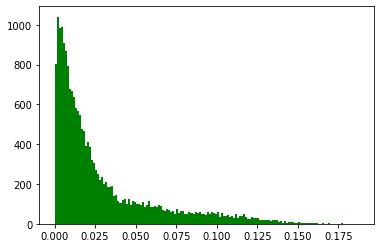

neurite_features
	range: [0.00, 100.10]
	mean: 16.08, std: 14.84


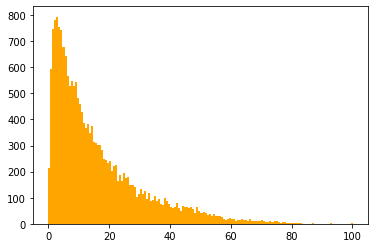

axon_coproj
	range: [0.79, 0.99]
	mean: 0.97, std: 0.03


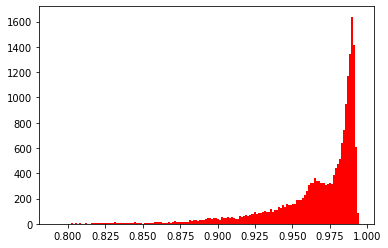

dendrite_coproj
	range: [0.96, 1.00]
	mean: 0.99, std: 0.00


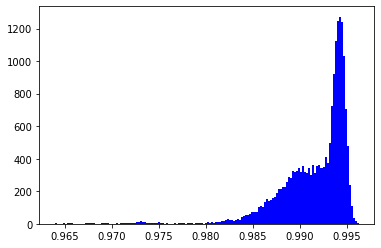

region_vector
	range: [0.00, 3.50]
	mean: 1.60, std: 1.13


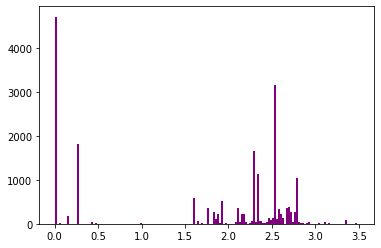

In [389]:
for k in similarities:
    values = np.array(similarities[k])
    print(k)
    print("\trange: [{:.2f}, {:.2f}]".format(min(values), max(values)))
    print("\tmean: {:.2f}, std: {:.2f}".format(values.mean(), values.std()))
    plt.hist(values, bins=150, color=COLORS[k])
    plt.show()

In [390]:
histograms = {}
for index_name, index in INDICES.items():
    hist, bin_edges  = np.histogram(similarities[index_name], bins=100)
    histograms[index_name] = (hist / len(similarities[index_name]), bin_edges)

In [391]:
def find_probability(x, hist, bin_edges):
    smaller_than = np.where((x < bin_edges))
    if len(smaller_than[0]) > 0:
        hist_index = np.where((x < bin_edges))[0][0] - 1
    else:
        hist_index = -1
    return hist[hist_index]

In [ ]:
1 / (1 + d)

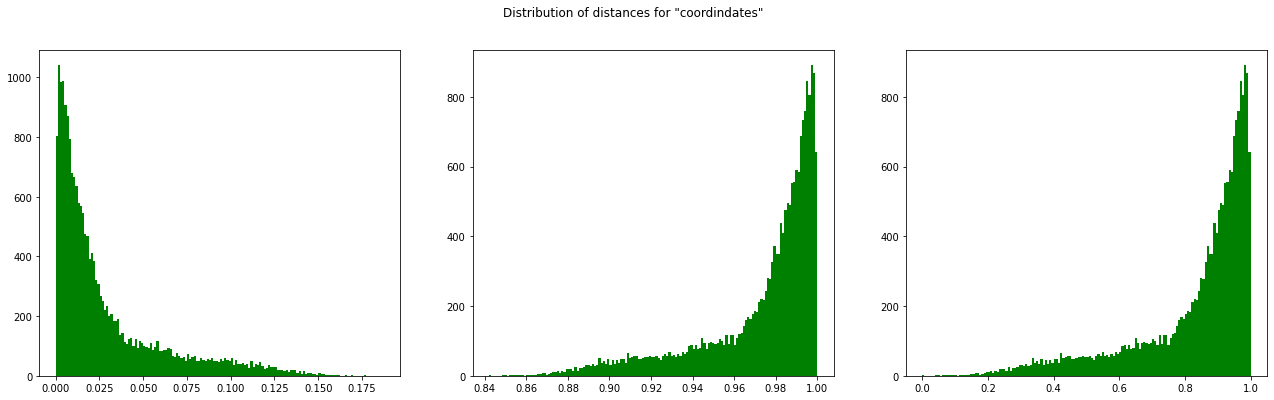

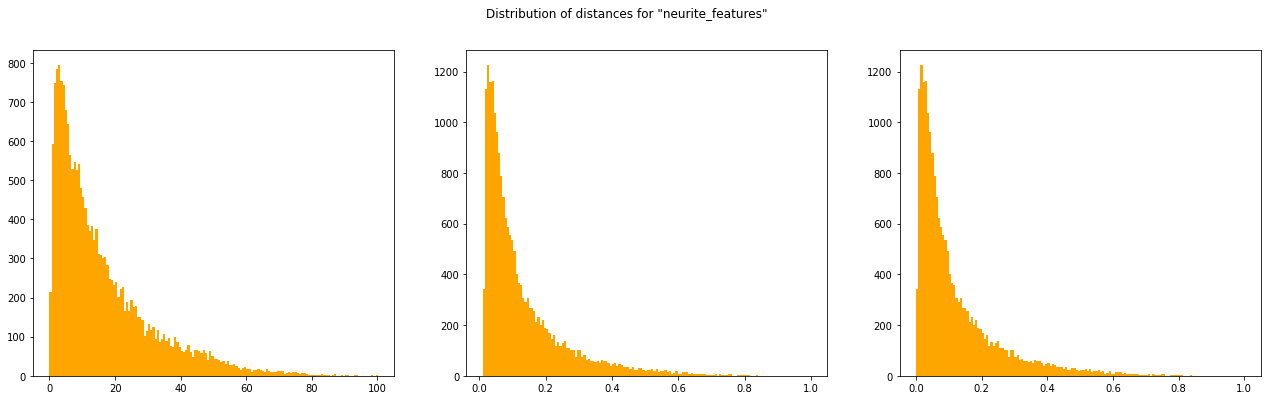

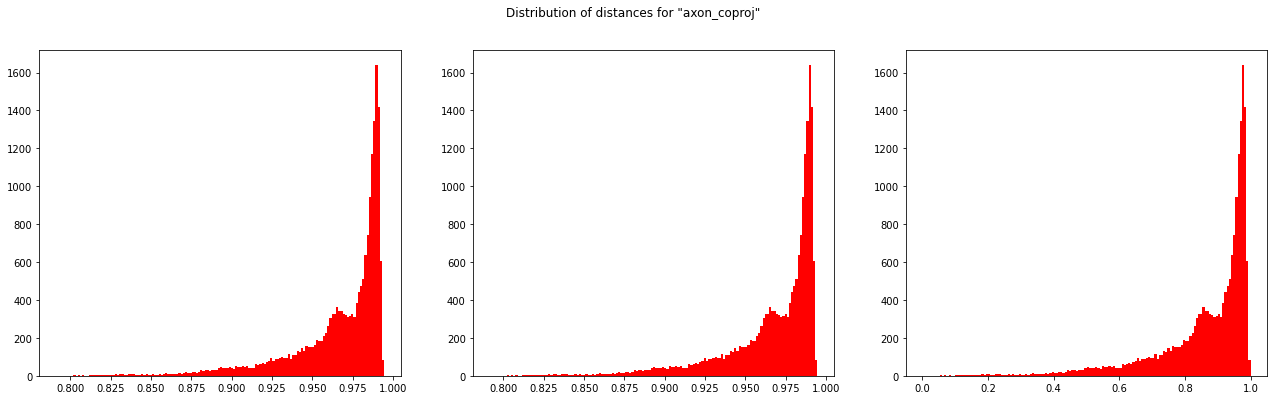

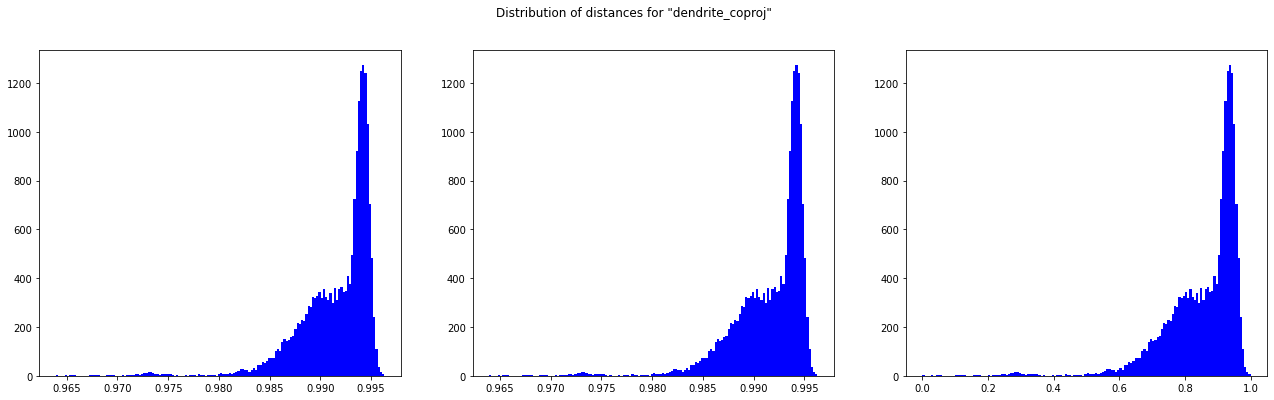

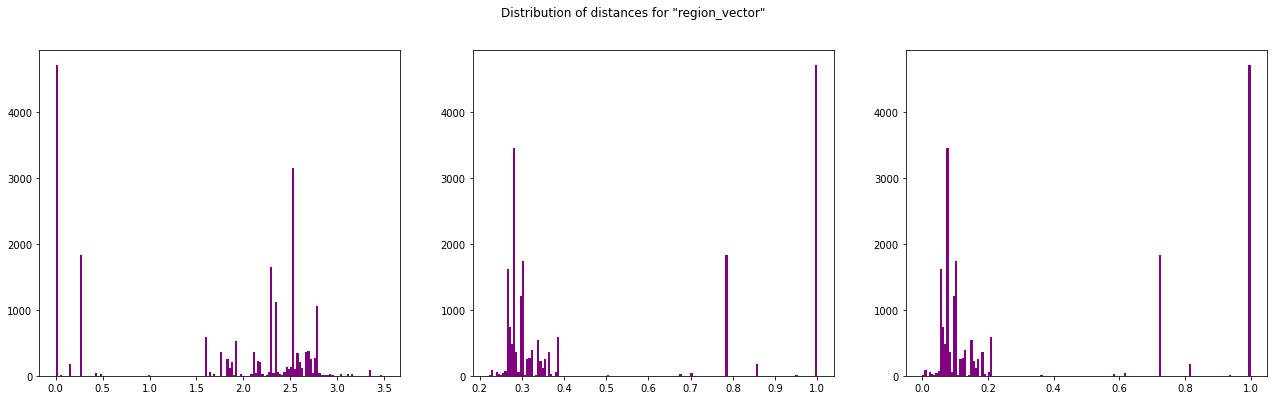

In [392]:
SCALERS = {}
scaled_similarities = {}
for k in similarities:
    raw_values = np.array(similarities[k])
    if SIMILARITIES[k] == "cosine":
        scores = raw_values
        scaled_scores = raw_values
    else:
        scores = 1 / (1 + raw_values)
    
    scaler = sk.preprocessing.MinMaxScaler()
    scaled_scores = scaler.fit_transform(np.reshape(scores, (-1, 1)))
    scaled_similarities[k] = scaled_scores.T[0]
    SCALERS[k] = scaler

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle(f'Distribution of distances for "{k}"')
    ax1.hist(raw_values, bins=150, color=COLORS[k])
    ax2.hist(scores, bins=150, color=COLORS[k])
    ax3.hist(scaled_scores, bins=150, color=COLORS[k])
    plt.show()    

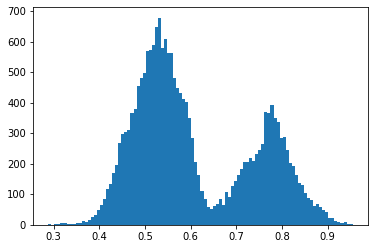

In [393]:
points = list(range(data.shape[0]))
averaged_similarities = set()
for p1 in points:
    for p2 in points:
        if p1 < p2:
            values = []
            for index_name, index in INDICES.items():
                score = compute_distance(index, p1, p2)
                if SIMILARITIES[index_name] != "cosine":
                    score = 1 / (1 + score)
                score = SCALERS[index_name].transform(np.atleast_2d(score).T)
                values.append(score.T[0][0])
            averaged_similarities.add(np.array(values).mean())
            
plt.hist(averaged_similarities, bins=100)
plt.show()

min_avg = min(averaged_similarities)
max_avg = max(averaged_similarities)

In [394]:
score_table = pd.DataFrame(columns=["point"])
for index_name, index in INDICES.items():
    scores, points = query_index(index, [0], 200)
    if SIMILARITIES[index_name] == "cosine":
        scores = scores[0][1:]
    else:
        scores = 1 / (1 + scores[0][1:])
        
    scores = SCALERS[index_name].transform(np.atleast_2d(scores).T)
    score_table = score_table.merge(
        pd.DataFrame(zip(points[0][1:], scores.T[0]), columns=["point", index_name]),
        on="point", how="right")
score_table = score_table.set_index("point")
score_table["average"] = score_table.apply(lambda x: sum(x.tolist()) / len(x.tolist()), axis=1)

In [395]:
score_table.sort_values(by="average", ascending=False)

,coordindates,neurite_features,axon_coproj,dendrite_coproj,region_vector,average
point,,,,,,
151,0.954239,0.494447,0.961322,0.932386,1.000000,0.868479
174,0.970310,0.402291,0.972833,0.964819,1.000000,0.862051
29,0.983250,0.490106,0.916695,0.902784,1.000000,0.858567
188,0.987948,0.399492,0.954927,0.930532,1.000000,0.854580
26,0.977443,0.377719,0.976352,0.907747,1.000000,0.847852
...,...,...,...,...,...,...
78,0.929865,0.109240,0.525357,0.769251,0.078539,0.482450
115,0.569307,0.008440,0.855659,0.917505,0.054628,0.481108
51,0.675079,0.040267,0.886952,0.686701,0.059255,0.469651


In [405]:
P = 174

In [407]:
ranks = []
for index_name in INDICES:
    ranks.append(score_table.sort_values(by=index_name, ascending=False).index.get_loc(P))

In [411]:
int(sum(ranks) / len(INDICES))

23

In [421]:
score_table

,coordindates,neurite_features,axon_coproj,dendrite_coproj,region_vector,average
point,,,,,,
176,0.982678,0.163976,0.948924,0.906321,1.000000,0.800380
165,0.973678,0.358031,0.936167,0.945665,1.000000,0.842708
182,0.993770,0.150046,0.971561,0.942726,1.000000,0.811621
197,0.943298,0.020991,0.926916,0.940174,1.000000,0.766276
19,0.988788,0.190186,0.941346,0.911600,1.000000,0.806384
...,...,...,...,...,...,...
133,0.692811,0.481056,0.878100,0.861036,0.054420,0.593485
118,0.706813,0.046788,0.869728,0.938997,0.054420,0.523349
135,0.614409,0.023528,0.878587,0.866358,0.054420,0.487460


In [ ]:
def get_avg_by_rank(table):
    

In [418]:
percents = []
for index_name in INDICES:
    score = score_table.loc[P][index_name]
    percents.append(sum(score_table[index_name] < score) / score_table.shape[0])

In [420]:
sum(percents) / len(INDICES)

0.8

In [398]:
score_table.loc[174]

coordindates        0.970310
neurite_features    0.402291
axon_coproj         0.972833
dendrite_coproj     0.964819
region_vector       1.000000
average             0.862051
Name: 174, dtype: float64

Morphology:  151  score: 0.87 normalized score: 0.87
	coordindates: 0.95, better than 51.26% of morphologies
	neurite_features: 0.49, better than 95.48% of morphologies
	axon_coproj: 0.96, better than 80.90% of morphologies
	dendrite_coproj: 0.93, better than 72.86% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


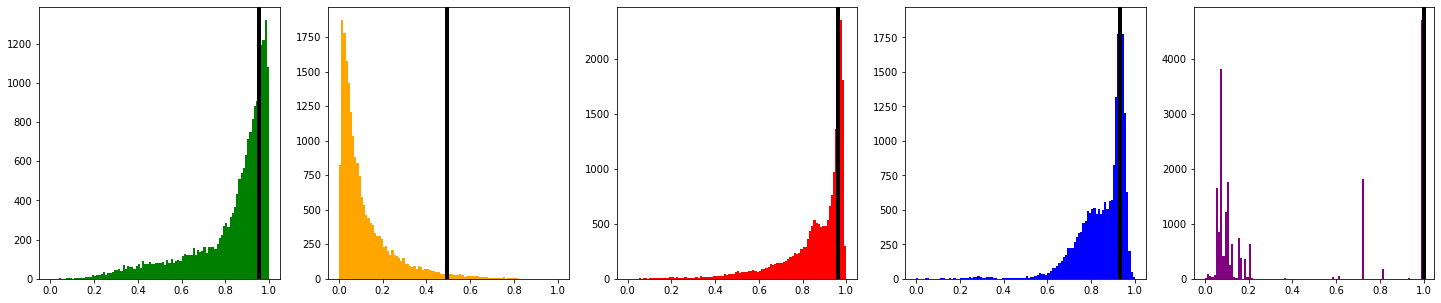

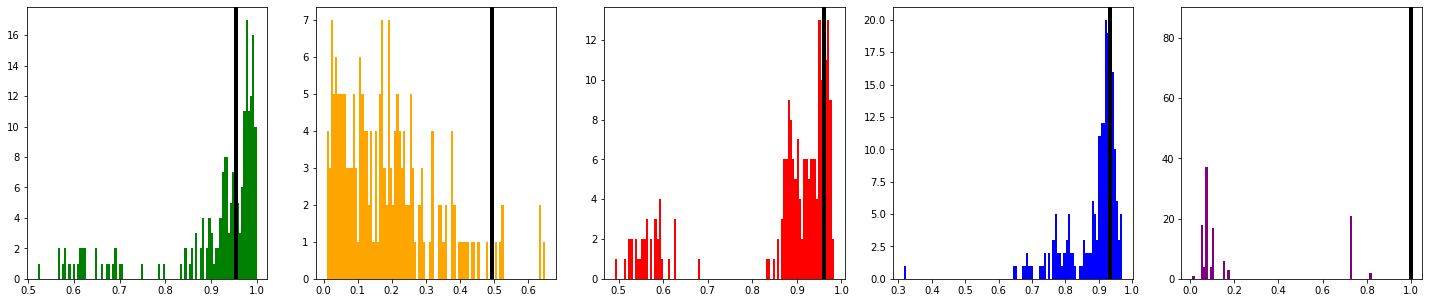

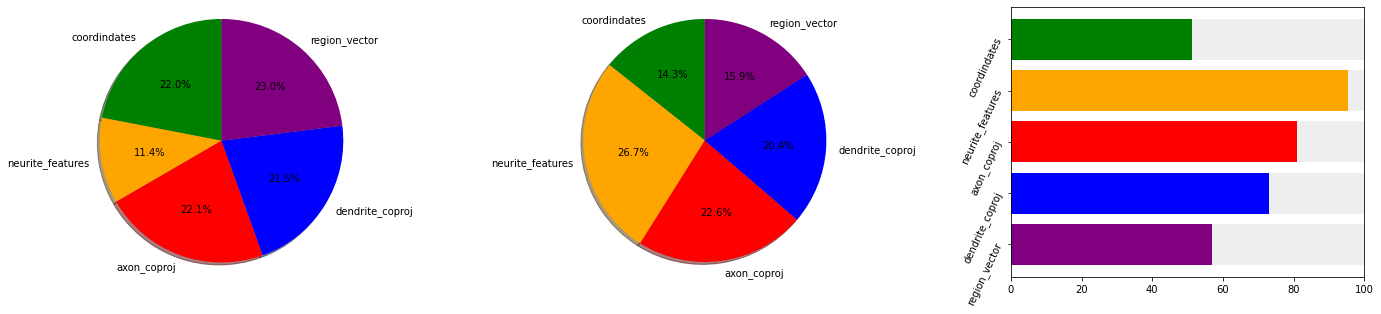

Morphology:  174  score: 0.86 normalized score: 0.86
	coordindates: 0.97, better than 61.31% of morphologies
	neurite_features: 0.40, better than 90.95% of morphologies
	axon_coproj: 0.97, better than 93.47% of morphologies
	dendrite_coproj: 0.96, better than 97.49% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


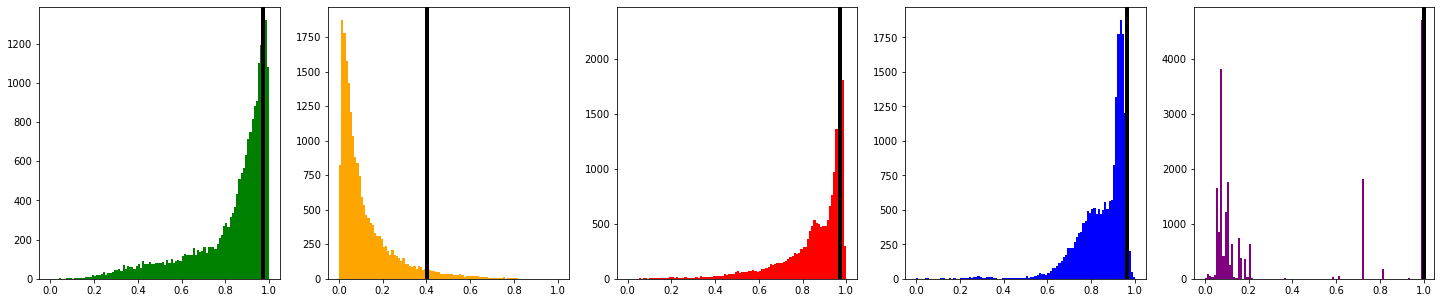

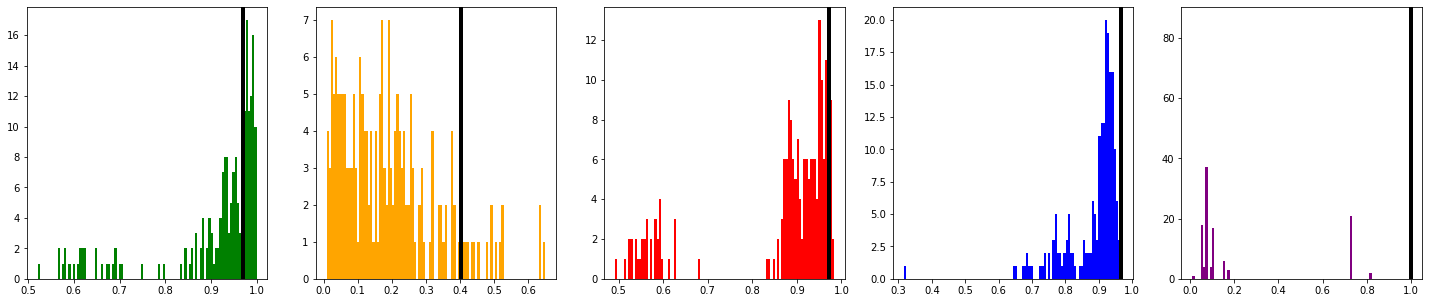

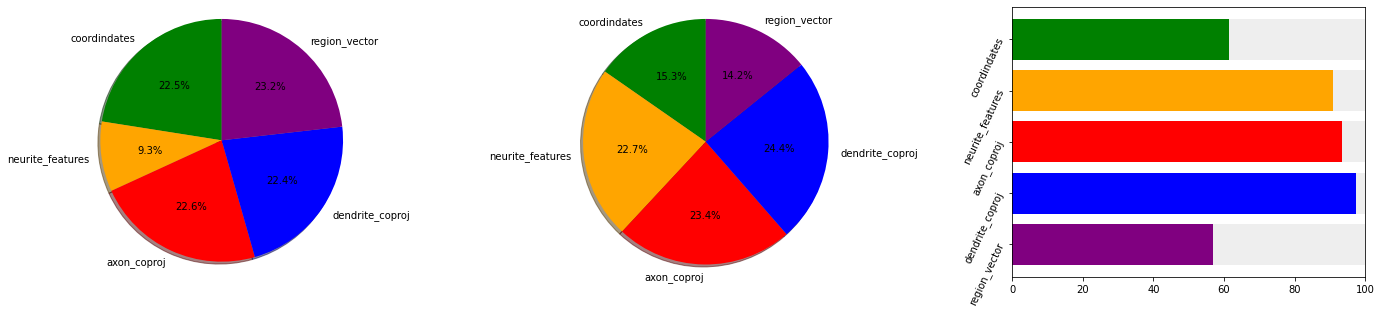

Morphology:  29  score: 0.86 normalized score: 0.86
	coordindates: 0.98, better than 78.39% of morphologies
	neurite_features: 0.49, better than 94.97% of morphologies
	axon_coproj: 0.92, better than 48.74% of morphologies
	dendrite_coproj: 0.90, better than 36.68% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


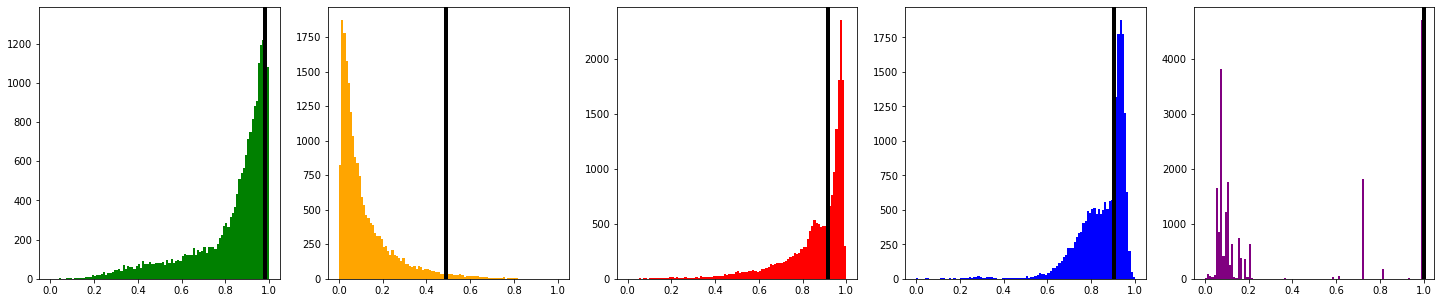

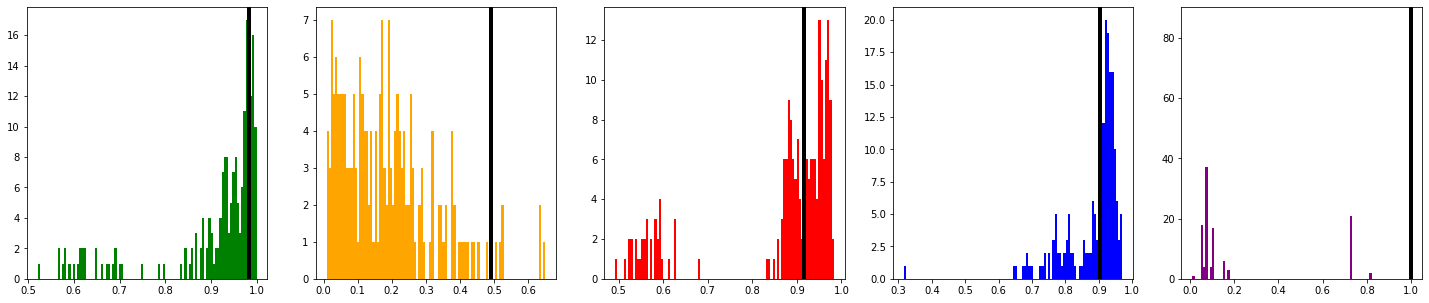

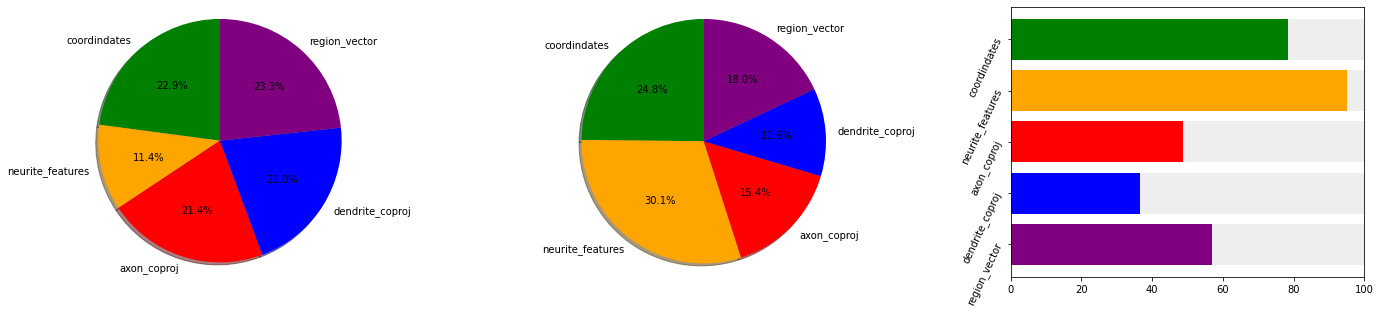

Morphology:  188  score: 0.85 normalized score: 0.85
	coordindates: 0.99, better than 82.91% of morphologies
	neurite_features: 0.40, better than 90.45% of morphologies
	axon_coproj: 0.95, better than 74.37% of morphologies
	dendrite_coproj: 0.93, better than 69.85% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


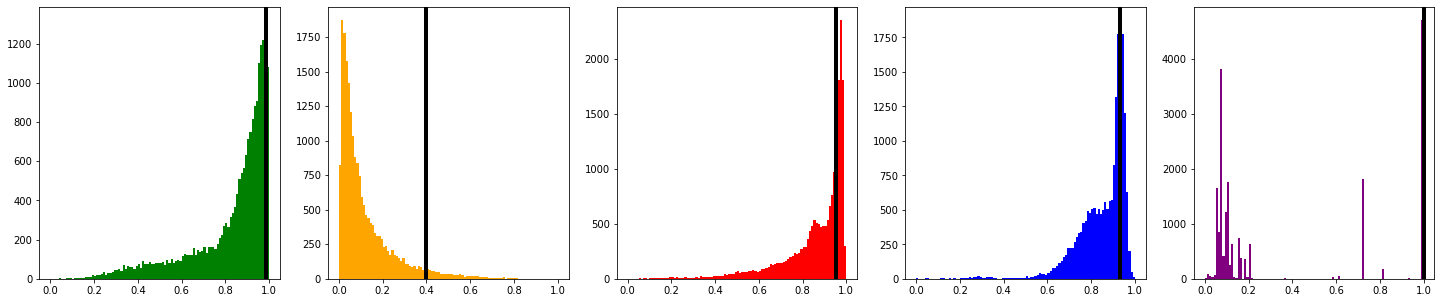

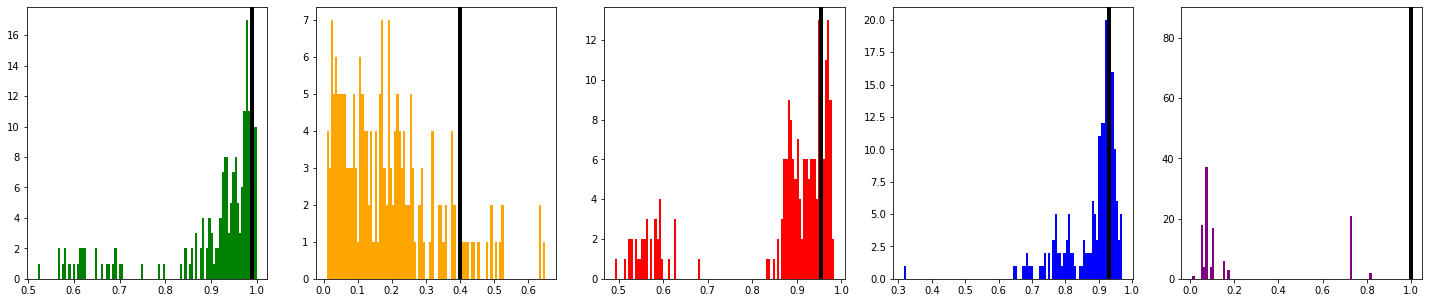

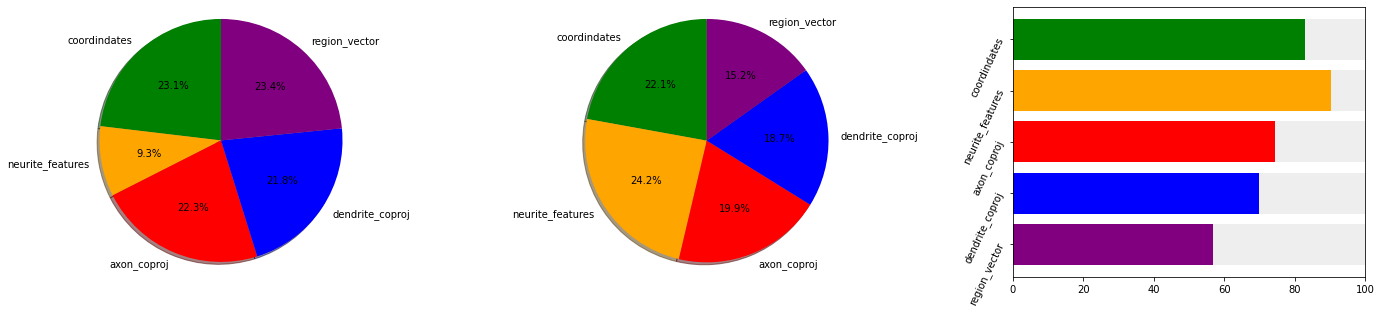

Morphology:  26  score: 0.85 normalized score: 0.84
	coordindates: 0.98, better than 68.84% of morphologies
	neurite_features: 0.38, better than 87.94% of morphologies
	axon_coproj: 0.98, better than 97.99% of morphologies
	dendrite_coproj: 0.91, better than 42.21% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


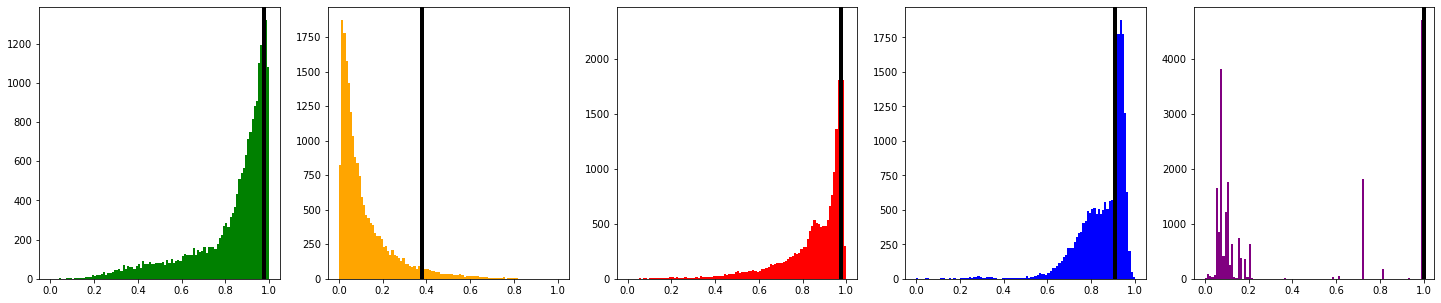

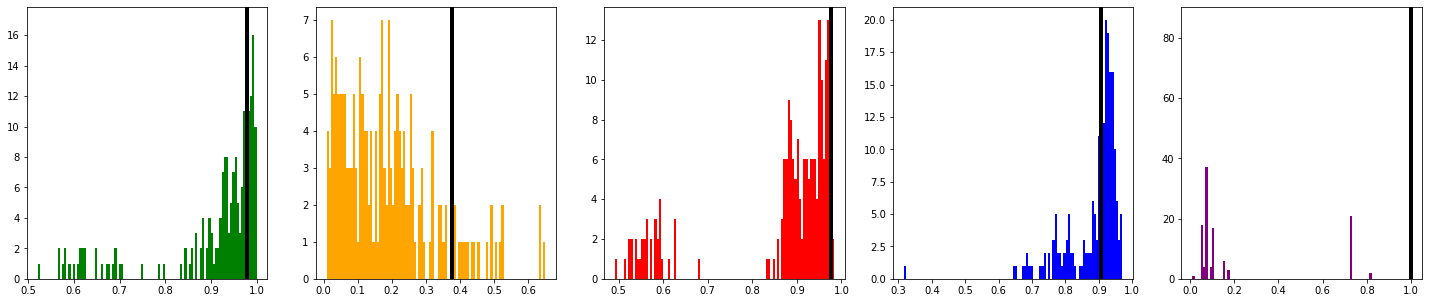

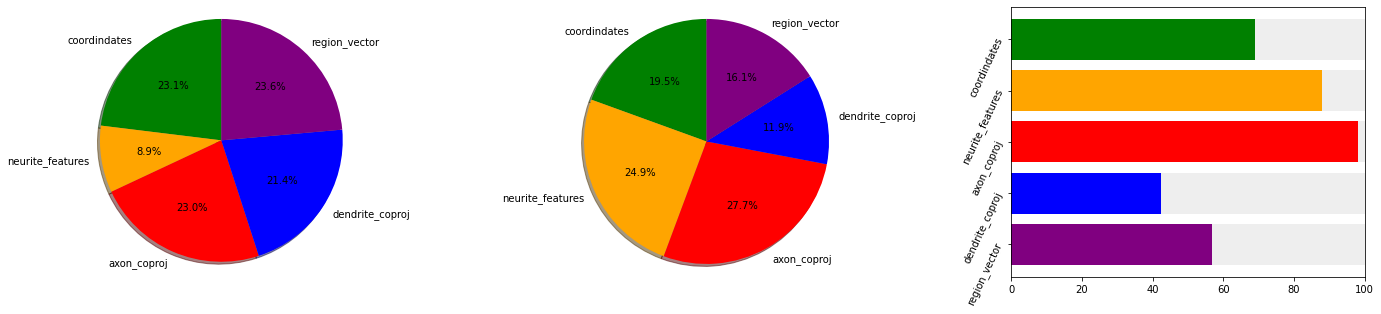

Morphology:  27  score: 0.85 normalized score: 0.84
	coordindates: 0.98, better than 66.33% of morphologies
	neurite_features: 0.39, better than 89.95% of morphologies
	axon_coproj: 0.91, better than 46.73% of morphologies
	dendrite_coproj: 0.96, better than 95.48% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


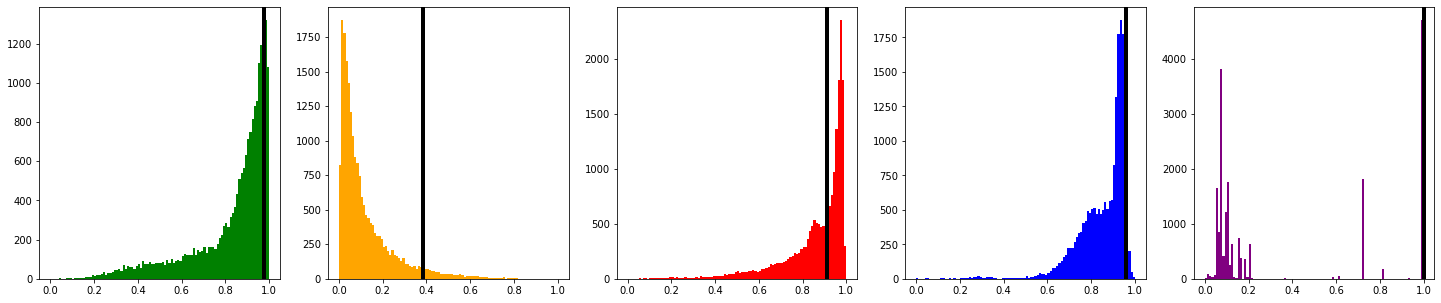

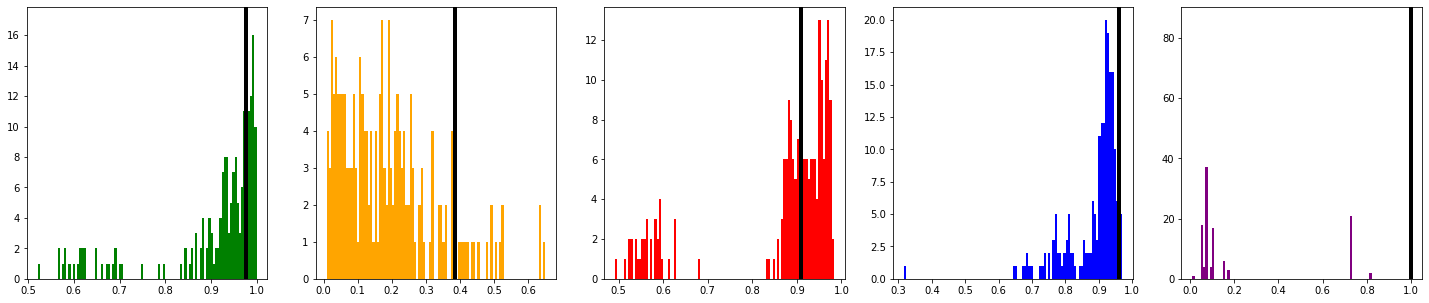

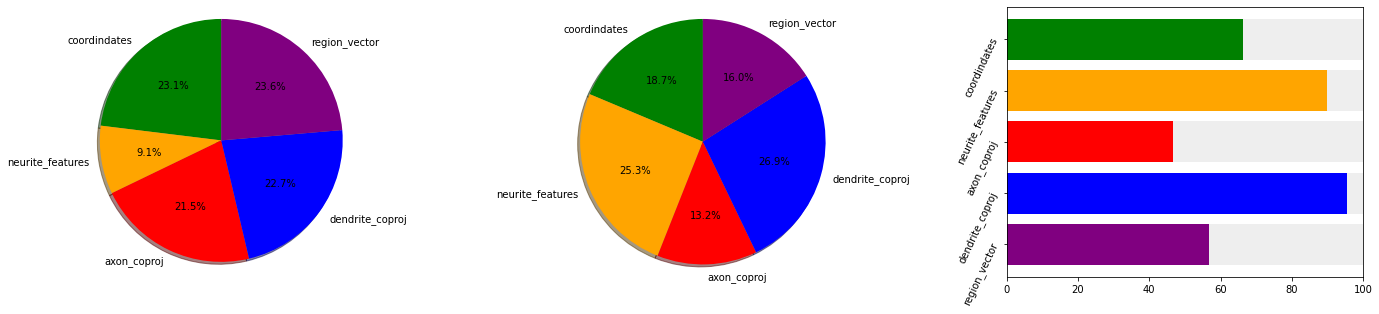

Morphology:  179  score: 0.85 normalized score: 0.84
	coordindates: 0.99, better than 85.93% of morphologies
	neurite_features: 0.32, better than 82.91% of morphologies
	axon_coproj: 0.96, better than 79.40% of morphologies
	dendrite_coproj: 0.96, better than 93.47% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


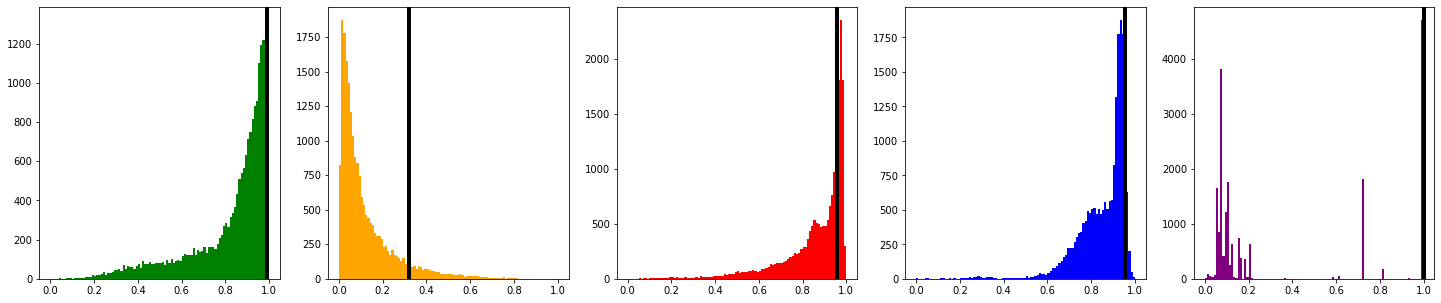

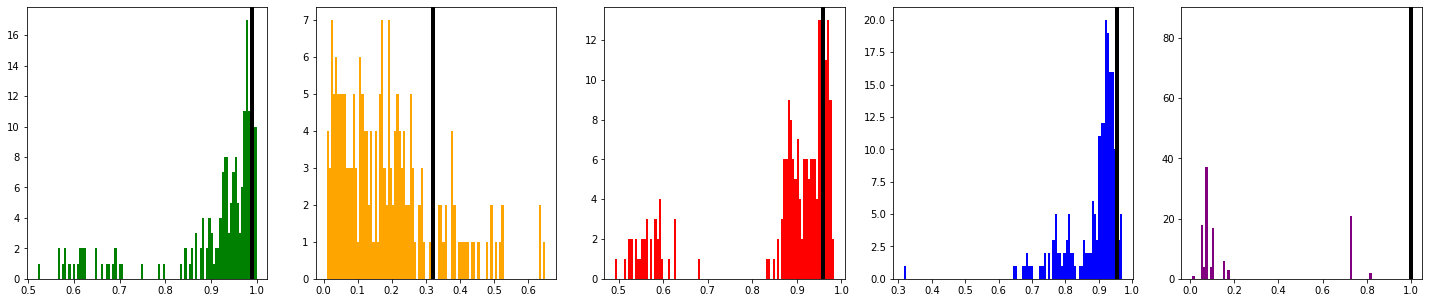

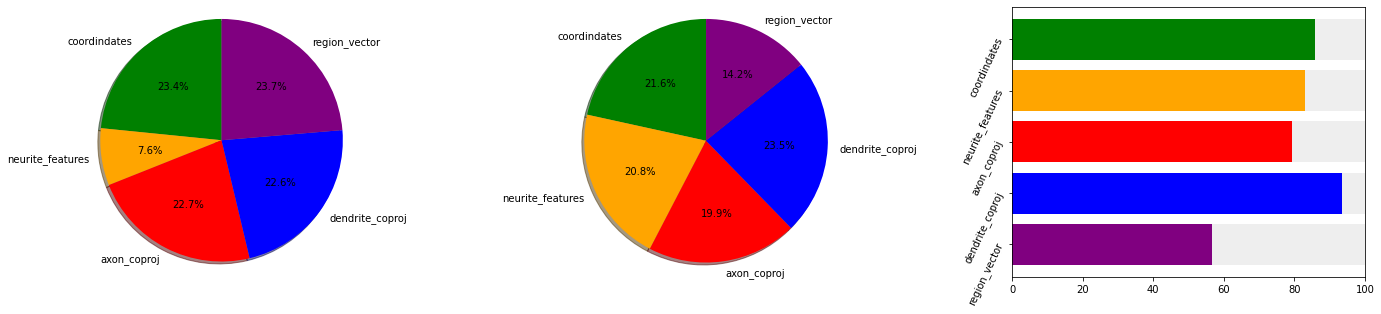

Morphology:  171  score: 0.84 normalized score: 0.83
	coordindates: 0.99, better than 94.47% of morphologies
	neurite_features: 0.42, better than 91.96% of morphologies
	axon_coproj: 0.90, better than 42.71% of morphologies
	dendrite_coproj: 0.91, better than 40.70% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


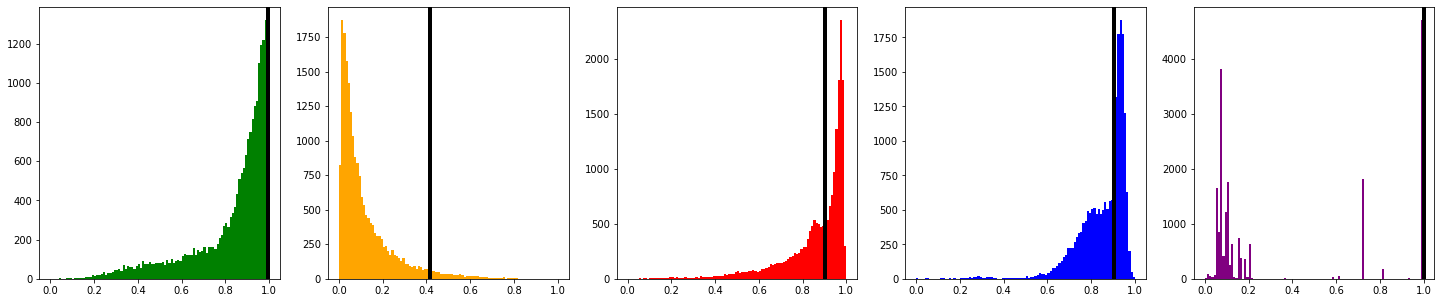

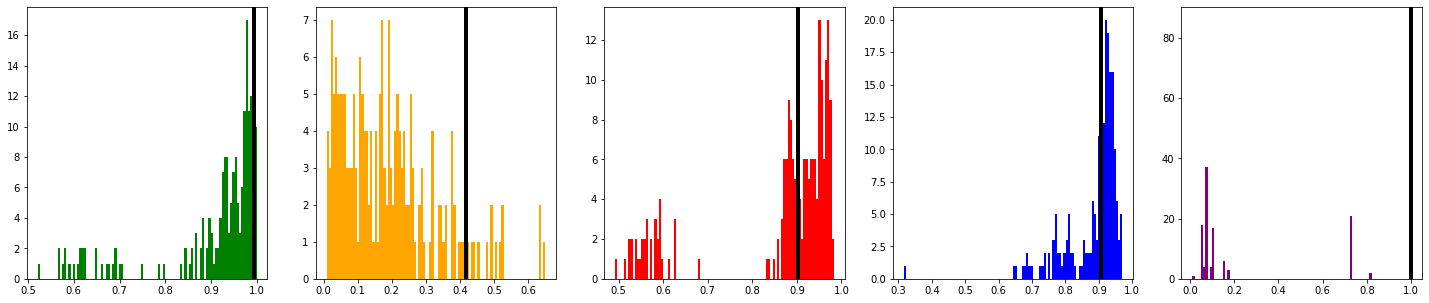

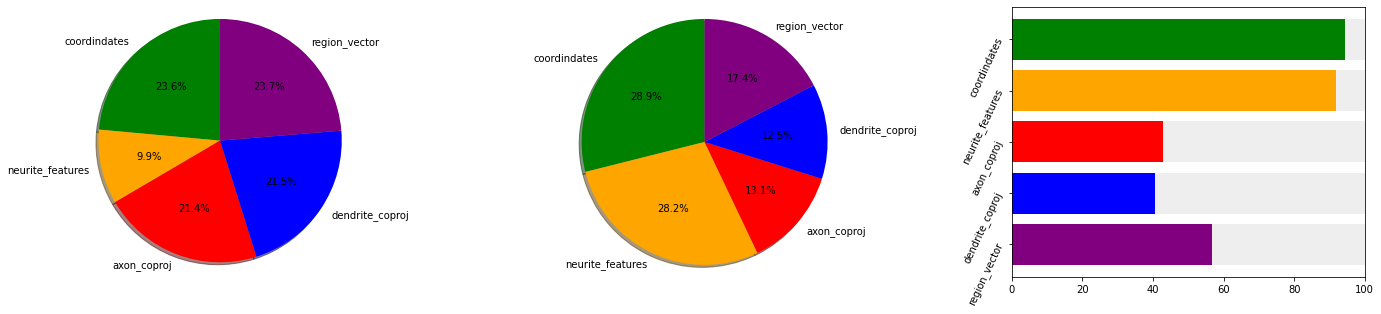

Morphology:  165  score: 0.84 normalized score: 0.83
	coordindates: 0.97, better than 64.32% of morphologies
	neurite_features: 0.36, better than 86.43% of morphologies
	axon_coproj: 0.94, better than 60.80% of morphologies
	dendrite_coproj: 0.95, better than 88.44% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


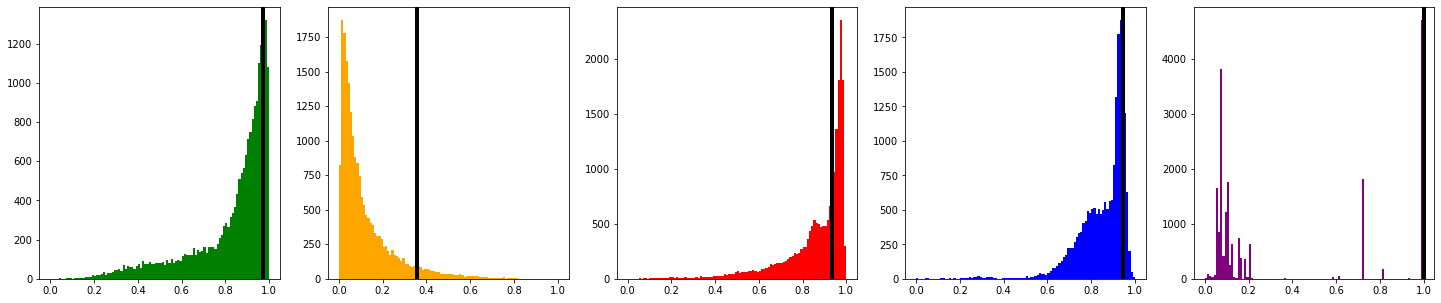

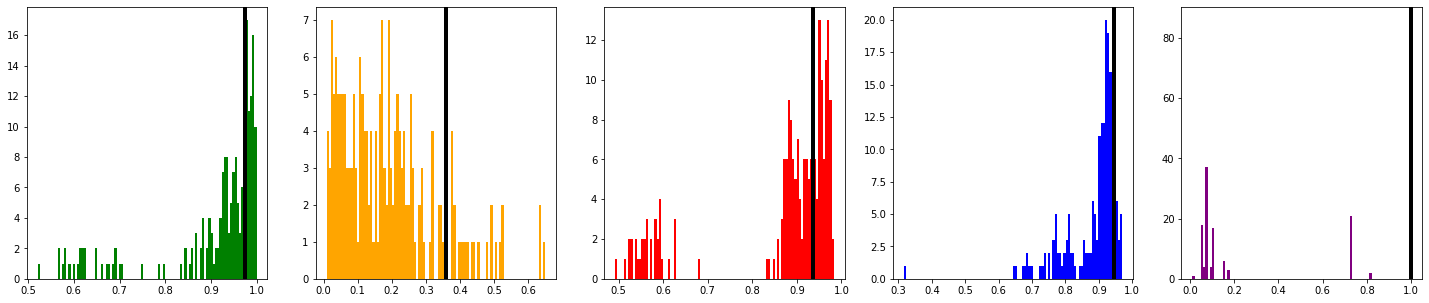

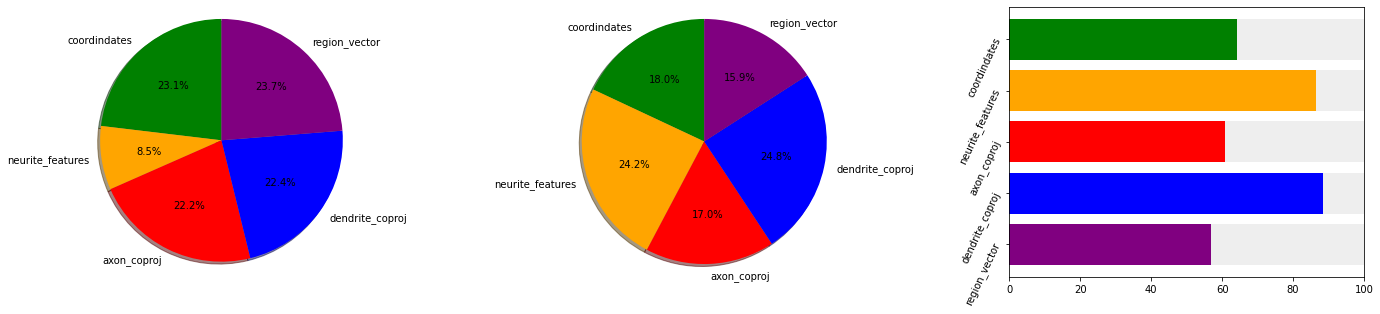

Morphology:  153  score: 0.84 normalized score: 0.83
	coordindates: 0.98, better than 71.86% of morphologies
	neurite_features: 0.64, better than 97.99% of morphologies
	axon_coproj: 0.97, better than 89.45% of morphologies
	dendrite_coproj: 0.90, better than 38.19% of morphologies
	region_vector: 0.72, better than 45.23% of morphologies


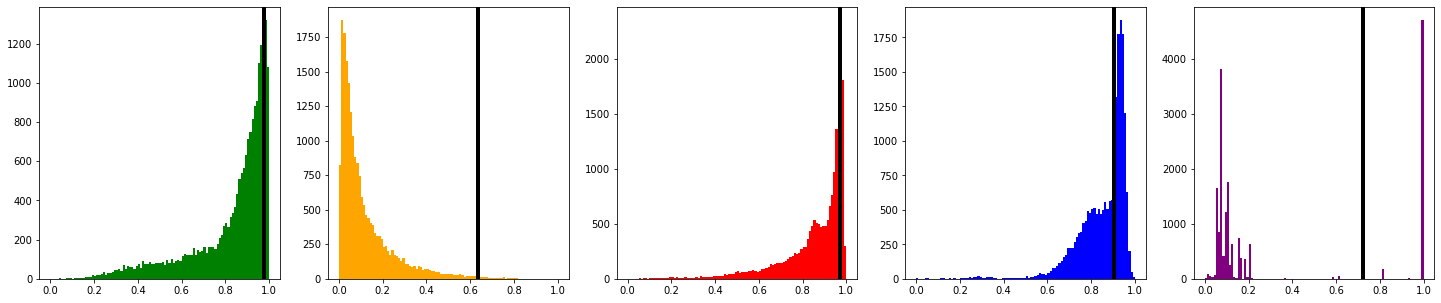

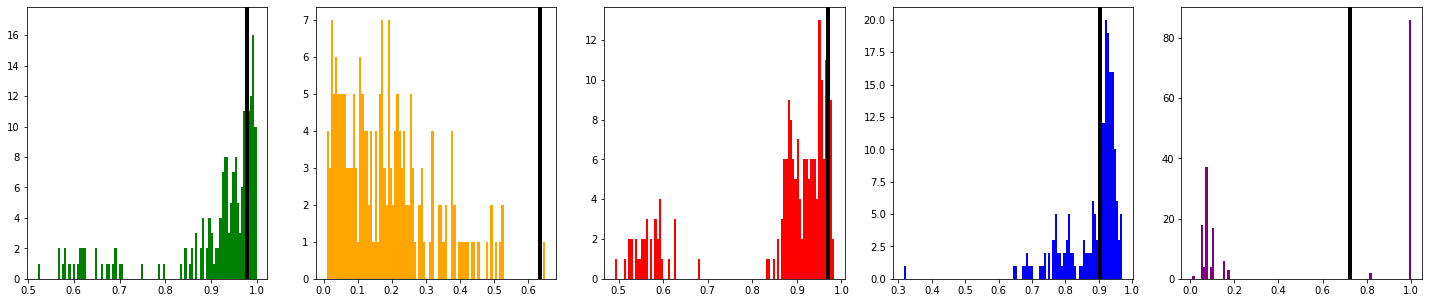

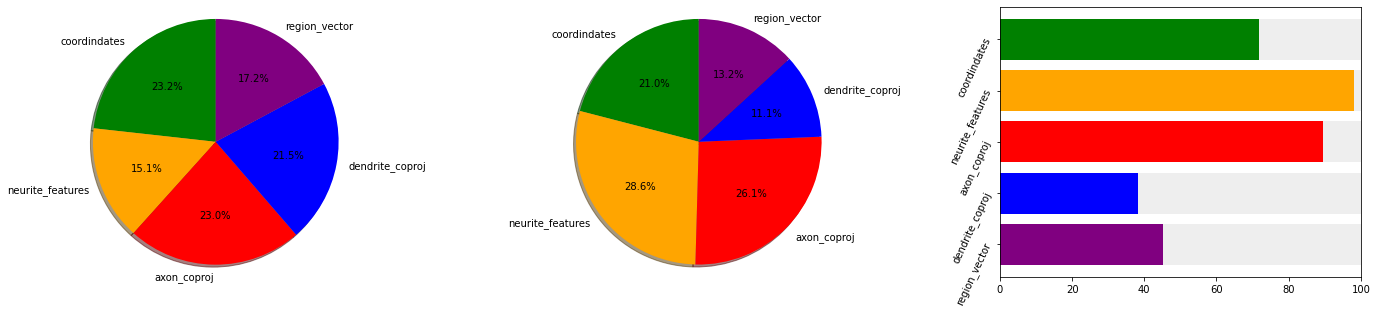

Morphology:  189  score: 0.84 normalized score: 0.82
	coordindates: 0.99, better than 91.96% of morphologies
	neurite_features: 0.32, better than 81.91% of morphologies
	axon_coproj: 0.97, better than 85.43% of morphologies
	dendrite_coproj: 0.91, better than 41.21% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


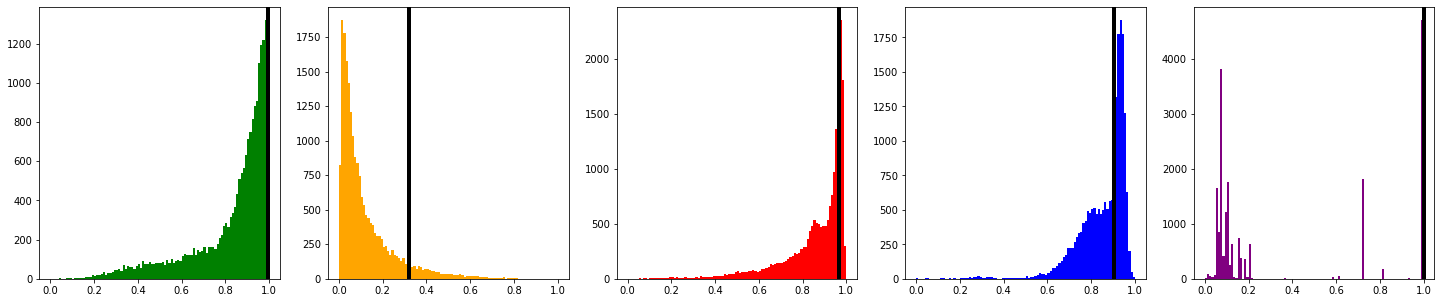

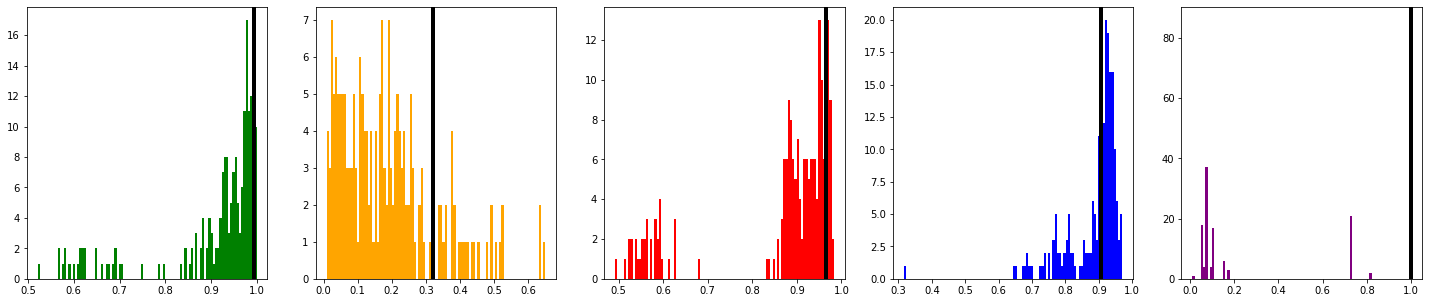

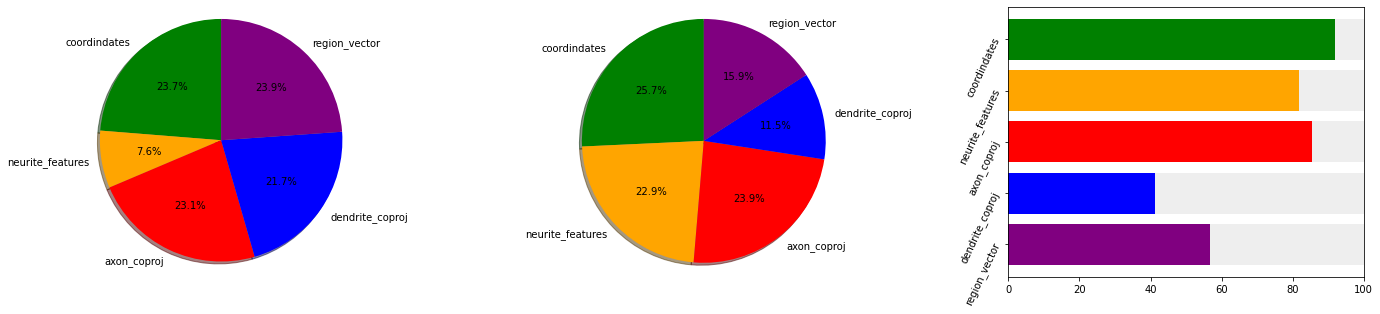

Morphology:  117  score: 0.84 normalized score: 0.82
	coordindates: 0.97, better than 58.29% of morphologies
	neurite_features: 0.65, better than 98.99% of morphologies
	axon_coproj: 0.95, better than 68.34% of morphologies
	dendrite_coproj: 0.89, better than 32.16% of morphologies
	region_vector: 0.72, better than 45.23% of morphologies


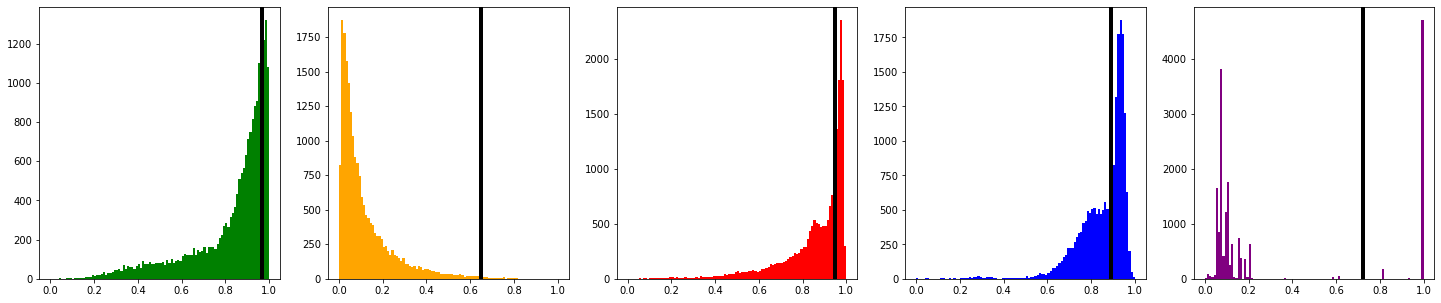

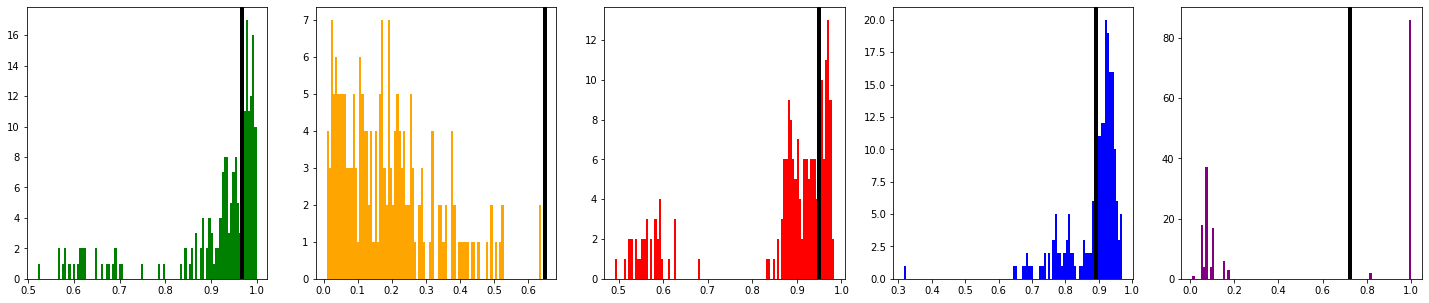

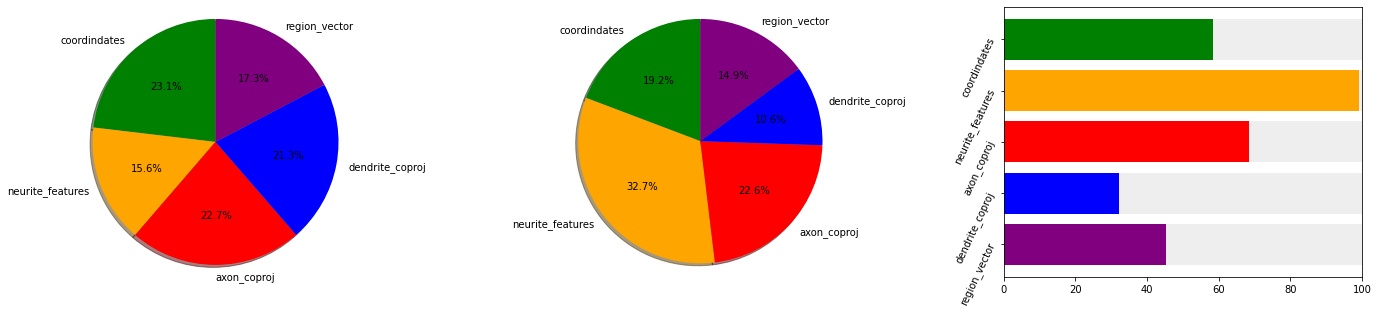

Morphology:  172  score: 0.83 normalized score: 0.82
	coordindates: 0.97, better than 58.79% of morphologies
	neurite_features: 0.35, better than 85.43% of morphologies
	axon_coproj: 0.94, better than 64.32% of morphologies
	dendrite_coproj: 0.92, better than 49.75% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


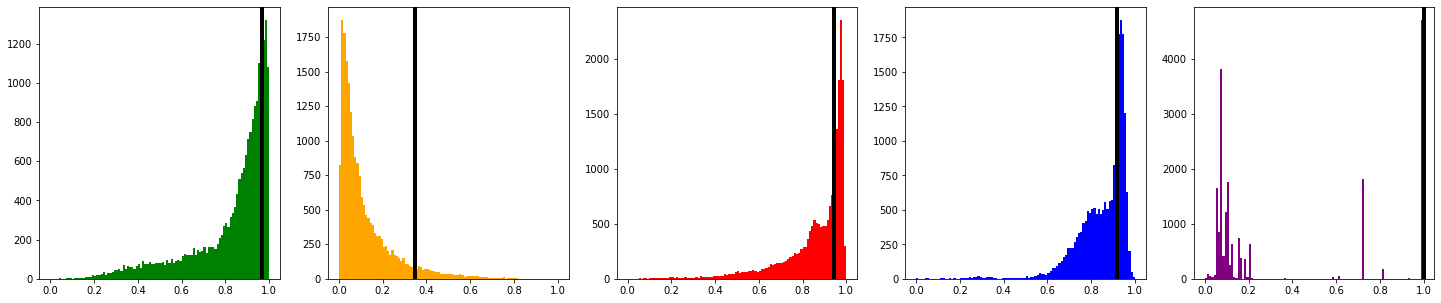

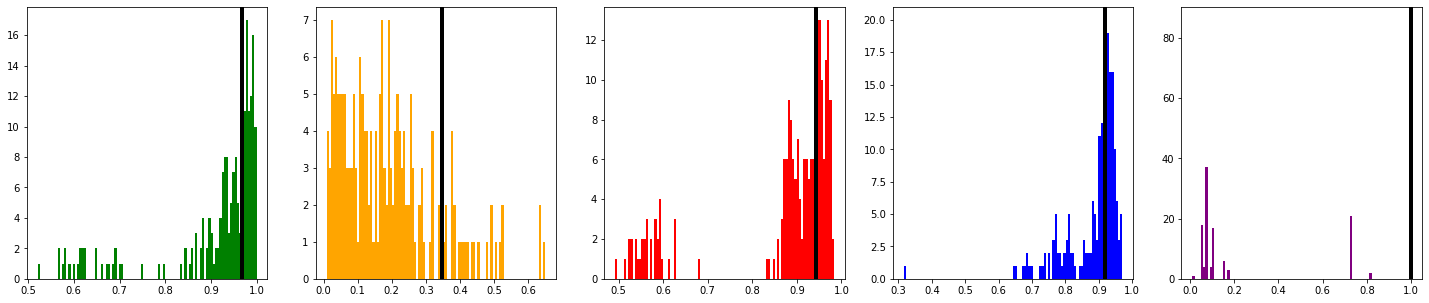

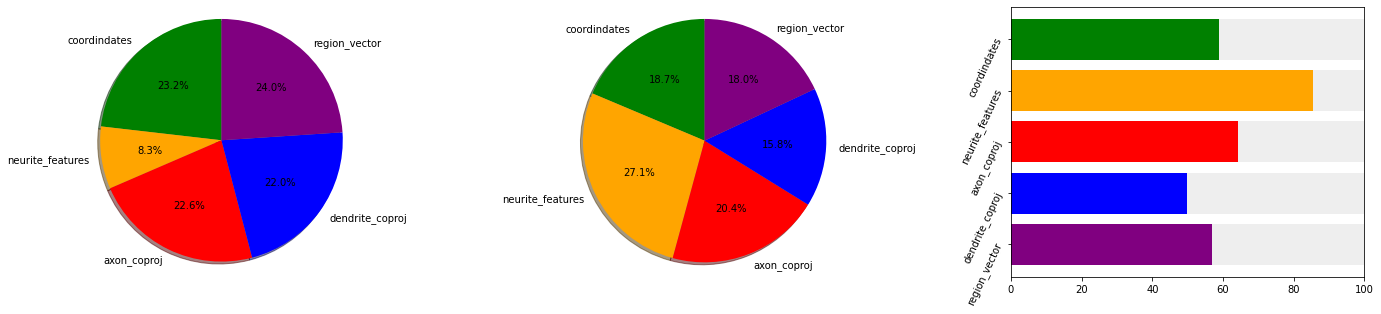

Morphology:  12  score: 0.83 normalized score: 0.81
	coordindates: 1.00, better than 97.99% of morphologies
	neurite_features: 0.23, better than 70.35% of morphologies
	axon_coproj: 0.98, better than 97.49% of morphologies
	dendrite_coproj: 0.94, better than 83.92% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


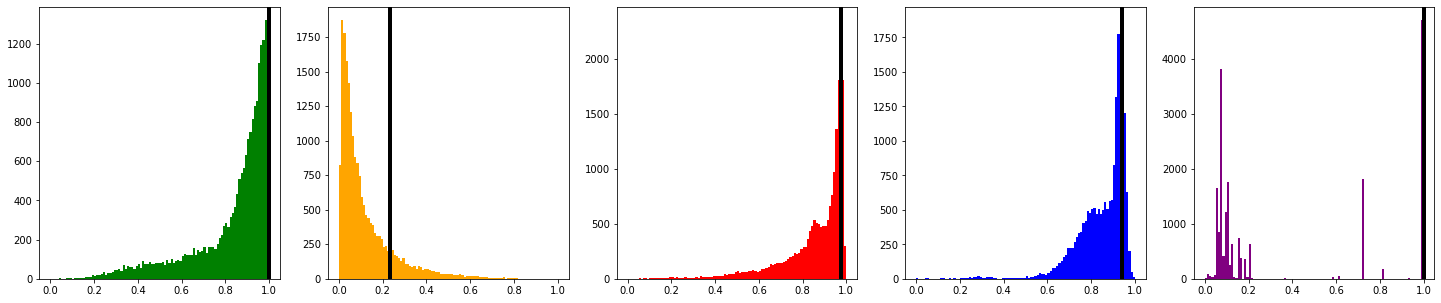

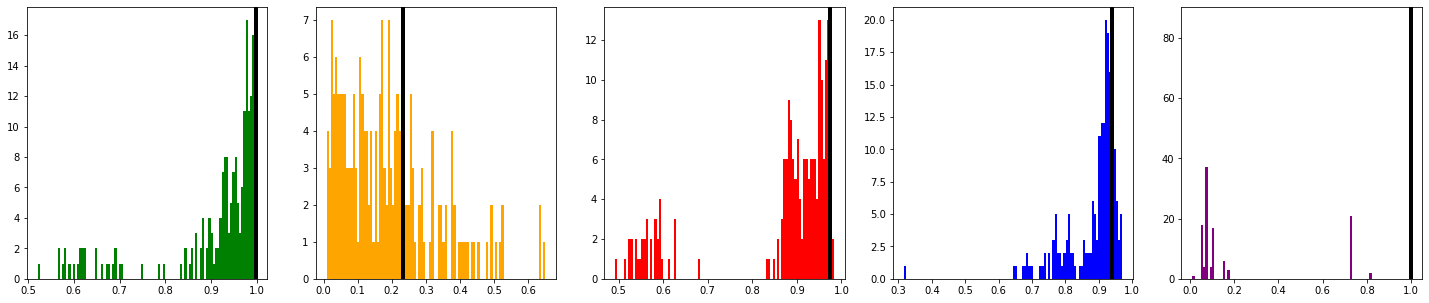

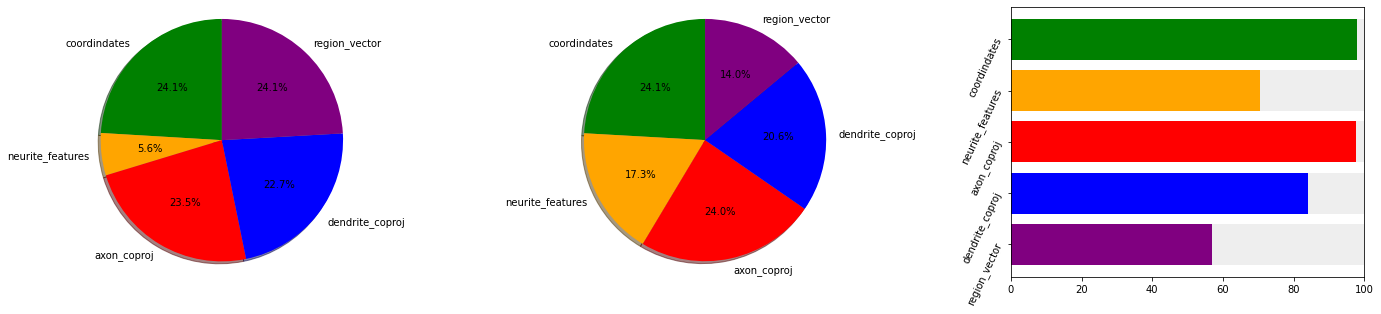

Morphology:  186  score: 0.83 normalized score: 0.81
	coordindates: 0.99, better than 88.94% of morphologies
	neurite_features: 0.28, better than 78.89% of morphologies
	axon_coproj: 0.96, better than 79.90% of morphologies
	dendrite_coproj: 0.91, better than 44.72% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


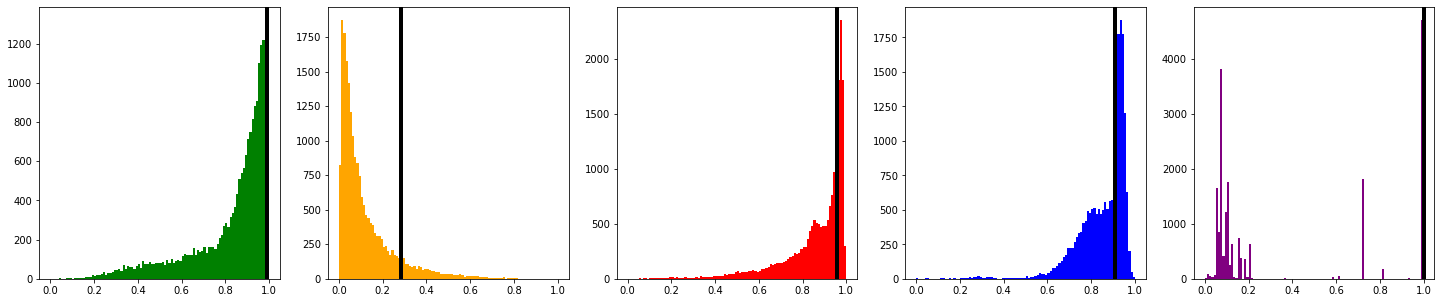

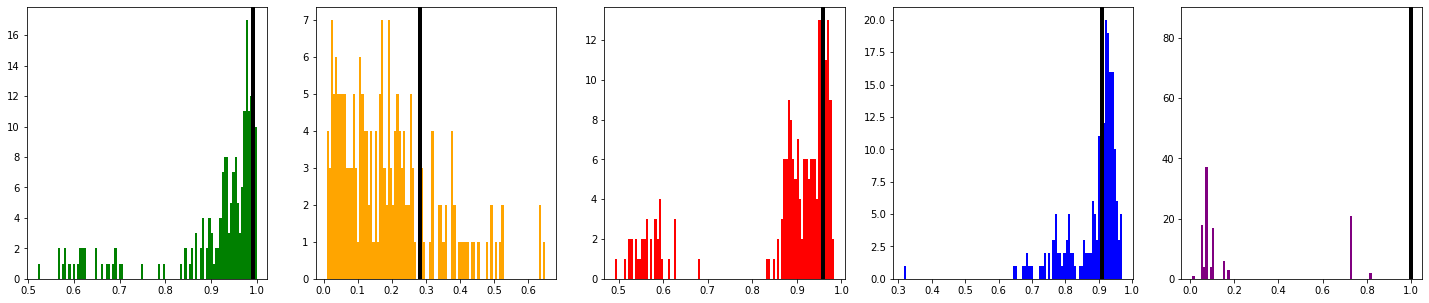

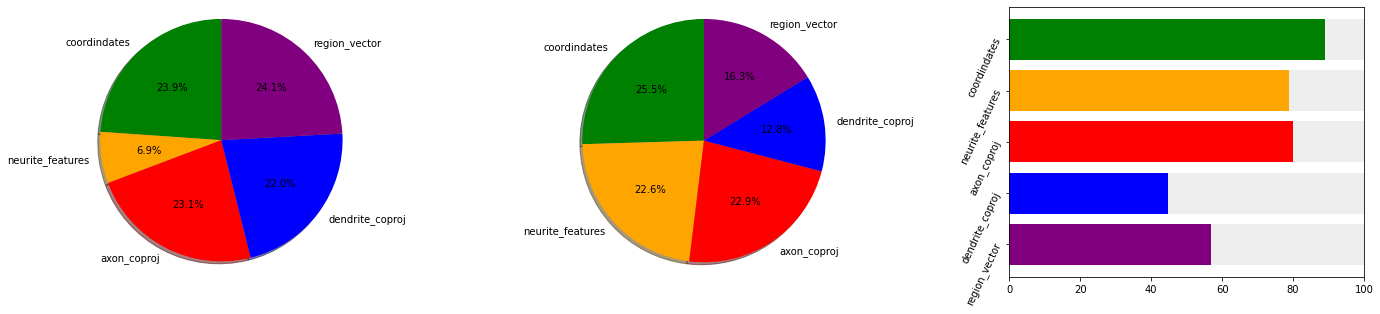

Morphology:  199  score: 0.83 normalized score: 0.81
	coordindates: 0.98, better than 75.38% of morphologies
	neurite_features: 0.26, better than 76.38% of morphologies
	axon_coproj: 0.97, better than 83.92% of morphologies
	dendrite_coproj: 0.93, better than 73.87% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


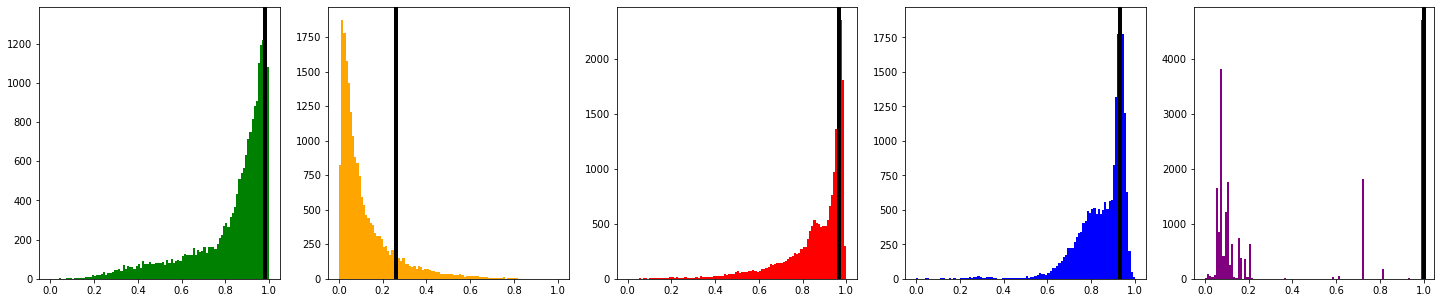

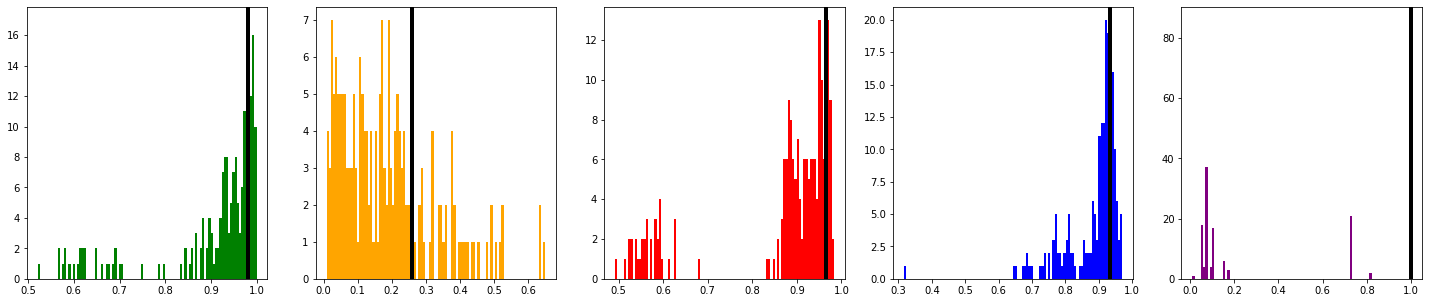

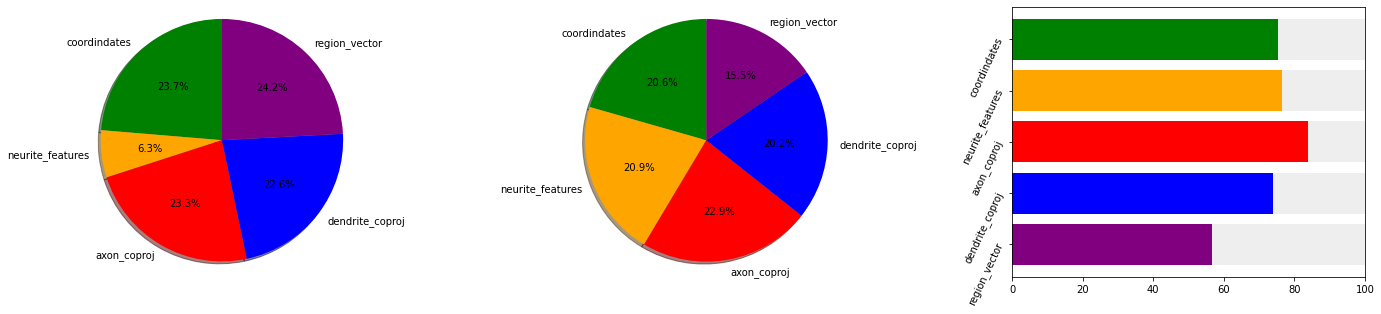

Morphology:  21  score: 0.83 normalized score: 0.81
	coordindates: 0.98, better than 72.86% of morphologies
	neurite_features: 0.28, better than 78.39% of morphologies
	axon_coproj: 0.96, better than 81.41% of morphologies
	dendrite_coproj: 0.91, better than 47.24% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


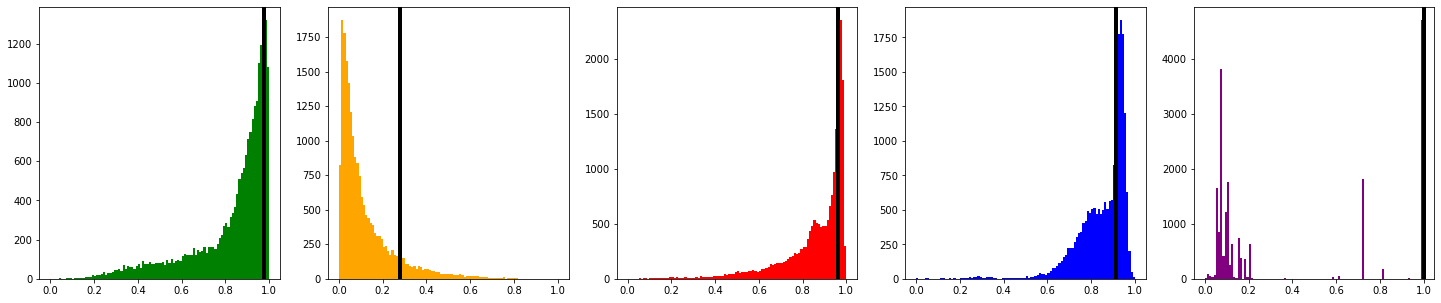

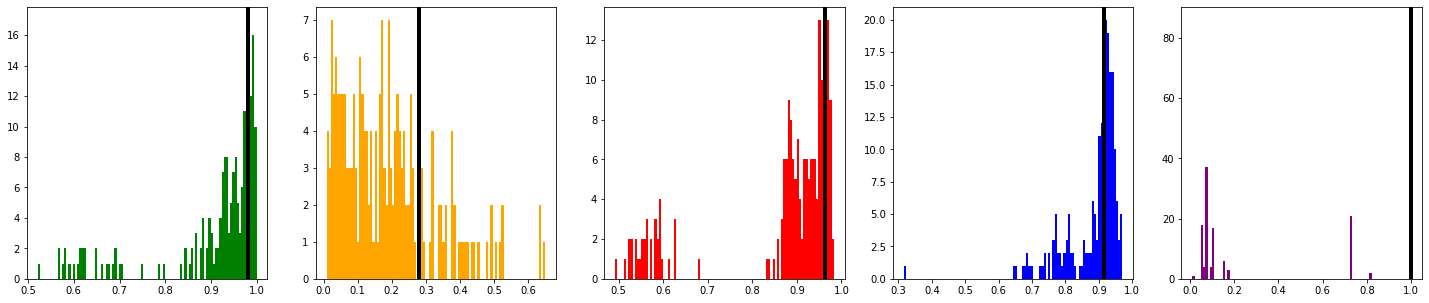

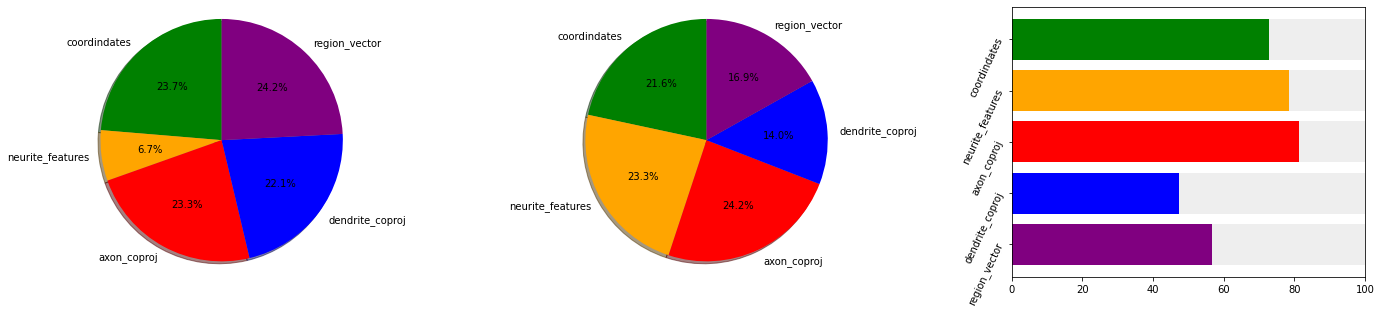

Morphology:  46  score: 0.83 normalized score: 0.81
	coordindates: 0.98, better than 76.38% of morphologies
	neurite_features: 0.25, better than 74.37% of morphologies
	axon_coproj: 0.97, better than 88.44% of morphologies
	dendrite_coproj: 0.93, better than 64.82% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


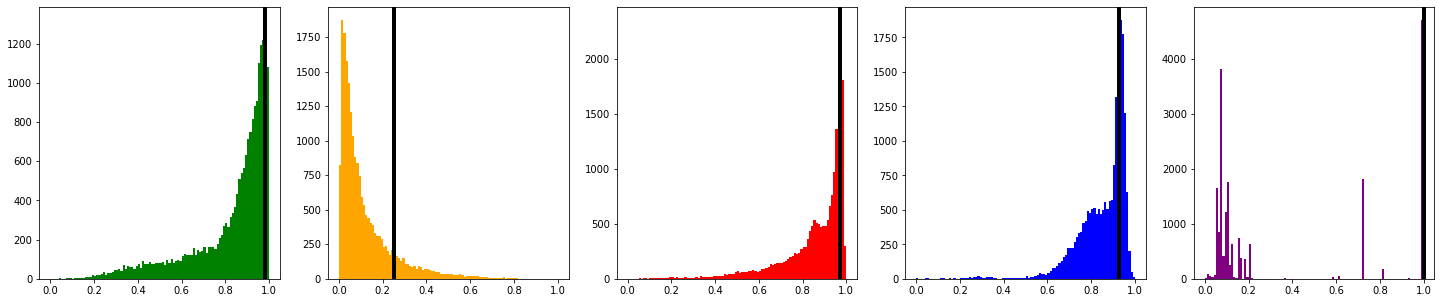

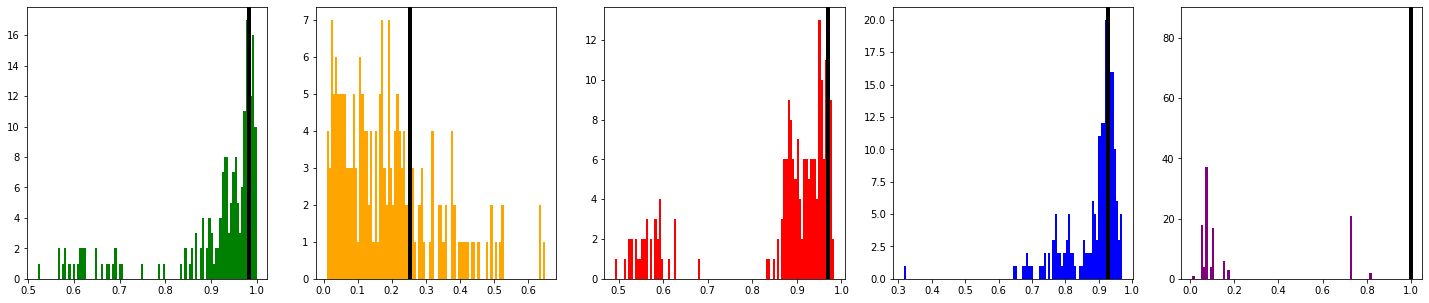

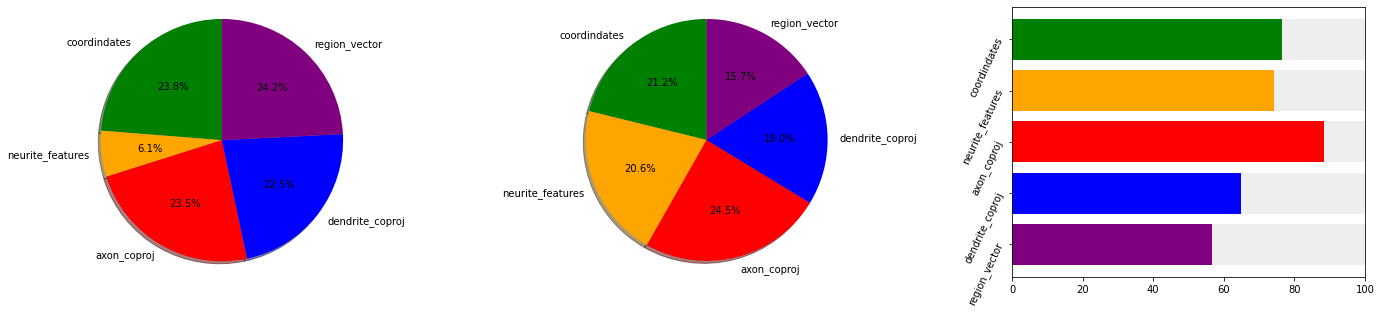

Morphology:  1  score: 0.83 normalized score: 0.81
	coordindates: 0.99, better than 93.97% of morphologies
	neurite_features: 0.23, better than 67.84% of morphologies
	axon_coproj: 0.97, better than 96.98% of morphologies
	dendrite_coproj: 0.93, better than 74.87% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


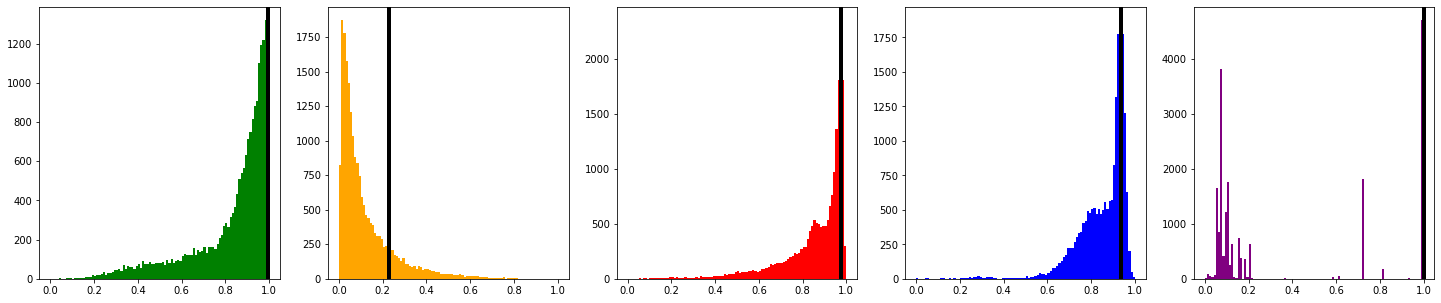

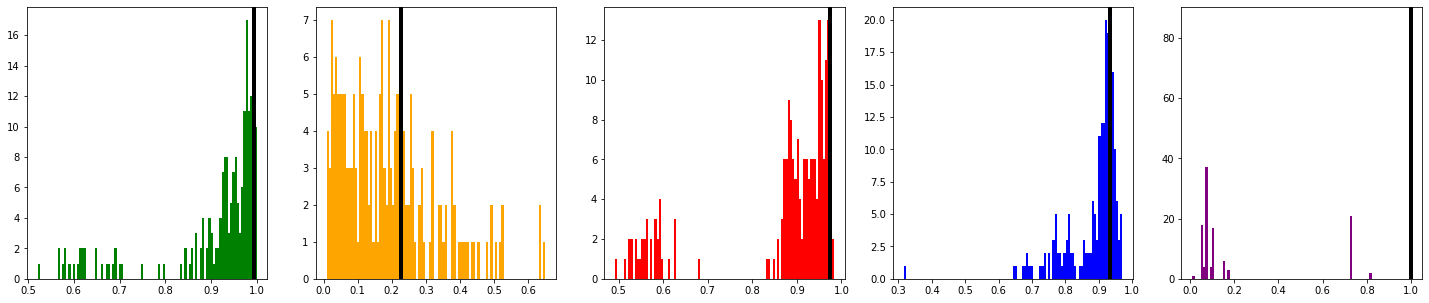

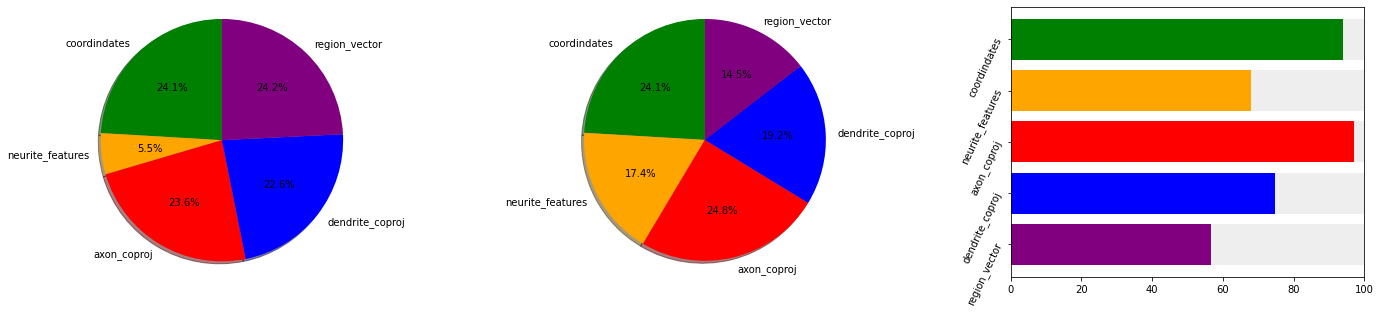

Morphology:  167  score: 0.83 normalized score: 0.81
	coordindates: 0.97, better than 62.31% of morphologies
	neurite_features: 0.26, better than 75.38% of morphologies
	axon_coproj: 0.97, better than 96.48% of morphologies
	dendrite_coproj: 0.92, better than 60.30% of morphologies
	region_vector: 1.00, better than 56.78% of morphologies


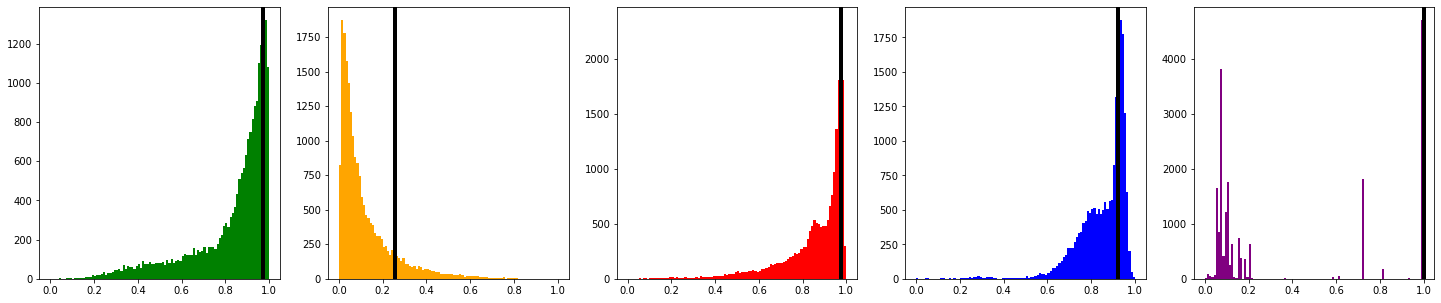

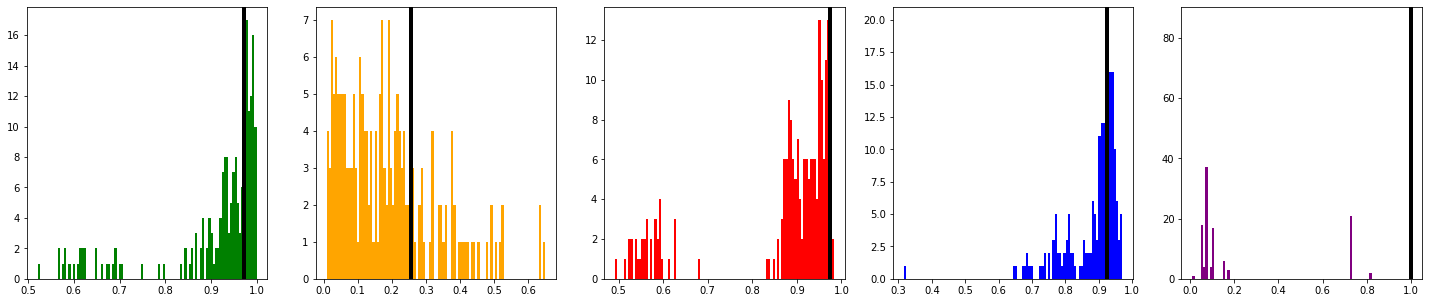

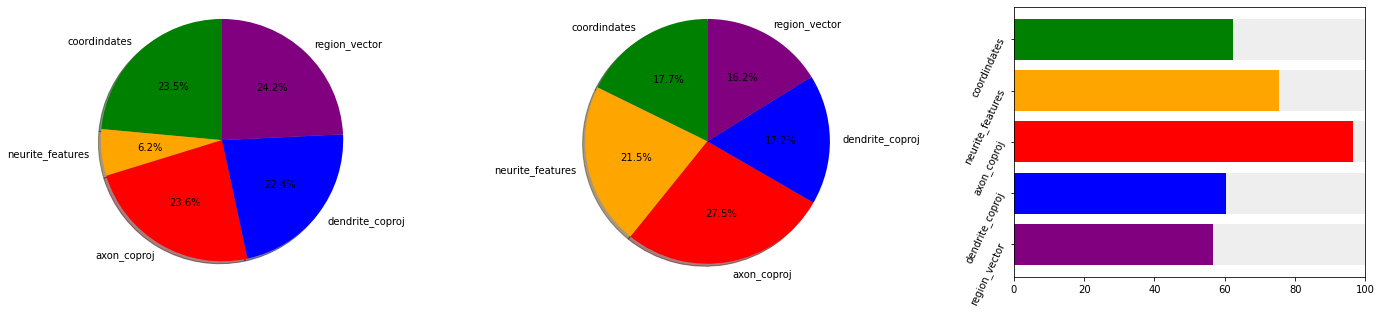

In [396]:
N = 20
for i, el in enumerate(score_table.sort_values(by="average", ascending=False).reset_index().to_dict("records")):

    percents = {}
    print("Morphology: ", el["point"],
          " score: {:.2f}".format(el["average"]),
          "normalized score: {:.2f}".format((el["average"] - min_avg) / (max_avg - min_avg)))
    for index_name in INDICES.keys():
        percents[index_name] = (sum(score_table[index_name] < el[index_name]) / score_table.shape[0]) * 100
        print("\t{}: {:.2f}, better than {:.2f}% of morphologies".format(
            index_name, el[index_name], percents[index_name]))

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
    ax1.hist(scaled_similarities["coordindates"], bins=100, color=COLORS["coordindates"])
    ax1.axvline(x=el["coordindates"], linewidth=4, c="black")

    ax2.hist(scaled_similarities["neurite_features"], bins=100, color=COLORS["neurite_features"])  
    ax2.axvline(x=el["neurite_features"], linewidth=4, c="black")

    ax3.hist(scaled_similarities["axon_coproj"], bins=100, color=COLORS["axon_coproj"]) 
    ax3.axvline(x=el["axon_coproj"], linewidth=4, c="black") 

    ax4.hist(scaled_similarities["dendrite_coproj"], bins=100, color=COLORS["dendrite_coproj"])  
    ax4.axvline(x=el["dendrite_coproj"], linewidth=4, c="black")

    ax5.hist(scaled_similarities["region_vector"], bins=100, color=COLORS["region_vector"])
    ax5.axvline(x=el["region_vector"], linewidth=4, c="black")
    plt.show()
        
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
    ax1.hist(score_table["coordindates"], bins=100, color=COLORS["coordindates"])
    ax1.axvline(x=el["coordindates"], linewidth=4, c="black")

    ax2.hist(score_table["neurite_features"], bins=100, color=COLORS["neurite_features"])  
    ax2.axvline(x=el["neurite_features"], linewidth=4, c="black")

    ax3.hist(score_table["axon_coproj"], bins=100, color=COLORS["axon_coproj"]) 
    ax3.axvline(x=el["axon_coproj"], linewidth=4, c="black") 

    ax4.hist(score_table["dendrite_coproj"], bins=100, color=COLORS["dendrite_coproj"])  
    ax4.axvline(x=el["dendrite_coproj"], linewidth=4, c="black")

    ax5.hist(score_table["region_vector"], bins=100, color=COLORS["region_vector"])
    ax5.axvline(x=el["region_vector"], linewidth=4, c="black")
    plt.show()
     
    keys = INDICES.keys()
    aspect_scores = np.array([
        el[k] for k in keys
    ])
    
    aspect_scores = aspect_scores / sum(aspect_scores)
        
    fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.pie(aspect_scores, labels=keys, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[COLORS[k] for k in keys])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    ax2.pie([percents[k] for k in keys], labels=keys, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[COLORS[k] for k in keys])
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    X = np.arange(len(keys))
    ax3.barh(X, [100 for k in keys], color = "#eee")
    ax3.barh(X, [percents[k] for k in keys], color = [COLORS[k] for k in keys])
    ax3.set_yticks(X)
    ax3.set_yticklabels(keys, rotation=65)
    plt.xlim([0, 100])
    ax3.invert_yaxis()
    fig1.tight_layout(pad=3.0)
    plt.show()


    if i == N - 1:
        break


## Adding density boosting

In [320]:
max_boosted_value

5.628339564099392

In [323]:
boosted_max_avg

0.7890290993367106

In [240]:
def plot_with_densities(vectors=None, labels=None,
                        title=None, silent=False, indices_to_mark=None,
                        marker_labels=None):
    """Plot a 2D representation of nodes."""
    if indices_to_mark is None:
        indices_to_mark = []
        
    if marker_labels is None:
        marker_labels = [str(el) for el in indices_to_mark]

    if vectors is None:
        raise ValueError(
            "Vectors to plot are not specified")

    unlabeled = False
    if labels is None:
        labels = [0] * vectors.shape[0]
        unlabeled = True

    # Generate color map
    unique_labels = set(labels)
    cm = plt.get_cmap('gist_rainbow')
    generated_colors = np.array([
        cm(1. * i / len(unique_labels))
        for i in range(len(unique_labels))
    ])
    np.random.shuffle(generated_colors)

    alpha = 1
    fig, ax = plt.subplots(figsize=(7, 7))

    # create a scatter per node label
    for i, l in enumerate(unique_labels):
        indices = np.where(np.array(labels) == l)
        ax.scatter(
            vectors[indices, 0],
            vectors[indices, 1],
            c=[generated_colors[i]] * indices[0].shape[0],
            cmap="jet",
            s=50,
            alpha=0.5,
            label=l if not unlabeled else None
        )
        
    if not unlabeled:
        ax.legend()
       
    # mark selected points
    offset = max(
        max(vectors[0]) - min(vectors[0]),
        max(vectors[1]) - min(vectors[1])) * 0.2

    if len(indices_to_mark) > 0:
        ax.scatter(
            vectors[indices_to_mark, 0],
            vectors[indices_to_mark, 1],
            c="black",
            s=150,
            marker="P",
            alpha=alpha,
            label=l if not unlabeled else None
        )
        for i, el in enumerate(indices_to_mark):
            ax.text(
                vectors[el, 0] + offset, vectors[el, 1] + offset, marker_labels[i])

    title = (
        title
        if title is not None
        else "2D visualization of the input node representation"
    )
    ax.set_title(title)
    if not silent:
        plt.show()

In [241]:
def get_gaussian_deviation(query, k, index_name):
    raw_scores, points = query_index(INDICES[index_name], [query], k)
    
    if SIMILARITIES[index_name] == "euclidean":
        scores = 1 / (1 + raw_scores[0][1:])
    else:
        scores = raw_scores[0][1:]
    
    scores = np.array([
        min_max_scale(el, index_name)
        for el in scores
    ])
    
    return math.sqrt(((1 - scores)**2).mean()), points[0]

In [261]:
def get_boost_factor(query, index_name, k):
    boost, _ = get_gaussian_deviation(query, k, index_name)
    return boost

In [262]:
boosts = {}
pairwise_similarities = {}
points = list(range(data.shape[0]))
boosted_similarities = defaultdict(list)
for index_name, index in INDICES.items():
    boosts[index_name] = {}
    pairwise_similarities[index_name] = {}
    for p1 in points:
        for p2 in points:
            if p1 < p2:
                d = compute_distance(index, p1, p2)
                if SIMILARITIES[index_name] == "euclidean":
                    d = 1 / (1 + d)
                pairwise_similarities[index_name][(p1, p2)] = d
                if p1 in boosts[index_name]:
                    factor1 = boosts[index_name][p1]
                else:
                    factor1 = get_boost_factor(p1, index_name, 20)
                    boosts[index_name][p1] = factor1
                if p2 in boosts[index_name]:
                    factor2 = boosts[index_name][p2]
                else:
                    factor2 = get_boost_factor(p2, index_name, 20)
                    boosts[index_name][p2] = factor2
                boosted_similarities[index_name].append((d, factor1, factor2))

In [589]:
# from scipy import stats
# import numpy as np

# X = np.array(list(boosts["dendrite_coproj"].values()))
# z = np.abs(stats.zscore(X))
# outlier = np.where(z > 3)[0][0]
# X[outlier] = sorted(X)[-2]

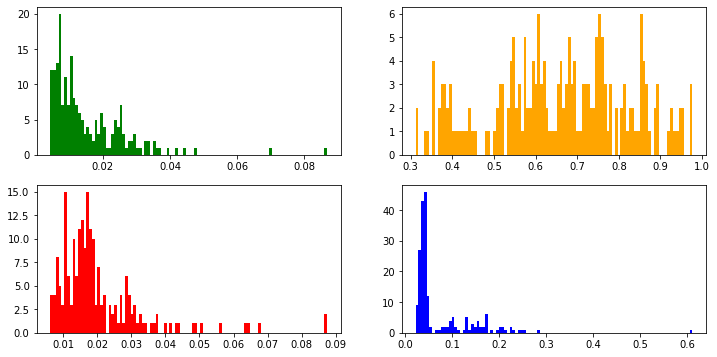

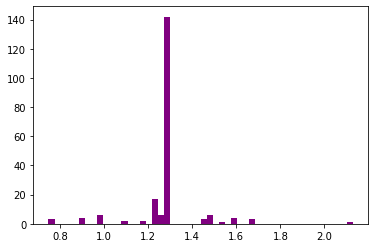

In [266]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))

ax1.hist(boosts["coordindates"].values(), color=COLORS["coordindates"], bins=100)
ax2.hist(boosts["neurite_features"].values(), color=COLORS["neurite_features"], bins=100)
ax3.hist(boosts["axon_coproj"].values(), color=COLORS["axon_coproj"], bins=100)
ax4.hist(boosts["dendrite_coproj"].values(), color=COLORS["dendrite_coproj"], bins=100)
plt.show()
plt.hist(boosts["region_vector"].values(), color=COLORS["region_vector"], bins=50)
plt.show()

coordindates
	Max similarity value 1.0824716463881763


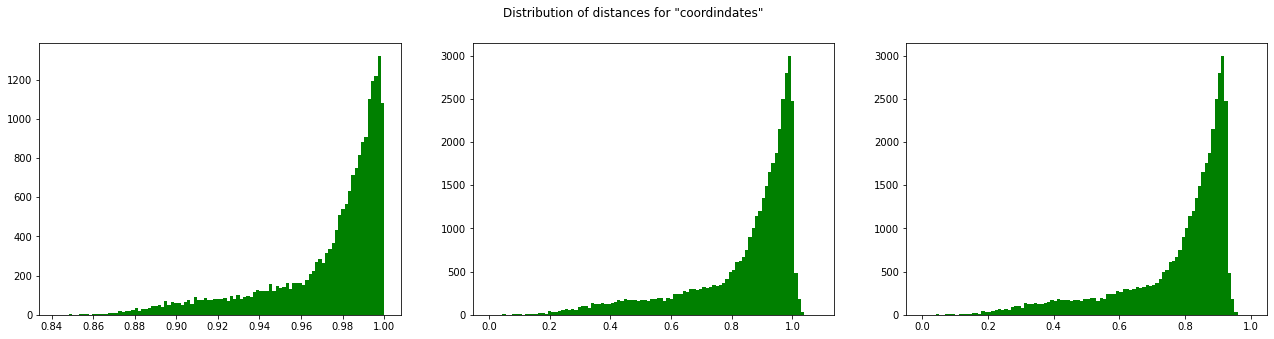

neurite_features
	Max similarity value 1.6687950021094453


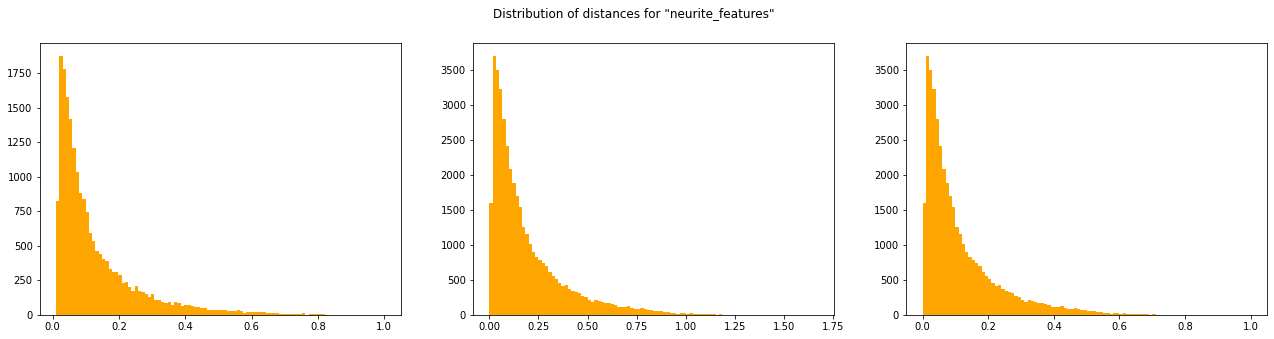

axon_coproj
	Max similarity value 1.045506947815507


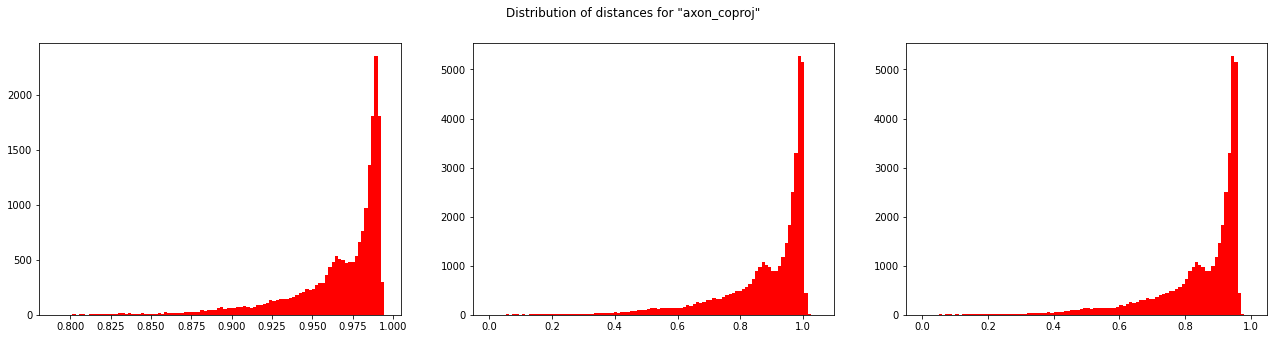

dendrite_coproj
	Max similarity value 1.0452516460904442


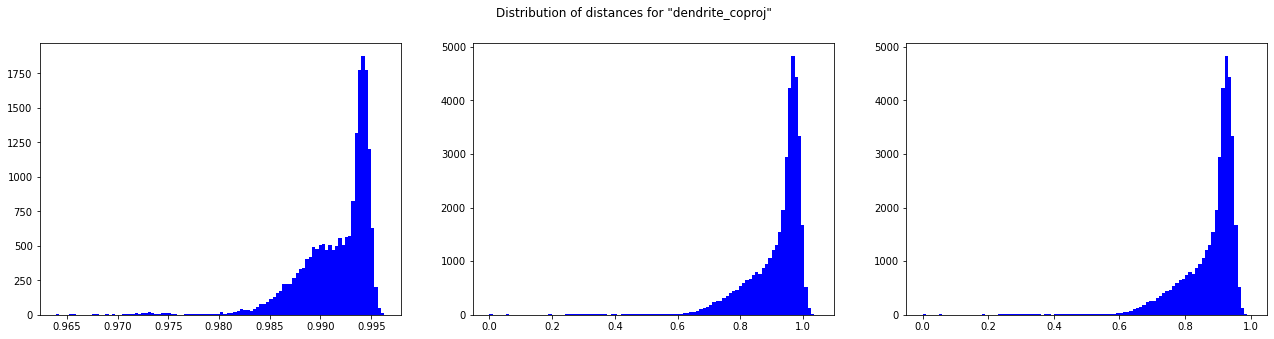

region_vector
	Max similarity value 3.1286177301567313


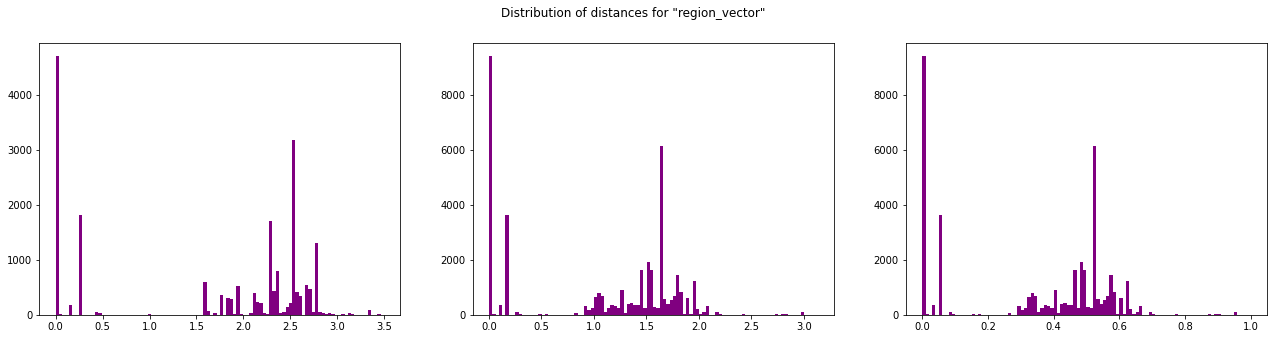

In [299]:
BOOSTED_SCALERS = {}
boosted_scaled_similarities = {}
for k in boosted_similarities:
    print(k)
    raw_values = np.array([score for score, _, _ in boosted_similarities[k]])
    scaled_values = SCALERS[k].fit_transform(np.reshape(raw_values, (-1, 1))).T[0]
    
    boost_factor_1 = np.array(
        [factor for _, factor, _ in boosted_similarities[k]])
    boost_factor_2 = np.array(
        [factor for _, _, factor in boosted_similarities[k]])
    sim_values1 = scaled_values * (1 + boost_factor_1)
    sim_values2 = scaled_values * (1 + boost_factor_2)
    
    sim_values = np.hstack([sim_values1, sim_values2])
    print("\tMax similarity value", max(sim_values))

    scaler = sk.preprocessing.MinMaxScaler()
    scaled_values = scaler.fit_transform(np.reshape(sim_values, (-1, 1)))
    BOOSTED_SCALERS[k] = scaler
    boosted_scaled_similarities[k] = scaled_values

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))
    fig.suptitle(f'Distribution of distances for "{k}"')
    ax1.hist(raw_values, bins=100, color=COLORS[k])
    ax2.hist(sim_values, bins=100, color=COLORS[k])
    ax3.hist(scaled_values, bins=100, color=COLORS[k])
    plt.show()

In [300]:
def min_max_scale(x, index_name):
    return BOOSTED_SCALERS[index_name].transform(np.atleast_2d(x))[0][0]

In [315]:
boosted_score_table = pd.DataFrame(columns=["point"])
for index_name, index in INDICES.items():
    boost = get_boost_factor(0, index_name, 20)

    scores, points = query_index(index, [0], 200)
    if SIMILARITIES[index_name] == "cosine":
        scores = scores[0][1:]
    else:
        scores = 1 / (1 + scores[0][1:])
    scores = SCALERS[index_name].transform(np.atleast_2d(scores).T).T[0]
    scores = (1 + boost) * scores
    
    scores = BOOSTED_SCALERS[index_name].transform(np.atleast_2d(scores).T).T[0]

    boosted_score_table = boosted_score_table.merge(
        pd.DataFrame(zip(points[0][1:], scores), columns=["point", index_name]),
        on="point", how="right")

boosted_score_table = boosted_score_table.set_index("point")
boosted_score_table["average"] = boosted_score_table.apply(lambda x: sum(x.tolist()) / len(x.tolist()), axis=1)

In [316]:
boosted_score_table.sort_values(by="average", ascending=False)

,coordindates,neurite_features,axon_coproj,dendrite_coproj,region_vector,average
point,,,,,,
153,0.973980,0.650678,0.977180,0.906659,0.143410,0.730382
117,0.962289,0.665684,0.956908,0.894315,0.143410,0.724521
151,0.949403,0.505980,0.968988,0.934980,0.182660,0.708402
174,0.965392,0.411674,0.980591,0.967503,0.182660,0.701564
29,0.978267,0.501537,0.924006,0.905296,0.182660,0.698353
...,...,...,...,...,...,...
80,0.924309,0.119910,0.560376,0.738378,0.051751,0.478945
78,0.925153,0.111788,0.529546,0.771391,0.051751,0.477926
51,0.671658,0.041207,0.894025,0.688611,0.049012,0.468902


In [311]:
boosting_factors = {
    index_name: {
        p: get_boost_factor(p, index_name, 20)
        for p in points
    }
    for index_name in INDICES
}

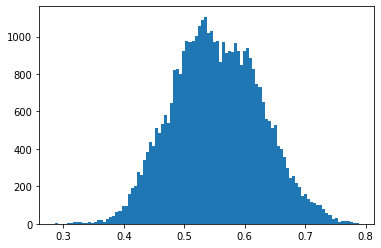

In [312]:
points = list(range(data.shape[0]))
boosted_averaged_similarities = set()
for p1 in points:
    for p2 in points:
        if p1 < p2:
            values1 = []
            values2 = []
            for index_name, index in INDICES.items():
                p1_boost = boosting_factors[index_name][p1]
                p2_boost = boosting_factors[index_name][p2]
                score = compute_distance(index, p1, p2)
                if SIMILARITIES[index_name] != "cosine":
                    score = 1 / (1 + score)
                score = SCALERS[index_name].transform(np.atleast_2d(score).T).T[0][0]
                
                value1 = BOOSTED_SCALERS[index_name].transform(
                    np.atleast_2d((1 + p1_boost) * score).T).T[0][0]
                value2 = BOOSTED_SCALERS[index_name].transform(
                    np.atleast_2d((1 + p2_boost) * score).T).T[0][0]
                
                values1.append(value1)
                values2.append(value2)
                
            boosted_averaged_similarities.add(np.array(values1).mean())
            boosted_averaged_similarities.add(np.array(values2).mean())
            
plt.hist(boosted_averaged_similarities, bins=100)
plt.show()

boosted_min_avg = min(boosted_averaged_similarities)
boosted_max_avg = max(boosted_averaged_similarities)

In [324]:
boosted_max_avg

0.7890290993367106

Morphology:  153  score: 0.73  normalized score: 0.88
	coordindates: 0.97, better than 71.86% of morphologies
	neurite_features: 0.65, better than 97.99% of morphologies
	axon_coproj: 0.98, better than 89.45% of morphologies
	dendrite_coproj: 0.91, better than 38.19% of morphologies
	region_vector: 0.14, better than 45.23% of morphologies


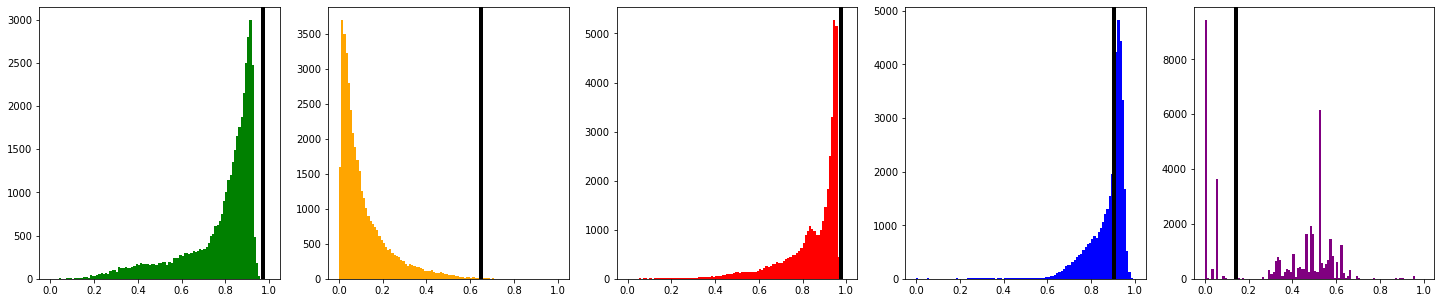

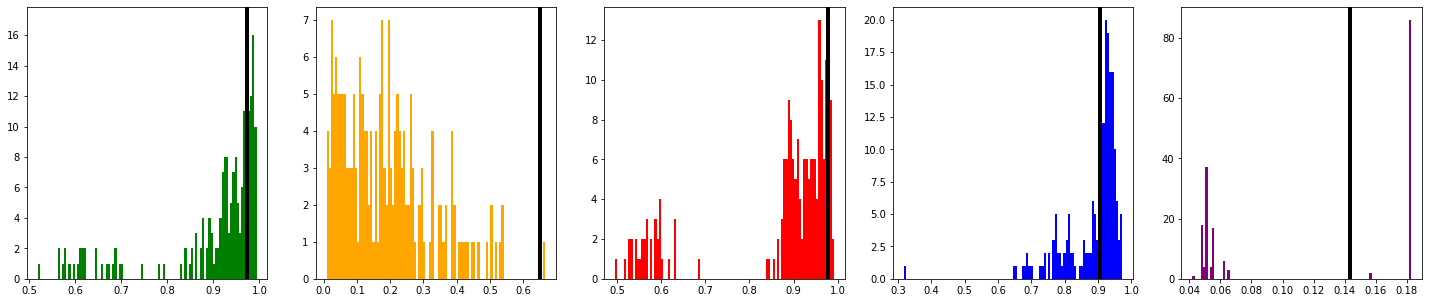

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


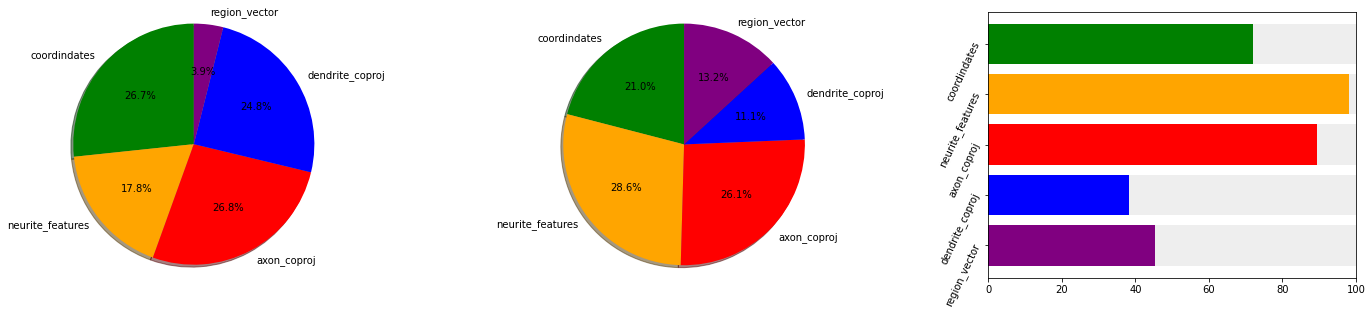

Morphology:  117  score: 0.72  normalized score: 0.87
	coordindates: 0.96, better than 58.29% of morphologies
	neurite_features: 0.67, better than 98.99% of morphologies
	axon_coproj: 0.96, better than 68.34% of morphologies
	dendrite_coproj: 0.89, better than 32.16% of morphologies
	region_vector: 0.14, better than 45.23% of morphologies


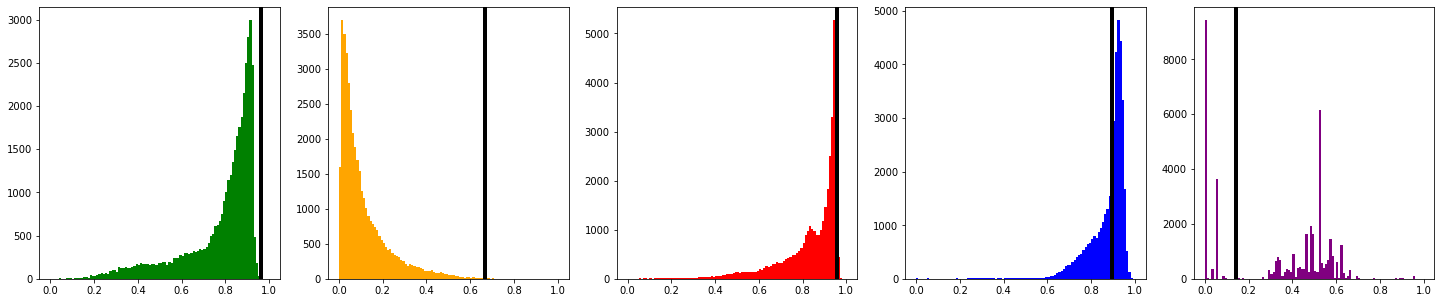

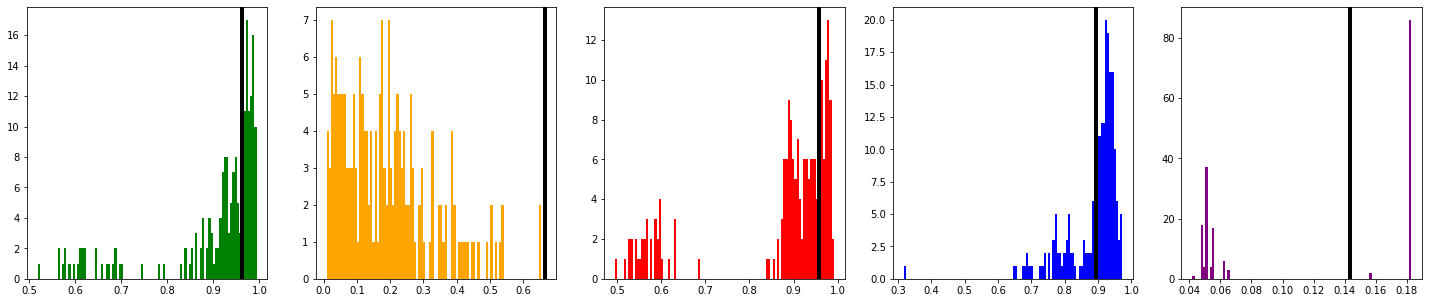

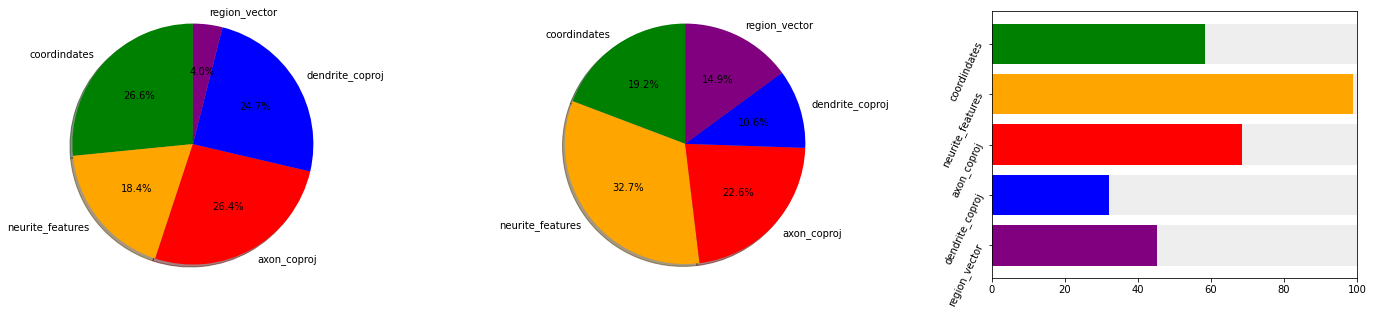

Morphology:  151  score: 0.71  normalized score: 0.84
	coordindates: 0.95, better than 51.26% of morphologies
	neurite_features: 0.51, better than 95.48% of morphologies
	axon_coproj: 0.97, better than 80.90% of morphologies
	dendrite_coproj: 0.93, better than 72.86% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


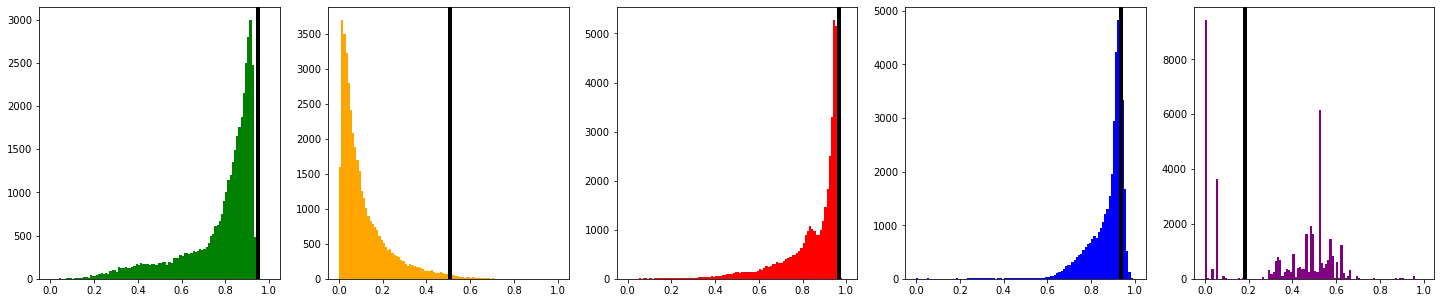

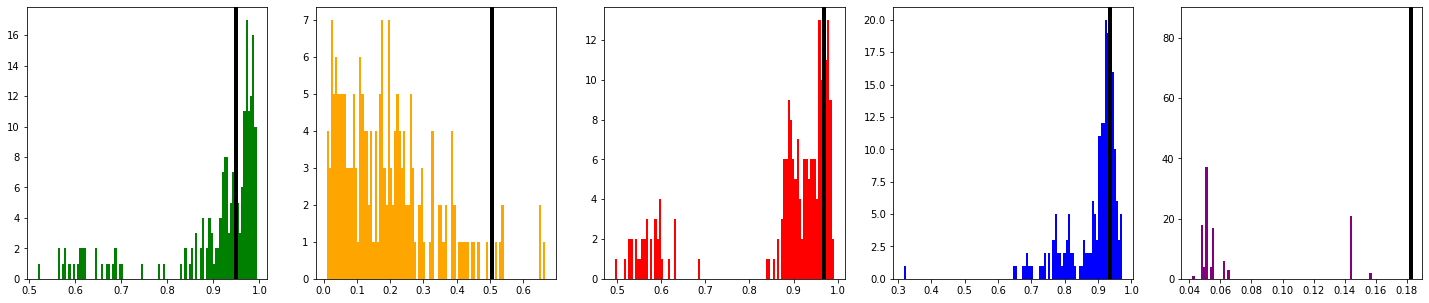

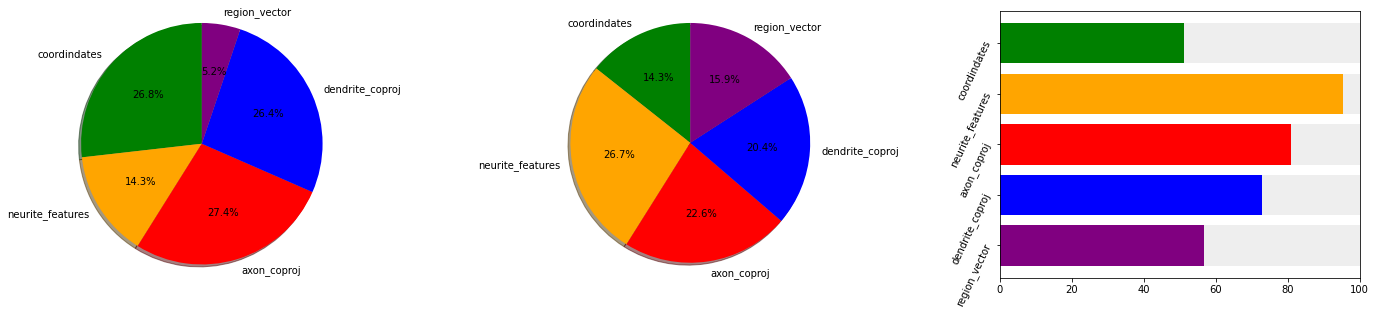

Morphology:  174  score: 0.70  normalized score: 0.83
	coordindates: 0.97, better than 61.31% of morphologies
	neurite_features: 0.41, better than 90.95% of morphologies
	axon_coproj: 0.98, better than 93.47% of morphologies
	dendrite_coproj: 0.97, better than 97.49% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


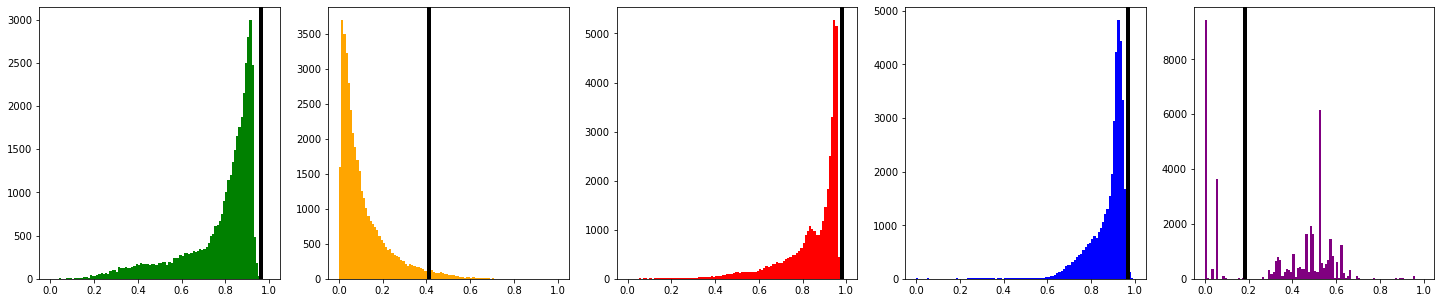

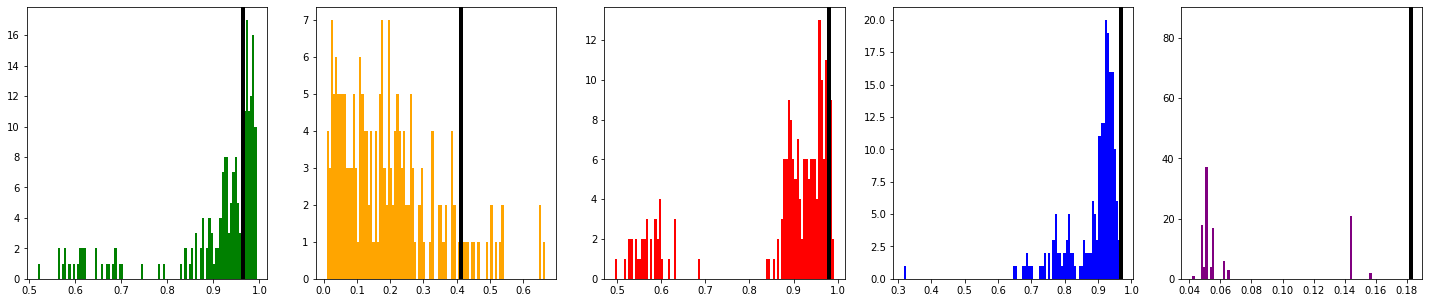

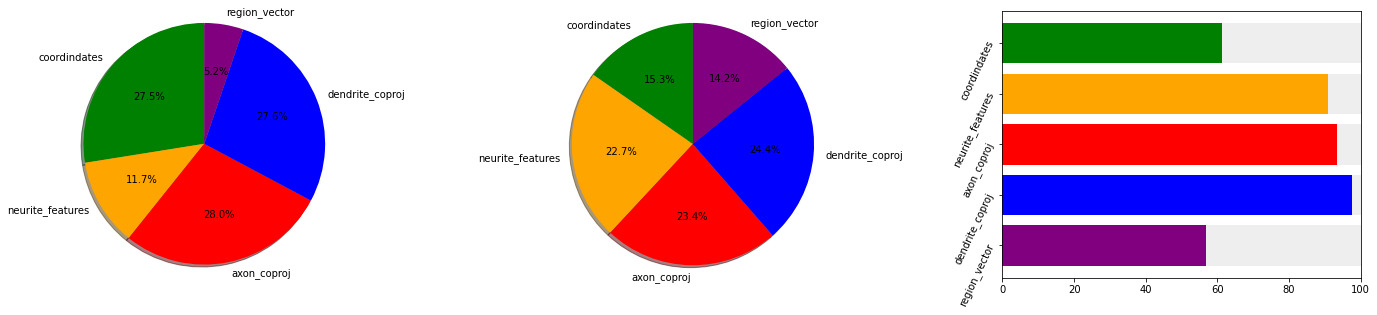

Morphology:  29  score: 0.70  normalized score: 0.82
	coordindates: 0.98, better than 78.39% of morphologies
	neurite_features: 0.50, better than 94.97% of morphologies
	axon_coproj: 0.92, better than 48.74% of morphologies
	dendrite_coproj: 0.91, better than 36.68% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


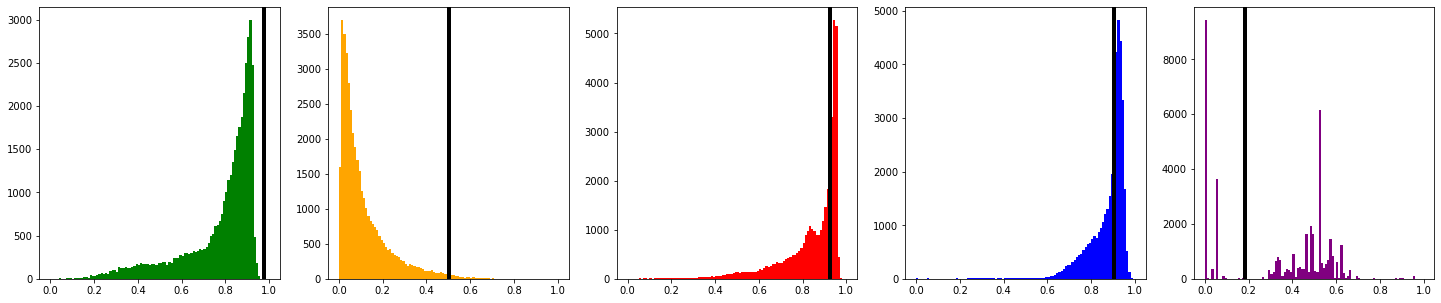

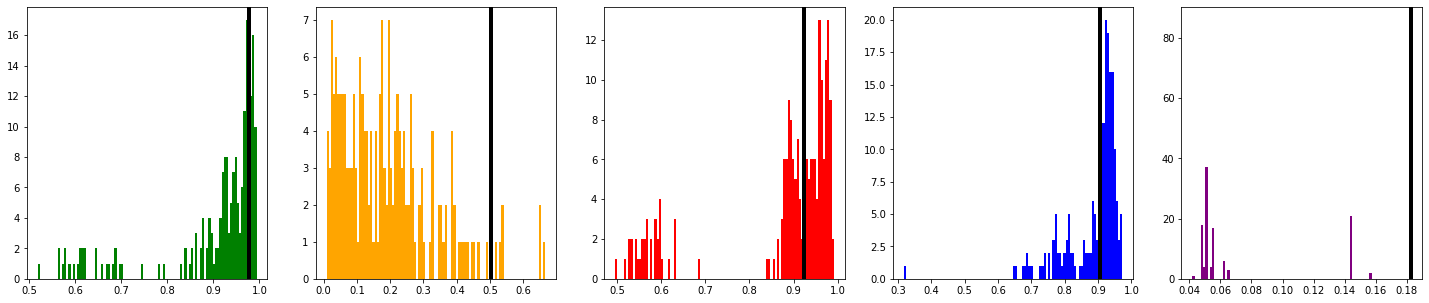

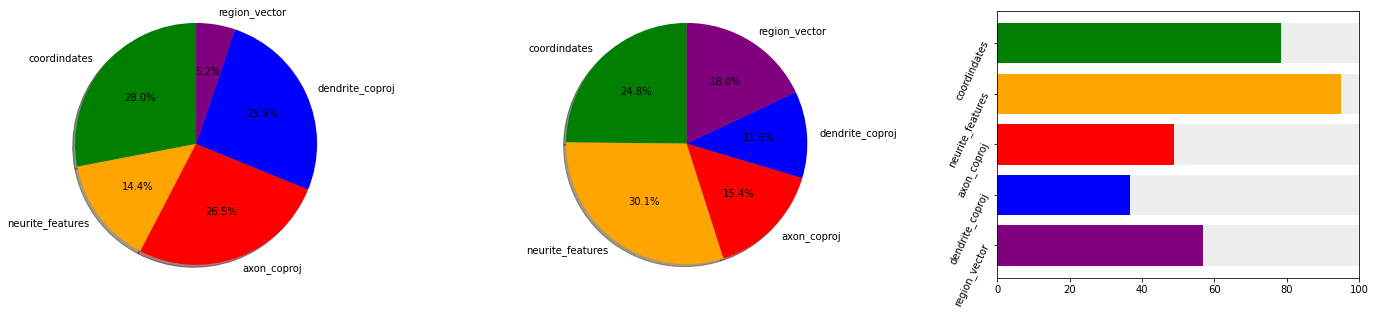

Morphology:  91  score: 0.69  normalized score: 0.81
	coordindates: 0.92, better than 29.65% of morphologies
	neurite_features: 0.65, better than 98.49% of morphologies
	axon_coproj: 0.90, better than 39.20% of morphologies
	dendrite_coproj: 0.95, better than 87.44% of morphologies
	region_vector: 0.06, better than 32.16% of morphologies


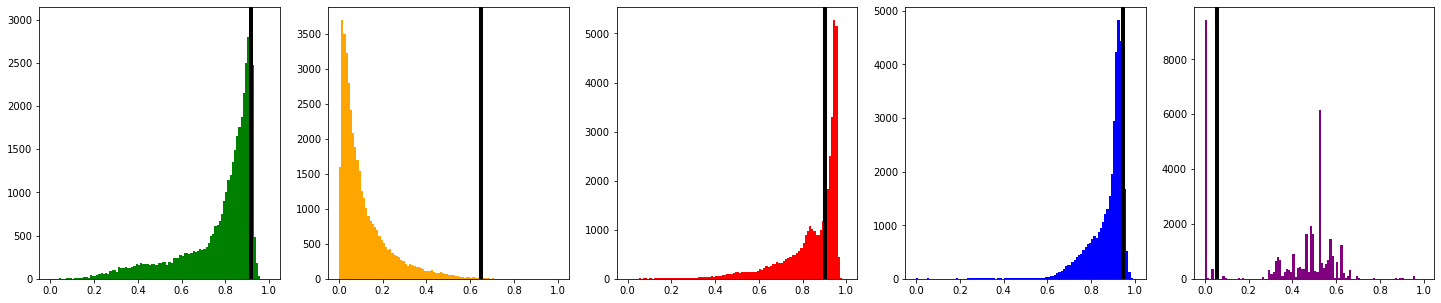

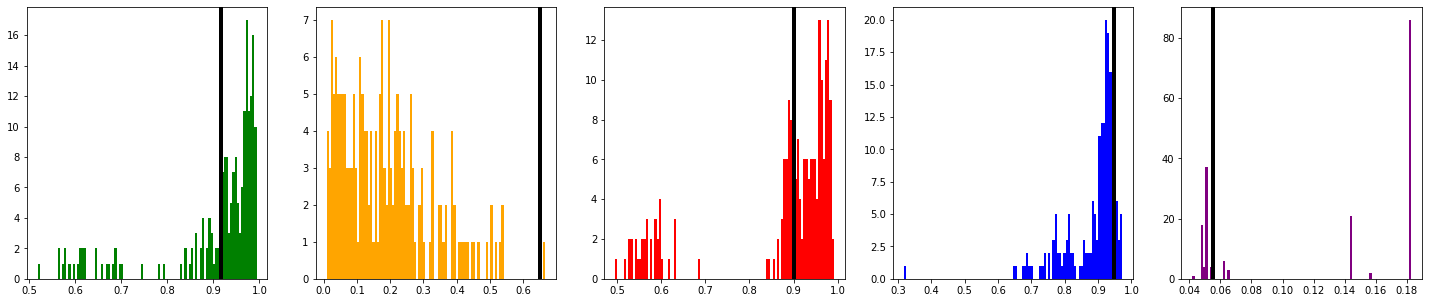

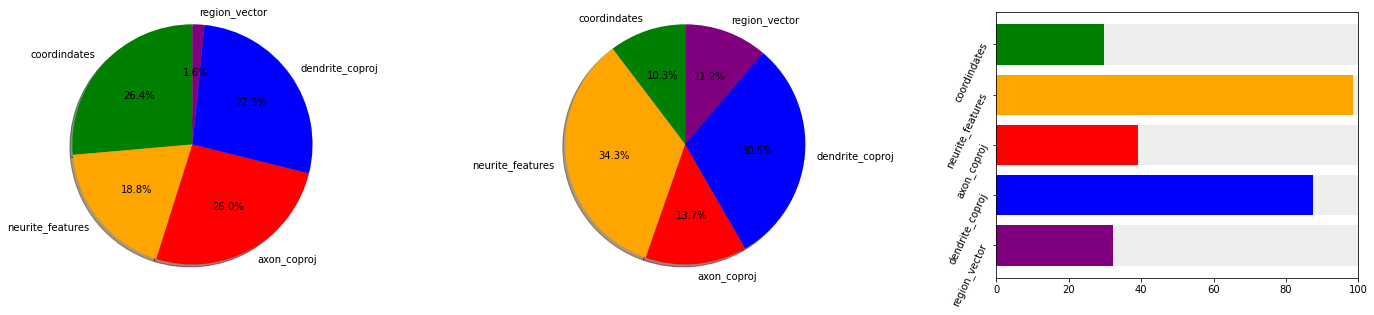

Morphology:  188  score: 0.69  normalized score: 0.81
	coordindates: 0.98, better than 82.91% of morphologies
	neurite_features: 0.41, better than 90.45% of morphologies
	axon_coproj: 0.96, better than 74.37% of morphologies
	dendrite_coproj: 0.93, better than 69.85% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


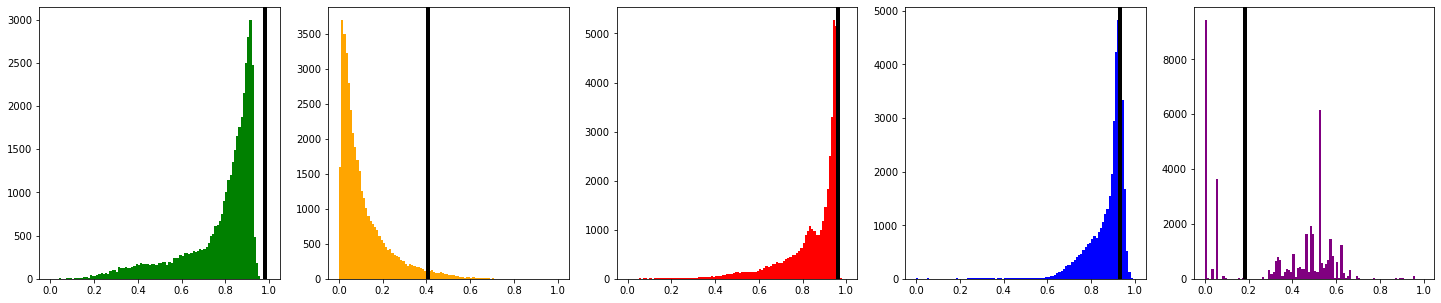

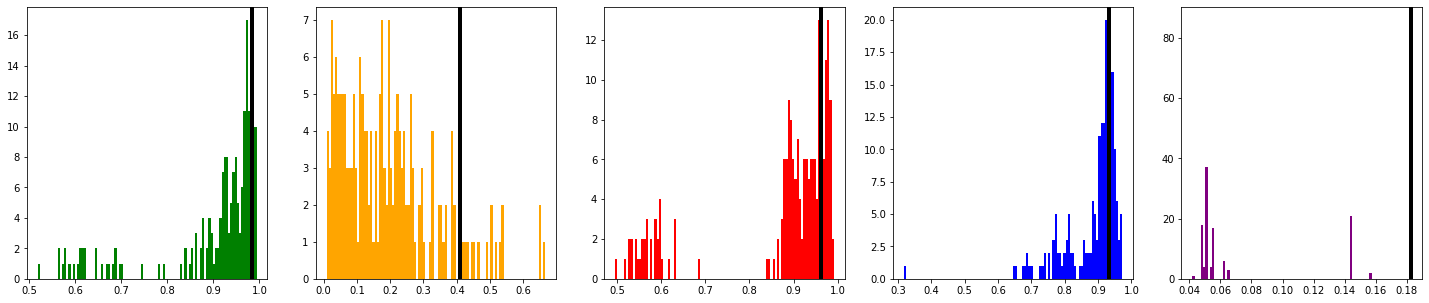

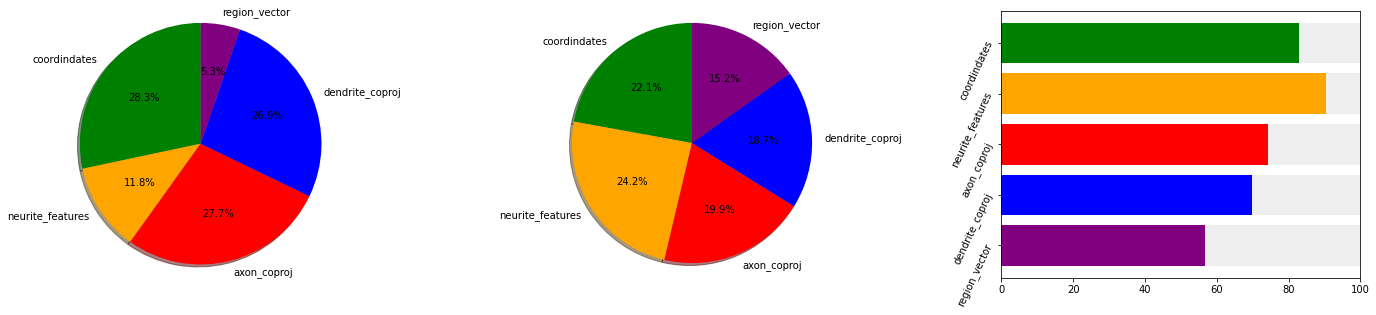

Morphology:  26  score: 0.69  normalized score: 0.80
	coordindates: 0.97, better than 68.84% of morphologies
	neurite_features: 0.39, better than 87.94% of morphologies
	axon_coproj: 0.98, better than 97.99% of morphologies
	dendrite_coproj: 0.91, better than 42.21% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


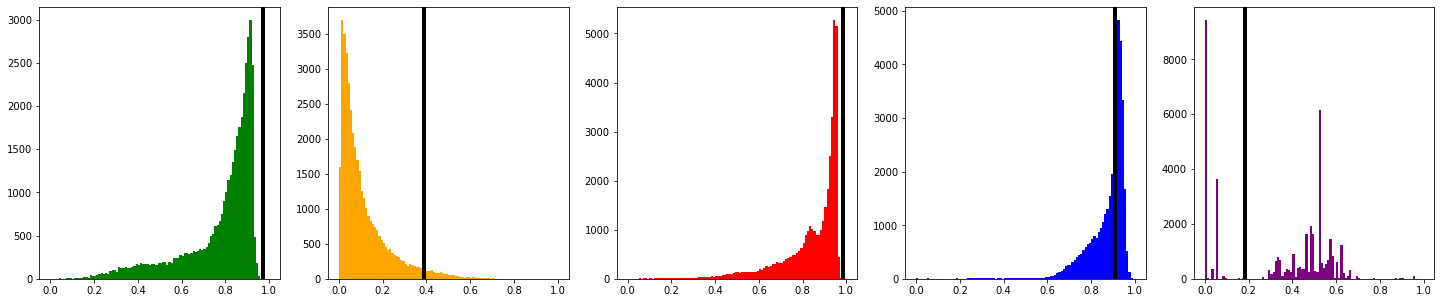

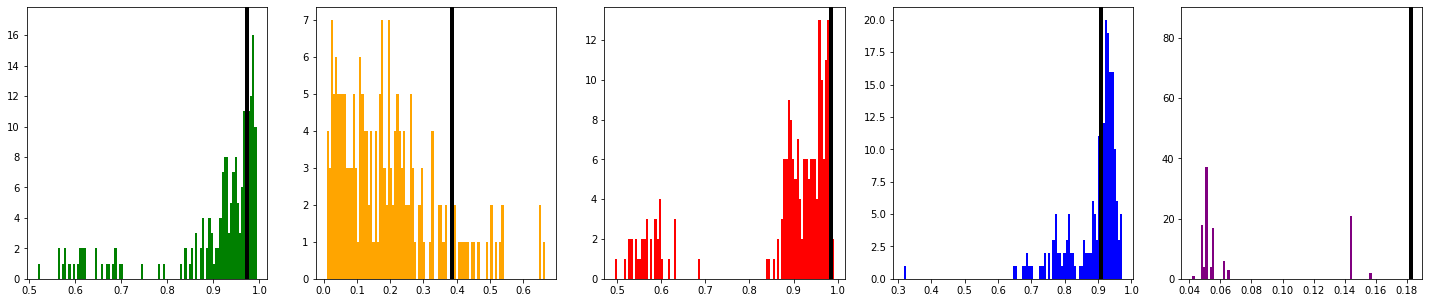

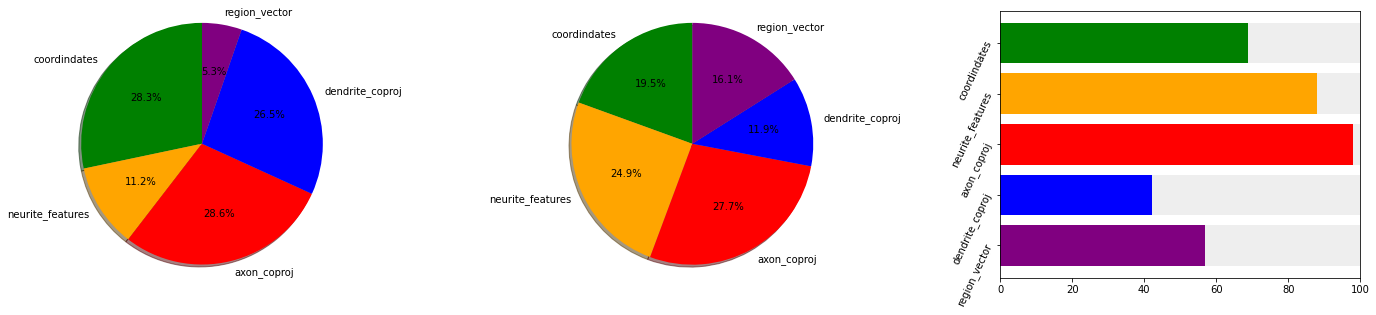

Morphology:  125  score: 0.69  normalized score: 0.80
	coordindates: 0.88, better than 20.10% of morphologies
	neurite_features: 0.54, better than 97.49% of morphologies
	axon_coproj: 0.91, better than 41.21% of morphologies
	dendrite_coproj: 0.97, better than 95.98% of morphologies
	region_vector: 0.14, better than 45.23% of morphologies


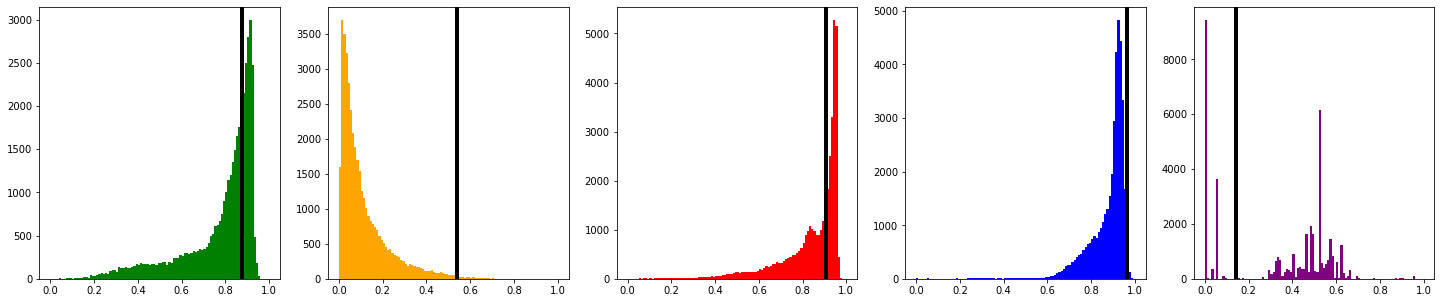

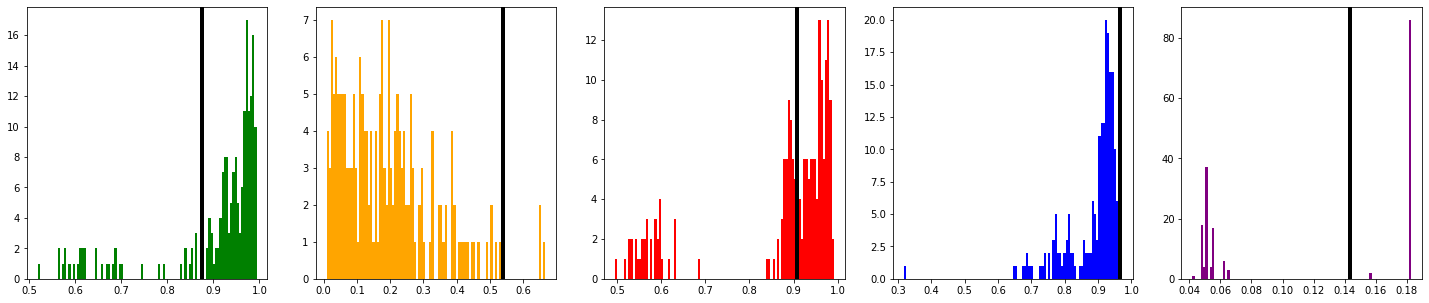

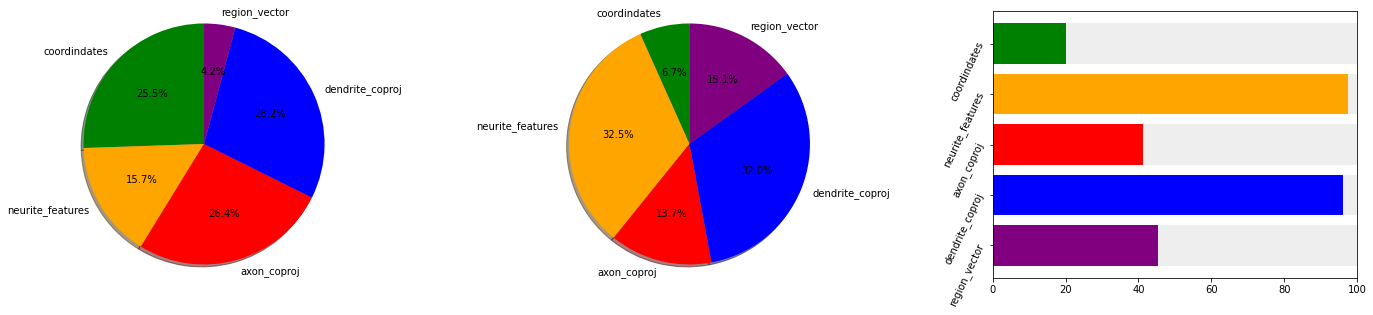

Morphology:  27  score: 0.69  normalized score: 0.79
	coordindates: 0.97, better than 66.33% of morphologies
	neurite_features: 0.39, better than 89.95% of morphologies
	axon_coproj: 0.92, better than 46.73% of morphologies
	dendrite_coproj: 0.96, better than 95.48% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


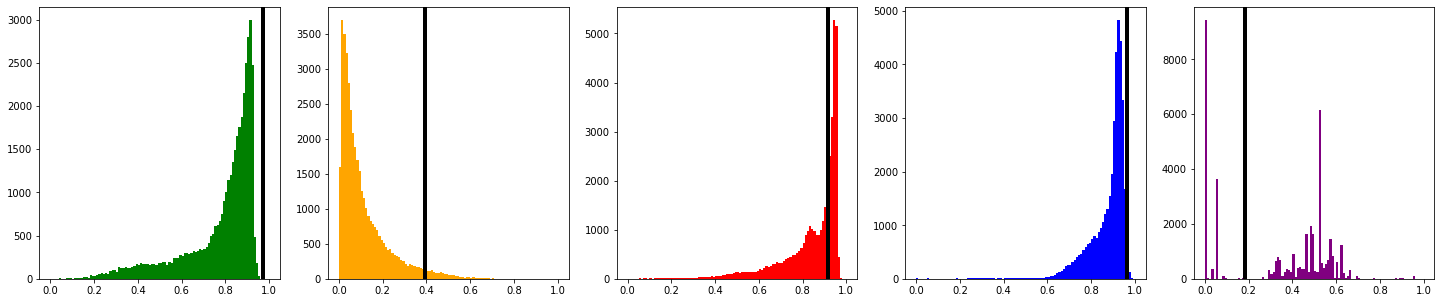

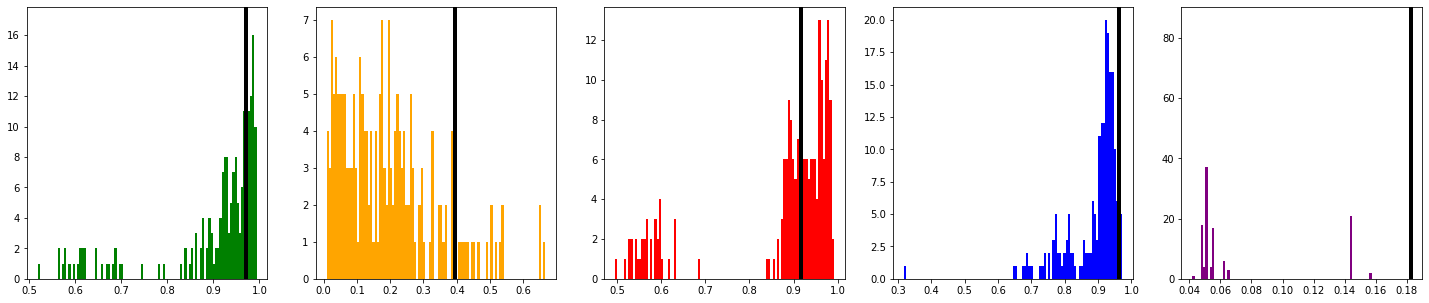

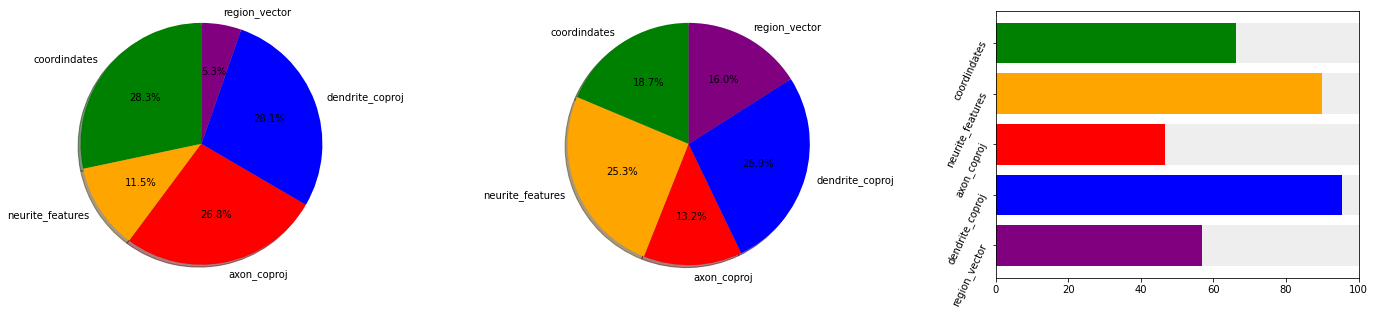

Morphology:  179  score: 0.68  normalized score: 0.79
	coordindates: 0.98, better than 85.93% of morphologies
	neurite_features: 0.33, better than 82.91% of morphologies
	axon_coproj: 0.97, better than 79.40% of morphologies
	dendrite_coproj: 0.96, better than 93.47% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


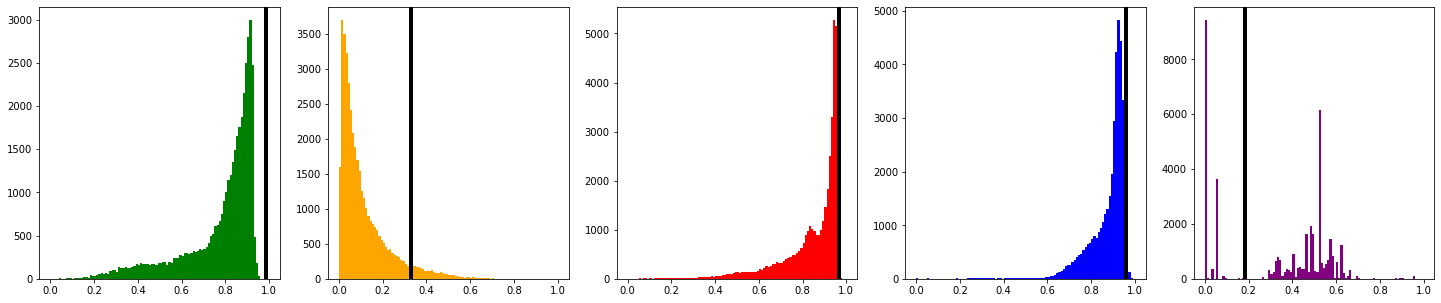

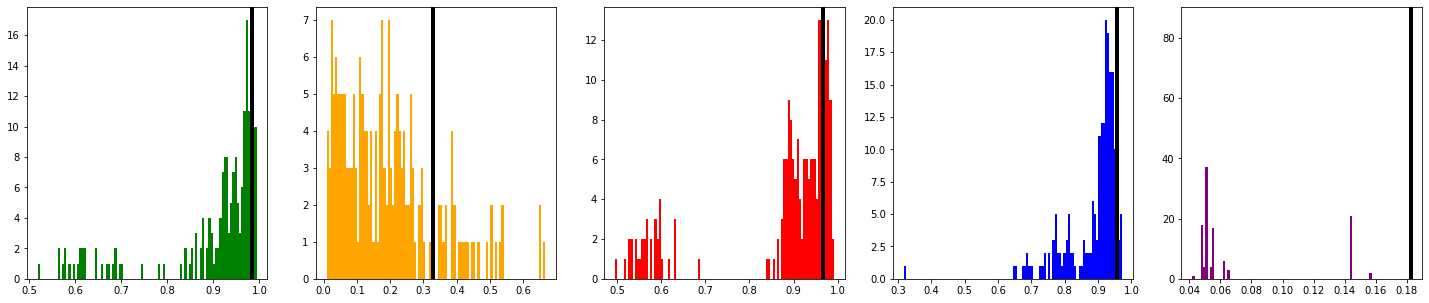

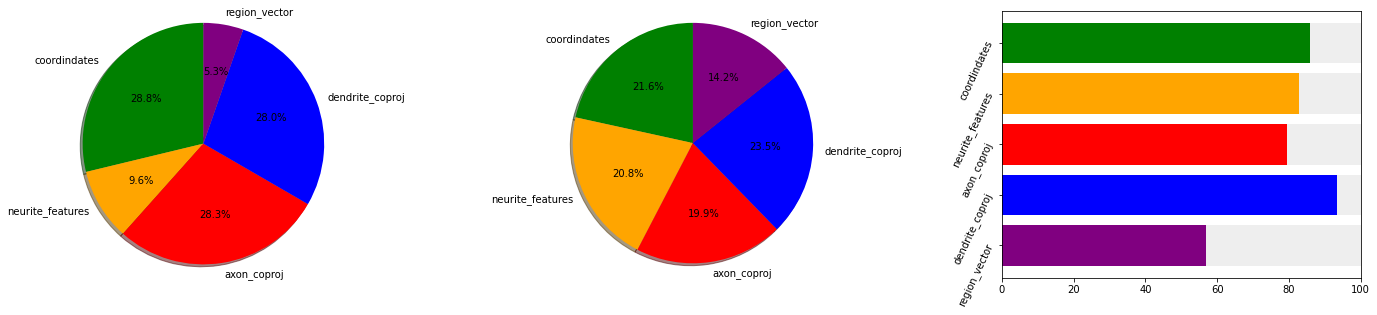

Morphology:  171  score: 0.68  normalized score: 0.79
	coordindates: 0.99, better than 94.47% of morphologies
	neurite_features: 0.43, better than 91.96% of morphologies
	axon_coproj: 0.91, better than 42.71% of morphologies
	dendrite_coproj: 0.91, better than 40.70% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


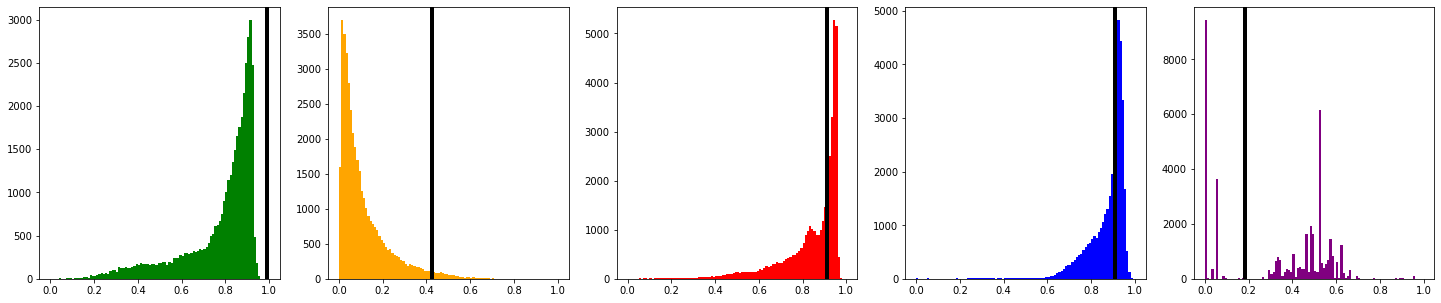

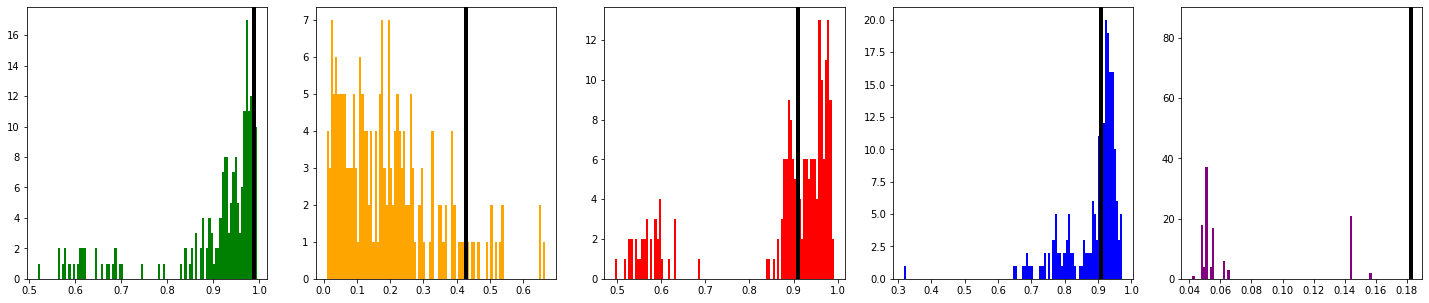

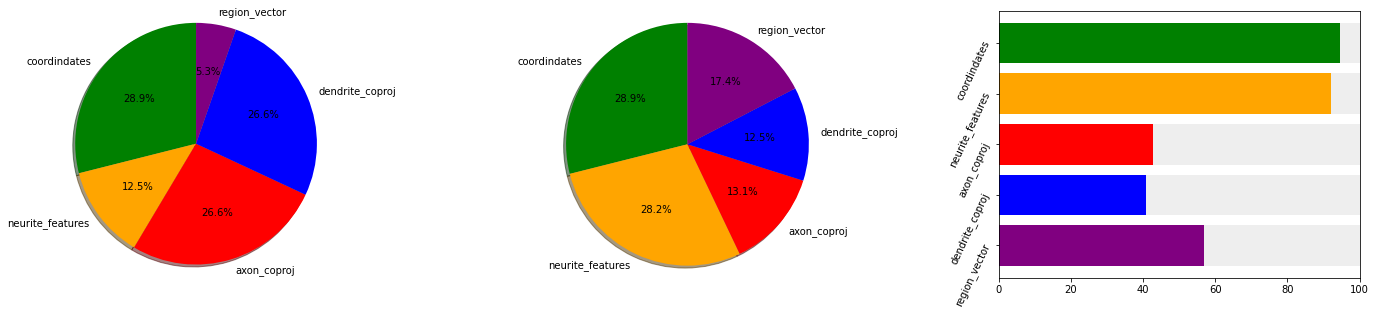

Morphology:  165  score: 0.68  normalized score: 0.79
	coordindates: 0.97, better than 64.32% of morphologies
	neurite_features: 0.37, better than 86.43% of morphologies
	axon_coproj: 0.94, better than 60.80% of morphologies
	dendrite_coproj: 0.95, better than 88.44% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


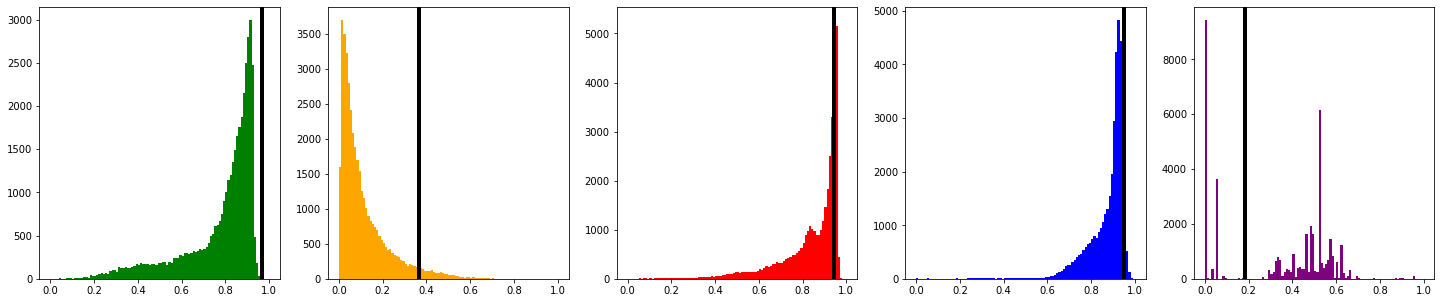

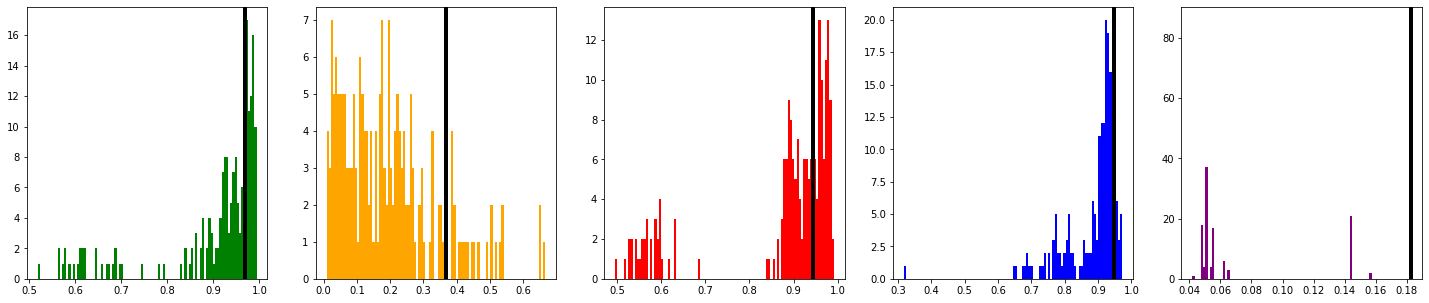

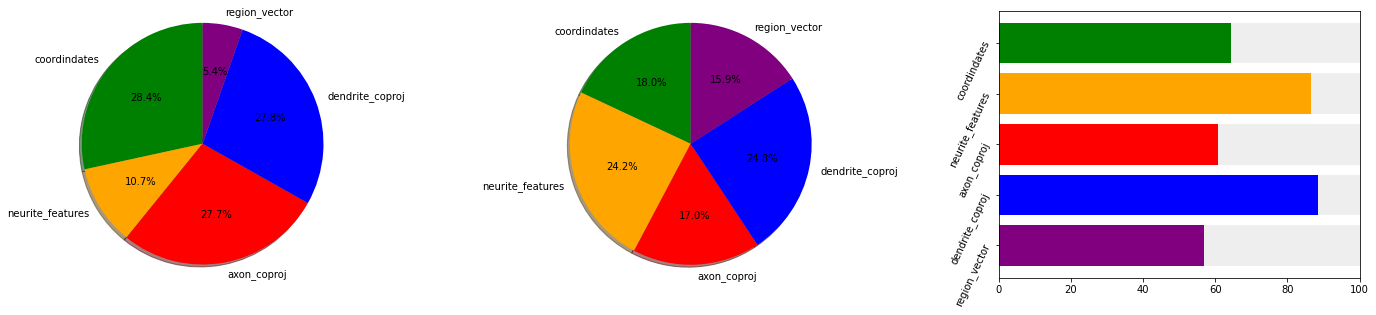

Morphology:  189  score: 0.68  normalized score: 0.78
	coordindates: 0.99, better than 91.96% of morphologies
	neurite_features: 0.33, better than 81.91% of morphologies
	axon_coproj: 0.97, better than 85.43% of morphologies
	dendrite_coproj: 0.91, better than 41.21% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


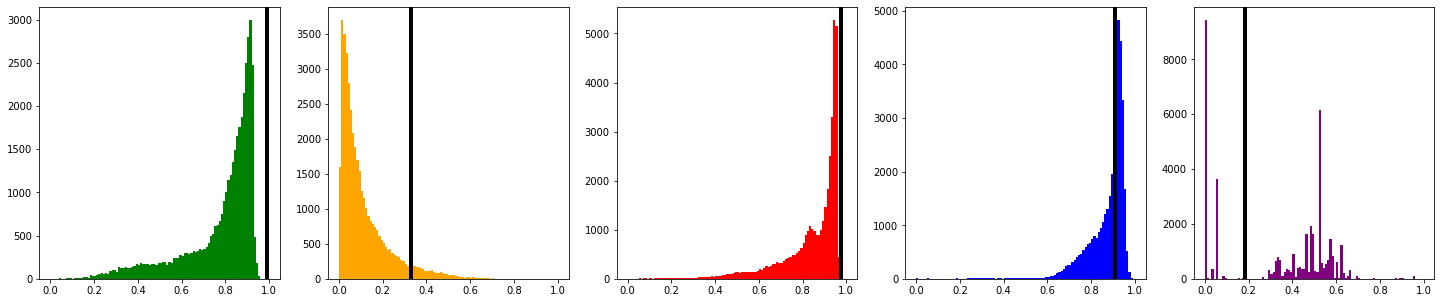

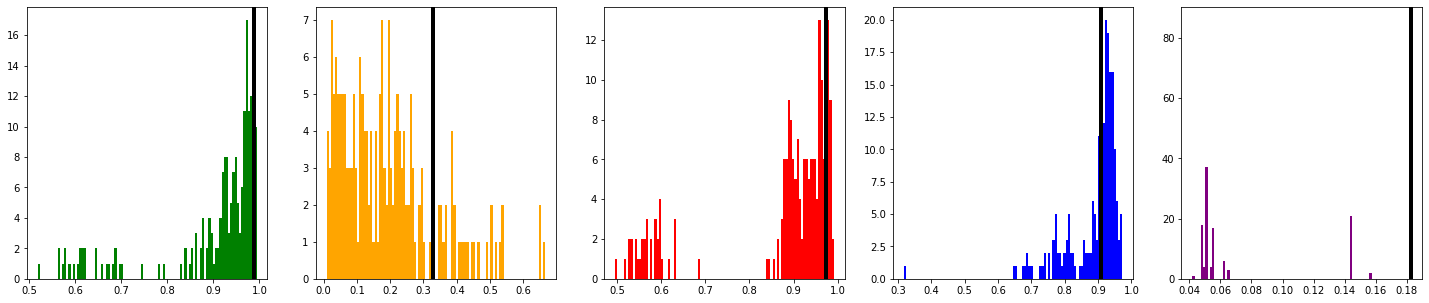

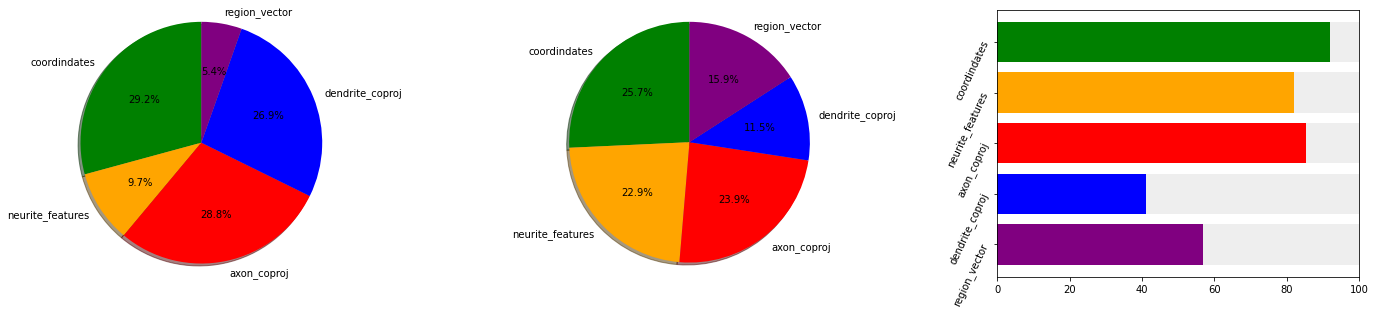

Morphology:  172  score: 0.67  normalized score: 0.77
	coordindates: 0.96, better than 58.79% of morphologies
	neurite_features: 0.36, better than 85.43% of morphologies
	axon_coproj: 0.95, better than 64.32% of morphologies
	dendrite_coproj: 0.92, better than 49.75% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


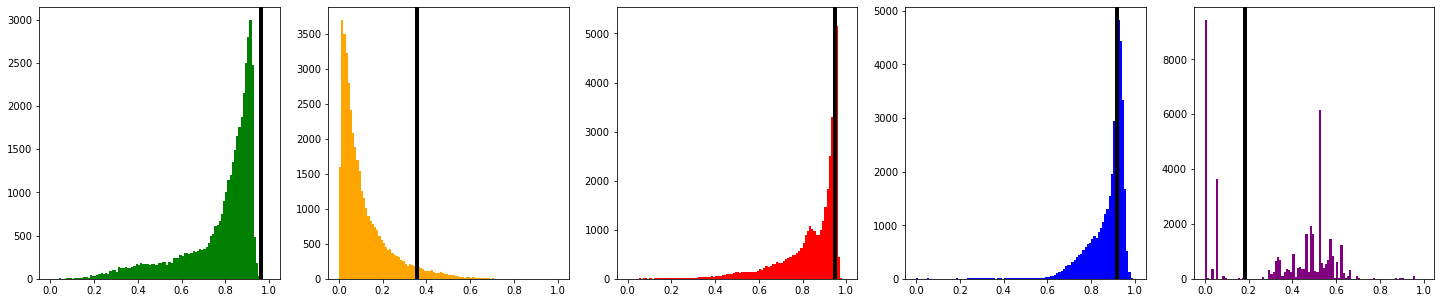

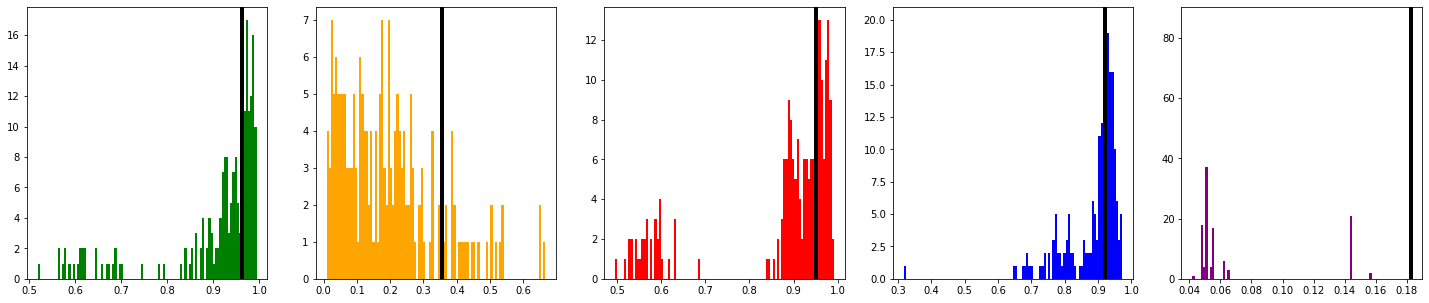

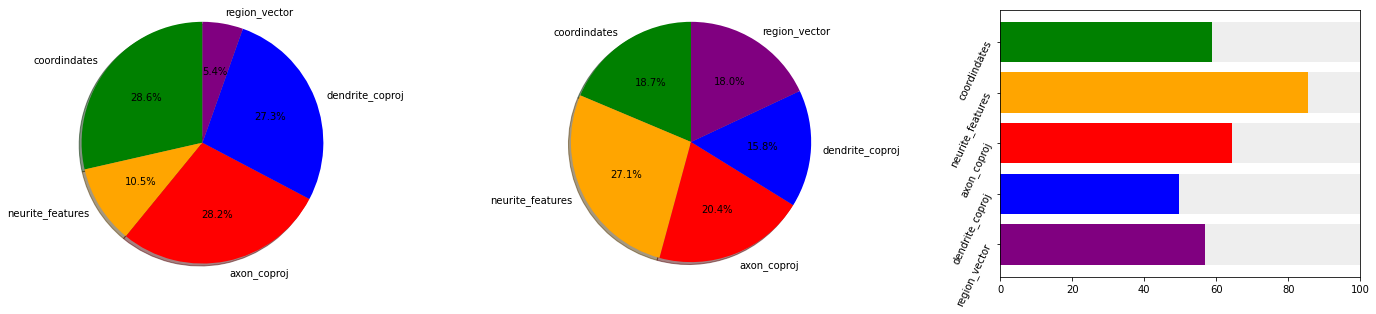

Morphology:  12  score: 0.67  normalized score: 0.76
	coordindates: 0.99, better than 97.99% of morphologies
	neurite_features: 0.24, better than 70.35% of morphologies
	axon_coproj: 0.98, better than 97.49% of morphologies
	dendrite_coproj: 0.94, better than 83.92% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


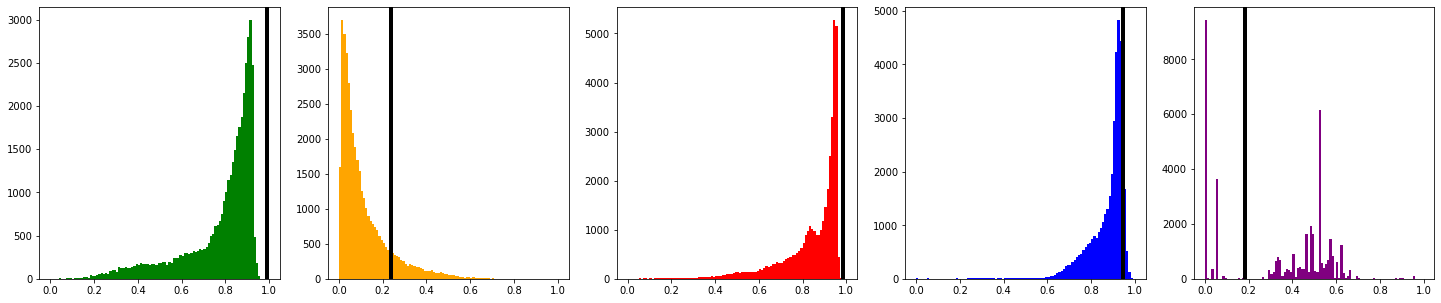

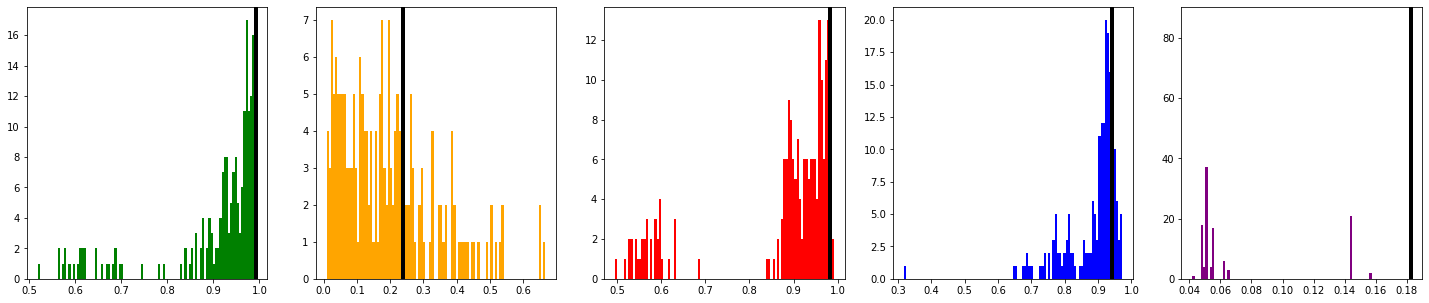

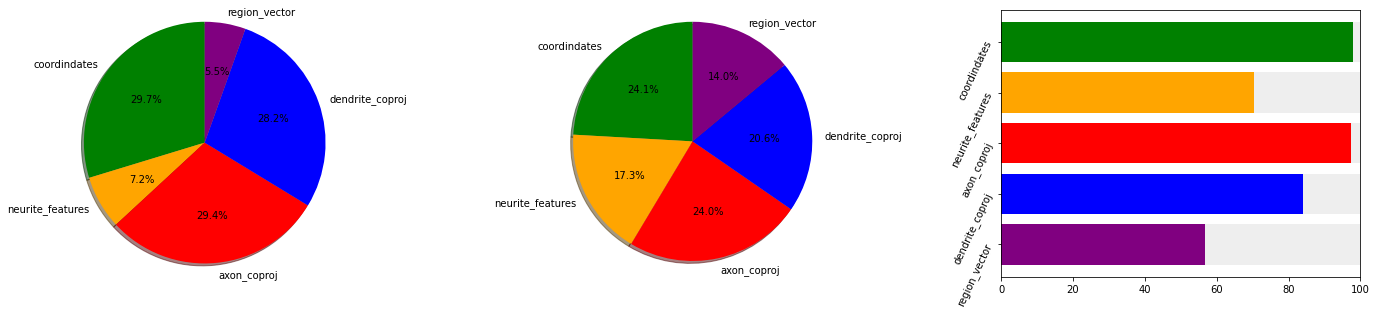

Morphology:  186  score: 0.67  normalized score: 0.76
	coordindates: 0.99, better than 88.94% of morphologies
	neurite_features: 0.29, better than 78.89% of morphologies
	axon_coproj: 0.97, better than 79.90% of morphologies
	dendrite_coproj: 0.91, better than 44.72% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


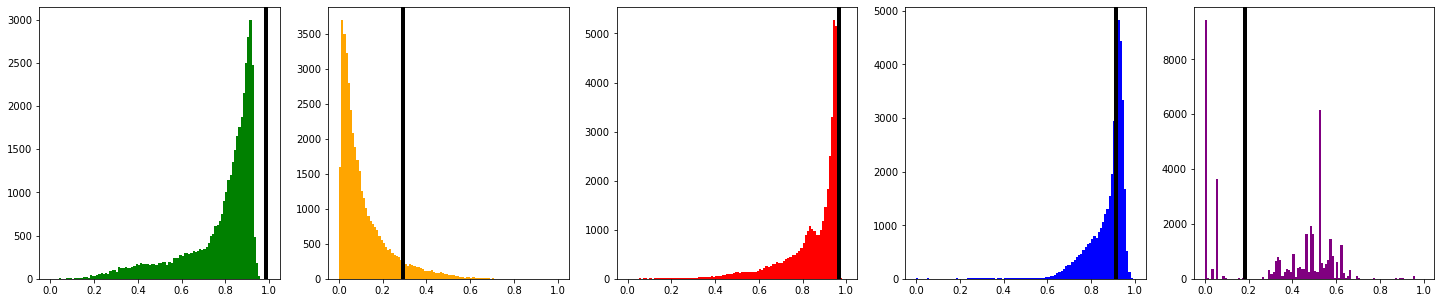

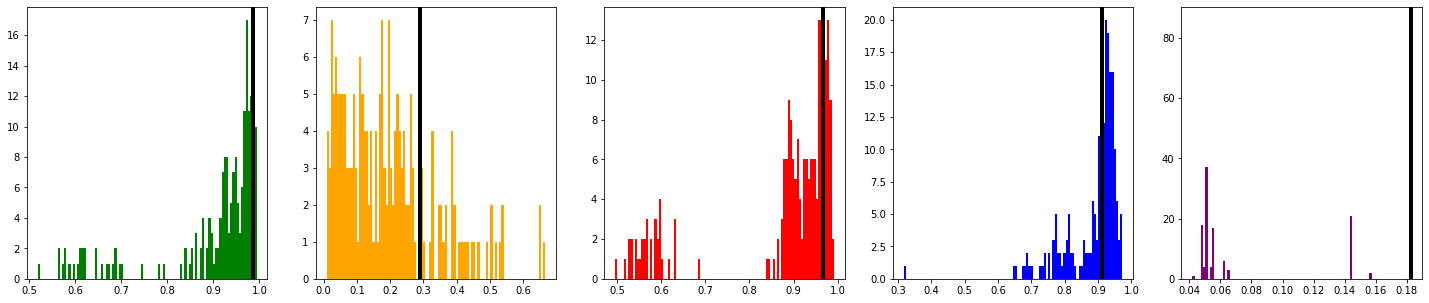

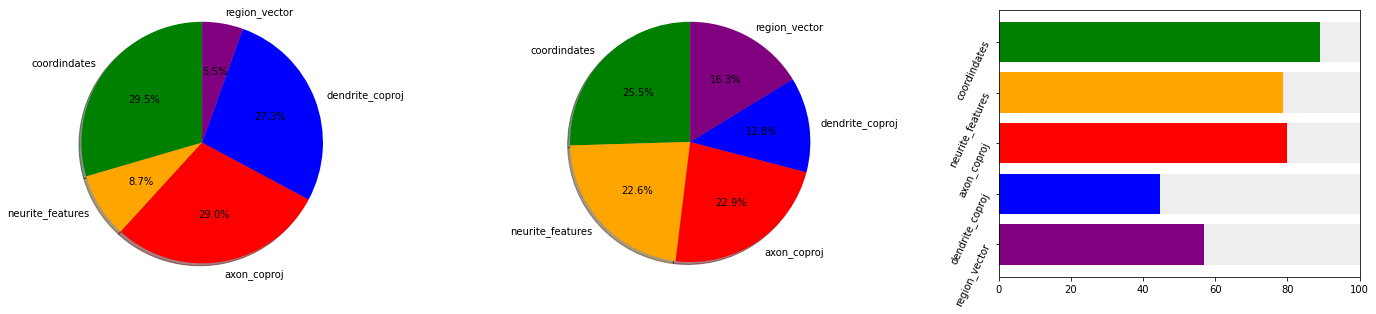

Morphology:  199  score: 0.67  normalized score: 0.76
	coordindates: 0.98, better than 75.38% of morphologies
	neurite_features: 0.27, better than 76.38% of morphologies
	axon_coproj: 0.97, better than 83.92% of morphologies
	dendrite_coproj: 0.94, better than 73.87% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


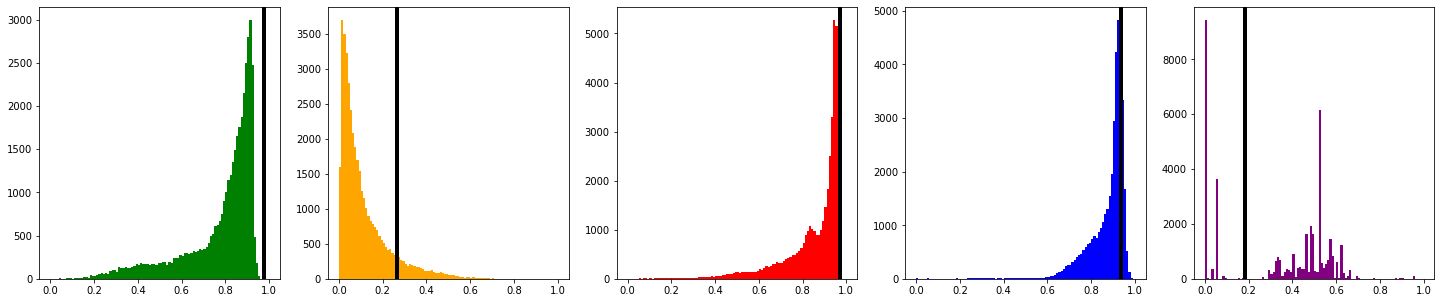

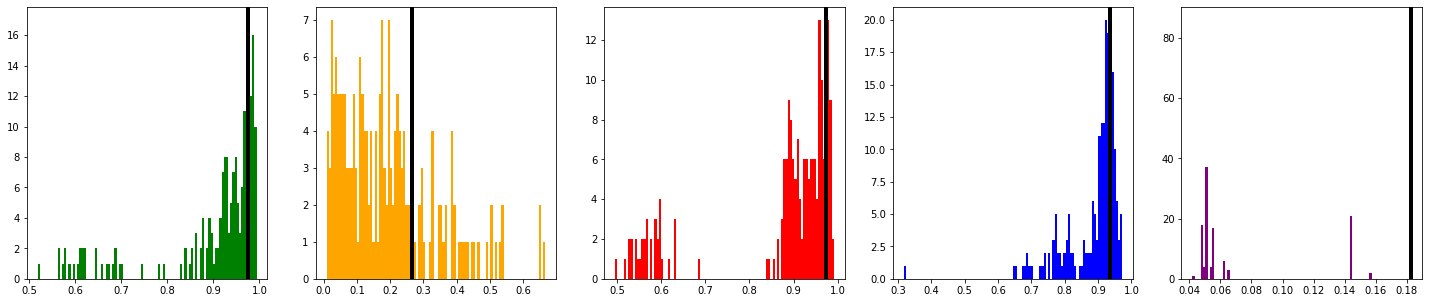

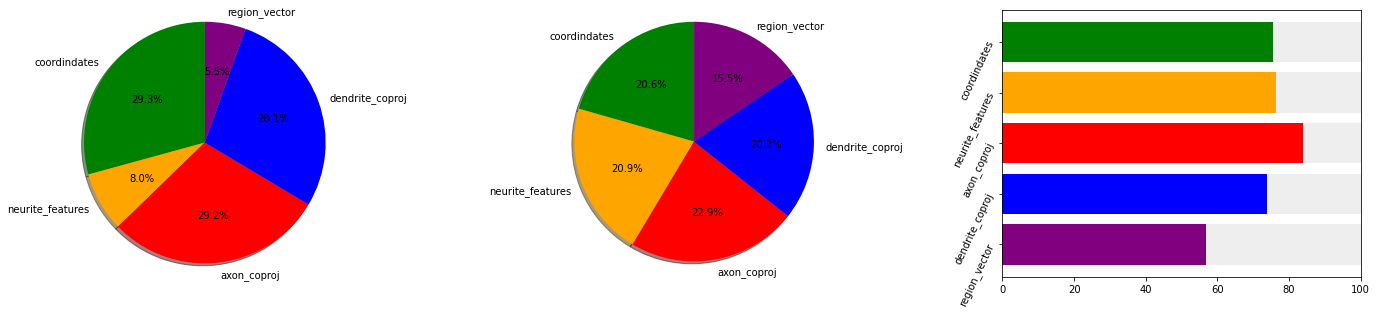

Morphology:  21  score: 0.67  normalized score: 0.76
	coordindates: 0.97, better than 72.86% of morphologies
	neurite_features: 0.29, better than 78.39% of morphologies
	axon_coproj: 0.97, better than 81.41% of morphologies
	dendrite_coproj: 0.92, better than 47.24% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


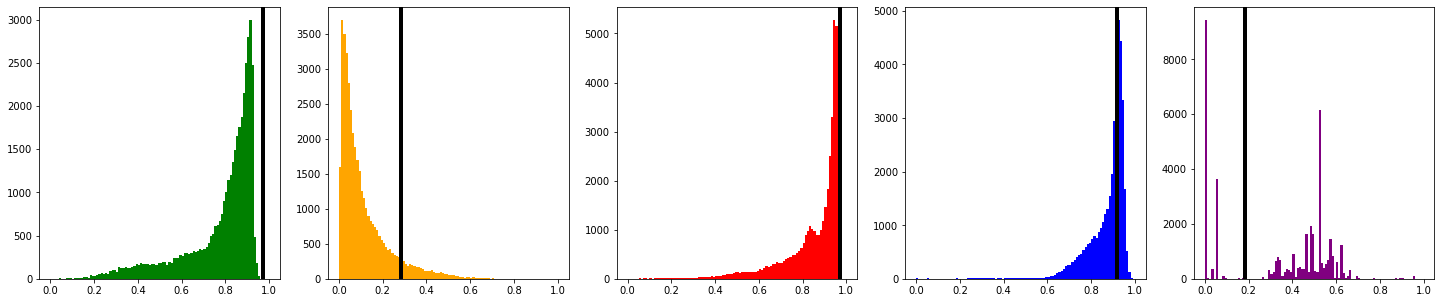

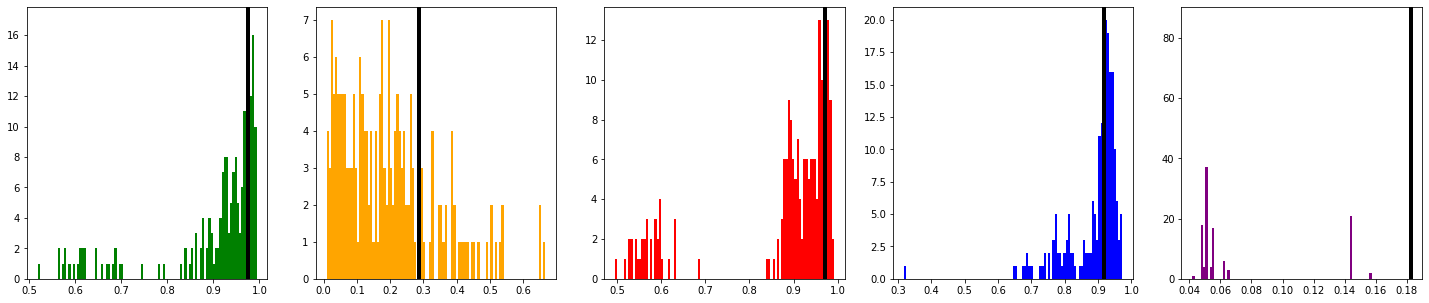

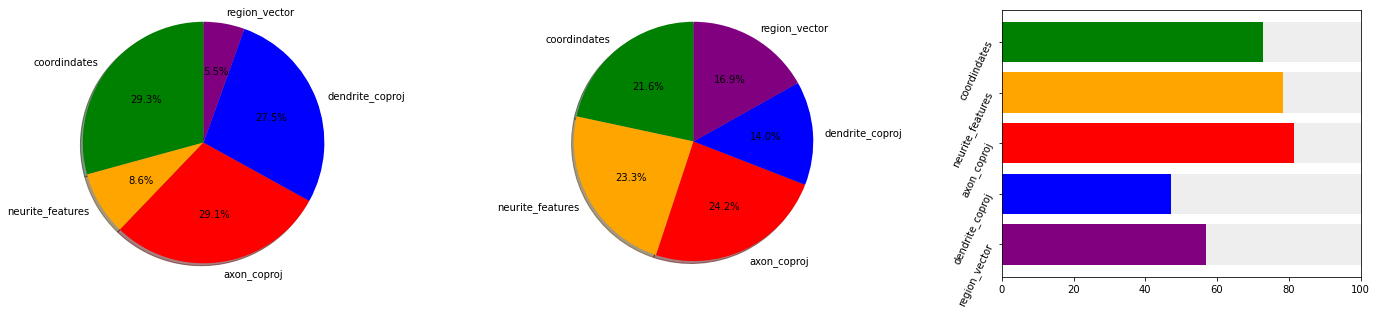

Morphology:  46  score: 0.67  normalized score: 0.75
	coordindates: 0.98, better than 76.38% of morphologies
	neurite_features: 0.26, better than 74.37% of morphologies
	axon_coproj: 0.98, better than 88.44% of morphologies
	dendrite_coproj: 0.93, better than 64.82% of morphologies
	region_vector: 0.18, better than 56.78% of morphologies


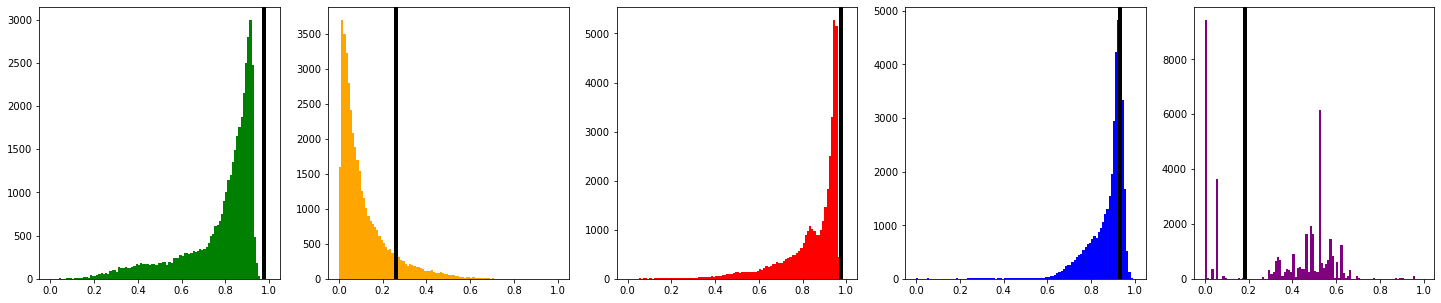

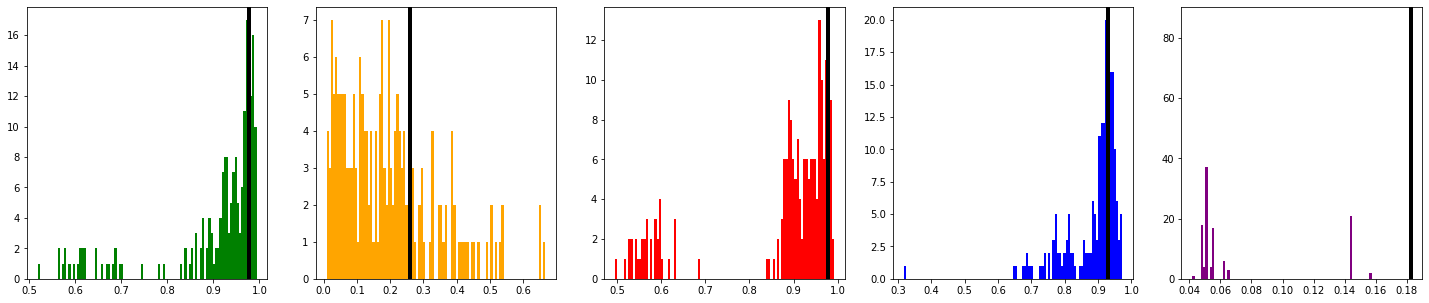

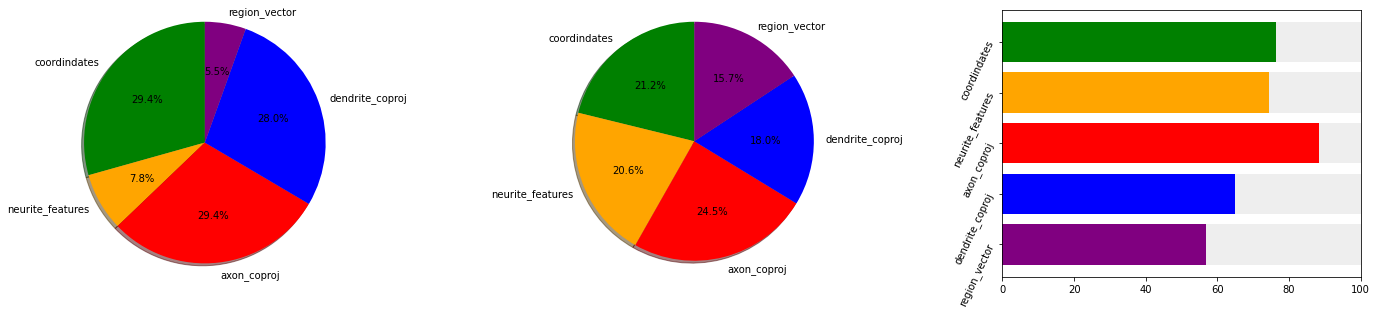

In [325]:
N = 20
for i, el in enumerate(boosted_score_table.sort_values(by="average", ascending=False).reset_index().to_dict("records")):

    percents = {}
    print("Morphology: ", el["point"], " score: {:.2f}".format(el["average"]), " normalized score: {:.2f}".format((el["average"] - boosted_min_avg) / (boosted_max_avg - boosted_min_avg)))
    for index_name in INDICES.keys():
        percents[index_name] = (sum(boosted_score_table[index_name] < el[index_name]) / boosted_score_table.shape[0]) * 100
        print("\t{}: {:.2f}, better than {:.2f}% of morphologies".format(
            index_name, el[index_name], percents[index_name]))

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
    ax1.hist(boosted_scaled_similarities["coordindates"], bins=100, color=COLORS["coordindates"])
    ax1.axvline(x=el["coordindates"], linewidth=4, c="black")

    ax2.hist(boosted_scaled_similarities["neurite_features"], bins=100, color=COLORS["neurite_features"])  
    ax2.axvline(x=el["neurite_features"], linewidth=4, c="black")

    ax3.hist(boosted_scaled_similarities["axon_coproj"], bins=100, color=COLORS["axon_coproj"]) 
    ax3.axvline(x=el["axon_coproj"], linewidth=4, c="black") 

    ax4.hist(boosted_scaled_similarities["dendrite_coproj"], bins=100, color=COLORS["dendrite_coproj"])  
    ax4.axvline(x=el["dendrite_coproj"], linewidth=4, c="black")

    ax5.hist(boosted_scaled_similarities["region_vector"], bins=100, color=COLORS["region_vector"])
    ax5.axvline(x=el["region_vector"], linewidth=4, c="black")
    plt.show()
        
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
    ax1.hist(boosted_score_table["coordindates"], bins=100, color=COLORS["coordindates"])
    ax1.axvline(x=el["coordindates"], linewidth=4, c="black")

    ax2.hist(boosted_score_table["neurite_features"], bins=100, color=COLORS["neurite_features"])  
    ax2.axvline(x=el["neurite_features"], linewidth=4, c="black")

    ax3.hist(boosted_score_table["axon_coproj"], bins=100, color=COLORS["axon_coproj"]) 
    ax3.axvline(x=el["axon_coproj"], linewidth=4, c="black") 

    ax4.hist(boosted_score_table["dendrite_coproj"], bins=100, color=COLORS["dendrite_coproj"])  
    ax4.axvline(x=el["dendrite_coproj"], linewidth=4, c="black")

    ax5.hist(boosted_score_table["region_vector"], bins=100, color=COLORS["region_vector"])
    ax5.axvline(x=el["region_vector"], linewidth=4, c="black")
    plt.show()
     
    keys = INDICES.keys()
    aspect_scores = np.array([
        el[k] for k in keys
    ])
    
    aspect_scores = aspect_scores / sum(aspect_scores)
        
    fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.pie(aspect_scores, labels=keys, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[COLORS[k] for k in keys])
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    ax2.pie([percents[k] for k in keys], labels=keys, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=[COLORS[k] for k in keys])
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    X = np.arange(len(keys))
    ax3.barh(X, [100 for k in keys], color = "#eee")
    ax3.barh(X, [percents[k] for k in keys], color = [COLORS[k] for k in keys])
    ax3.set_yticks(X)
    ax3.set_yticklabels(keys, rotation=65)
    plt.xlim([0, 100])
    ax3.invert_yaxis()
    fig1.tight_layout(pad=3.0)
    plt.show()


    if i == N - 1:
        break